# The purpose of this is to provide a time-series forecast model to predict if the number of positives a country/territory will receive within the next number of days will increase or decrease

> data from: https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide

In [1]:
# Import custom Time_Series python library and other imports
%run ./utils_grdive.ipynb
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from math import sqrt
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional, TimeDistributed, GRU
from keras.optimizers import Adam
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

ERROR:root:File `'./utils_grdive.ipynb.py'` not found.


## Set start and end dates for train and test sets

In [ ]:
str_train_start = '01/01/2020'
str_train_end = '11/01/2020'
str_test_start = str_train_end
str_test_end = '12/01/2020'
start_train_date = pd.to_datetime(str_train_start) # start of train data
end_train_date = pd.to_datetime(str_train_end) # end of train data
start_test_date = pd.to_datetime(str_test_start) # start of train data
end_test_date = pd.to_datetime(str_test_end) # end of train data
k = 17 # number of n-day components
n = 5 # n in n-day averages

## Define model evaluations

In [2]:
models = {} # trained models
Ps_test = {} # post processed predictions
Ts_test = {} # post processed truths

# MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    aerror = np.zeros(y_true.shape, dtype=float)
    for i in range(y_true.shape[0]):
        if y_true[i] < 1:
            aerror[i] = y_pred[i]
        else:
            aerror[i] = np.abs((y_true[i] - y_pred[i]) / y_true[i])
    return np.mean(aerror)

# Measure how accurately model predicted if cases increase or decrease
def increase_decrease_accuracy(x_true, y_true, y_pred):
    n_correct = 0
    for i in range(y_true.shape[0]):
        if y_true[i] > x_true[i, -1]:
            if y_pred[i] > x_true[i, -1]:
                n_correct += 1
        elif y_true[i] < x_true[i, -1]:
            if y_pred[i] < x_true[i, -1]:
                n_correct += 1
    return n_correct / y_true.shape[0]

# plot and evalute model predictions
def evaluate(model_name, proc, X_test, Y_test, P_Test):
    r2 = r2_score(Y_test, P_Test)
    rmse = sqrt(mean_squared_error(Y_test, P_Test))
    mae = mean_absolute_error(Y_test, P_Test)
    mape = mean_absolute_percentage_error(Y_test, P_Test)
    ida = increase_decrease_accuracy(X_test, Y_test, P_Test)
    plt.scatter(np.log10(P_Test), np.log10(Y_test))
    max_order = int(max(np.log10(Y_test).max(), np.log10(P_Test).max())) + 2
    plt.plot([x for x in range(max_order)], [x for x in range(max_order)], color='green')
    plt.xticks(np.arange(0, max_order, 1))
    plt.yticks(np.arange(0, max_order, 1))
    plt.xlabel(r'log$_{10}$(Predicted)')
    plt.ylabel(r'log$_{10}$(Expected)')
    plt.title(model_name + ' ' + proc.title() + ' ' + r'Forecasts, $r^2$=' + str(round(r2, 4)))
    plt.show()
    print('r2', r2, 'rmse', rmse, 'mae', mae, 'mape', mape, 'ida', ida, '\n\n')

## Read, Mungle, Plot, and Process Data

In [ ]:
# read data
data = readCOVID19('COVID-19-geographic-disbtribution-worldwide-2020-12-11.csv', days_min=100, cases_min=100)

# plot data
#plot5(data)

samples = {}
for_ARIMA = {}
# get trianing data (up to start_date)
samples['train'], for_ARIMA['train_raw'] = prepare_MLA(data, window_size=n, lags=k, sample_name='train'
                            ,outputs=1, label_type='next', deriv=False
                               , start_date=start_train_date, end_date=end_train_date)
# get testing data (between start_date and end_date)
samples['test'], for_ARIMA['test_raw'] = prepare_MLA(data, window_size=n, lags=k, sample_name='test'
                            ,outputs=1, label_type='next', deriv=False
                              , start_date=start_test_date, end_date=end_test_date)

In [ ]:
# get X and Y for train and test
Xs_train = {'raw': np.array(samples['train']['Xs'])}
Ys_train = {'raw' : np.array(samples['train']['Ys']).flatten()}
Xs_test = {'raw' : np.array(samples['test']['Xs'])}
Ys_test = {'raw' : np.array(samples['test']['Ys']).flatten()}

# get statistics on train data
X_min = np.min(Xs_train['raw'])
X_max = np.max(Xs_train['raw'])
X_mean = np.mean(Xs_train['raw'])
X_std = np.std(Xs_train['raw'])

# define methods for forward and backward processing
reverses = {}
def preproc(base, name, func):
    Xs_train[name] = func(Xs_train[base])
    Ys_train[name] = func(Ys_train[base])
    Xs_test[name] = func(Xs_test[base])
    Ys_test[name] = func(Ys_test[base])
    for_ARIMA['train_' + name] = {}
    for country in for_ARIMA['train_' + base]:
        for_ARIMA['train_' + name][country] = func(for_ARIMA['train_' + base][country])
    for_ARIMA['test_' + name] = {}
    for country in for_ARIMA['test_' + base]:
        for_ARIMA['test_' + name][country] = func(for_ARIMA['test_' + base][country])

# raw
def reverse_raw(X):
    return X
reverses['raw'] = reverse_raw

# min max normalize between 0 and 1
def norm(X):
    return (X - X_min) / (X_max - X_min)
preproc('raw', 'norm', norm)
def reverse_norm(X):
    return X * (X_max - X_min) + X_min
reverses['norm'] = reverse_norm

# standardize to zero mean and unit variance 
def stand(X):
    return (X - X_mean) / X_std
preproc('raw', 'stand', stand)
def reverse_stand(X):
    return X * X_std + X_mean
reverses['stand'] = reverse_stand
        
# log10 to consider the large range of values
preproc('raw', 'log10', np.log10)
def reverse_log10(X):
    return np.power(10, X)
reverses['log10'] = reverse_log10

# get statistics on ln train data
X_log10_min = np.min(Xs_train['log10'])
X_log10_max = np.max(Xs_train['log10'])
X_log10_mean = np.mean(Xs_train['log10'])
X_log10_std = np.std(Xs_train['log10'])

# take log10 then min max normalize between 0 and 1
def log10_norm(X):
    retX = np.log10(X)
    return (retX - X_log10_min) / (X_log10_max - X_log10_min)
preproc('raw', 'log10_norm', log10_norm)
def reverse_log10_norm(X):
    retX = X * (X_log10_max - X_log10_min) + X_log10_min
    return np.power(10, retX)
reverses['log10_norm'] = reverse_log10_norm

# take log10 then standardize
def log10_stand(X):
    retX = np.log10(X)
    return (retX - X_log10_mean) / X_log10_std
preproc('raw', 'log10_stand', log10_stand)
def reverse_log10_stand(X):
    retX = X * X_log10_std + X_log10_mean
    return np.power(10, retX)
reverses['log10_stand'] = reverse_log10_stand
        
# ln to consider the large range of values
preproc('raw', 'ln', np.log)
def reverse_ln(X):
    return np.exp(X)
reverses['ln'] = reverse_ln

# get statistics on ln train data
X_ln_min = np.min(Xs_train['ln'])
X_ln_max = np.max(Xs_train['ln'])
X_ln_mean = np.mean(Xs_train['ln'])
X_ln_std = np.std(Xs_train['ln'])

# take ln then min max normalize between 0 and 1
def ln_norm(X):
    retX = np.log(X)
    return (retX - X_ln_min) / (X_ln_max - X_ln_min)
preproc('raw', 'ln_norm', ln_norm)
def reverse_ln_norm(X):
    retX = X * (X_ln_max - X_ln_min) + X_ln_min
    return np.exp(retX)
reverses['ln_norm'] = reverse_ln_norm

# take ln then standardize
def ln_stand(X):
    retX = np.log(X)
    return (retX - X_ln_mean) / X_ln_std
preproc('raw', 'ln_stand', ln_stand)
def reverse_ln_stand(X):
    retX = X * X_ln_std + X_ln_mean
    return np.exp(retX)
reverses['ln_stand'] = reverse_ln_stand

# preprare for RNN by casting X and Y in dimensions [N_samples, N_timesteps, N_features]
procs = ['raw', 'norm', 'stand', 'log10', 'log10_norm', 'log10_stand', 'ln', 'ln_norm', 'ln_stand']
for proc in procs:
    Xs_train[proc + '_rnn'] = np.expand_dims(Xs_train[proc], axis=2)
    Ys_train[proc + '_rnn'] = np.expand_dims(np.expand_dims(Ys_train[proc], axis=1), axis=2)
    Xs_test[proc + '_rnn'] = np.expand_dims(Xs_test[proc], axis=2)
    Ys_test[proc + '_rnn'] = np.expand_dims(np.expand_dims(Ys_test[proc], axis=1), axis=2)

# post_process model predictions by undoing processing and removing <1 values
def post_process(X, Y, P, proc):
    P = reverses[proc](P)
    drop_rows = [r for r in range(P.shape[0]) if P[r] <= 1]
    return np.delete(X, drop_rows, axis=0), np.delete(Y, drop_rows, axis=0), np.delete(P, drop_rows, axis=0)

## Elastic Net

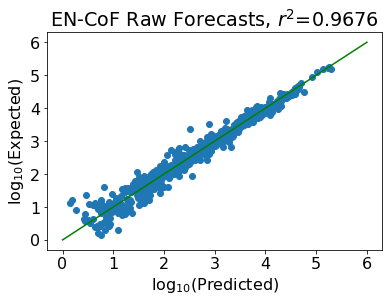

r2 0.9676124792848567 rmse 2536.8590923358333 mae 665.9570643177016 mape 0.29046083527242983 ida 0.645909645909646 




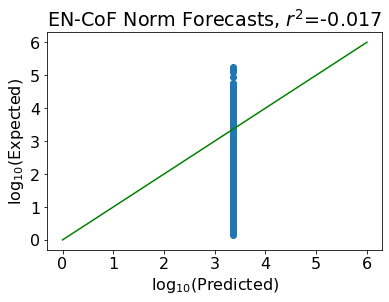

r2 -0.017009626115068066 rmse 14121.106433640067 mae 4412.22345419348 mape 49.61783767833322 ida 0.5499398315282792 




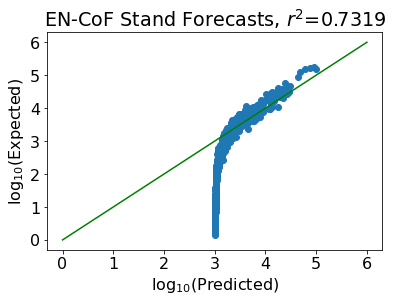

r2 0.7319294542250229 rmse 7249.878759510887 mae 2046.539395896639 mape 22.469358259101615 ida 0.5499398315282792 




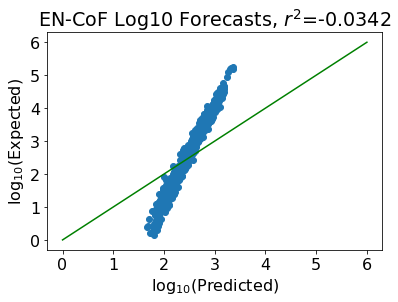

r2 -0.03422114142871546 rmse 14240.095447575413 mae 3729.7217959781165 mape 2.017312409384578 ida 0.48736462093862815 




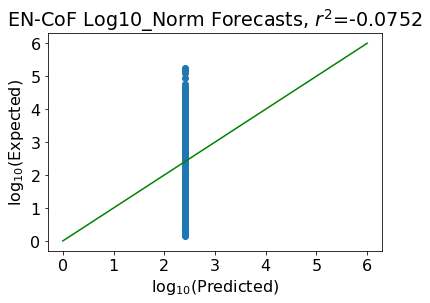

r2 -0.075217499956453 rmse 14519.590122666918 mae 3976.7501916517067 mape 5.699437105154447 ida 0.48736462093862815 




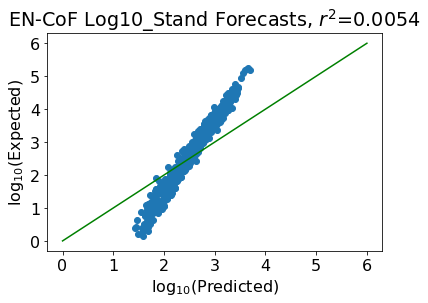

r2 0.005390961351660395 rmse 13964.725245468579 mae 3574.607874678973 mape 1.4537894121194062 ida 0.4897713598074609 




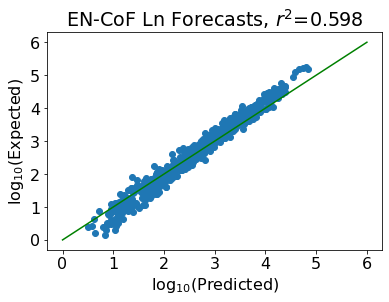

r2 0.5979767950040732 rmse 8878.3396495938 mae 1883.316919255141 mape 0.39380755013817587 ida 0.49338146811071 




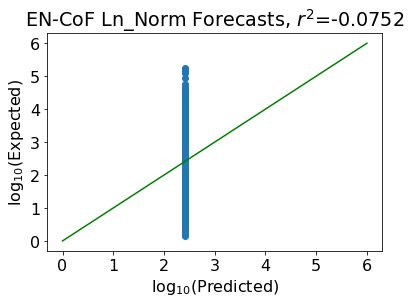

r2 -0.075217499956453 rmse 14519.590122666918 mae 3976.7501916517067 mape 5.699437105154449 ida 0.48736462093862815 




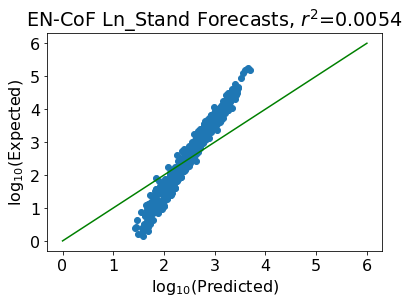

r2 0.005390961351660395 rmse 13964.725245468579 mae 3574.607874678973 mape 1.453789412119406 ida 0.4897713598074609 




In [ ]:
#### EN-CoF elastic net linear regression
model_name = 'EN-CoF'

for proc in procs:
    
    # create and train model
    models[proc + '_' + model_name] = ElasticNet(
        fit_intercept = False if proc == 'raw' else True
        , max_iter = 10000
    )
    models[proc + '_' + model_name].fit(Xs_train[proc], Ys_train[proc])
    
    # get predictions and post process
    returns = post_process(
        Xs_test['raw']
        , Ys_test['raw']
        , models[proc + '_' + model_name].predict(Xs_test[proc])
        , proc
    )
    Xs_test[proc + '_' + model_name] = returns[0]
    Ts_test[proc + '_' + model_name] = returns[1]
    Ps_test[proc + '_' + model_name] = returns[2]
    
    # evaluate model
    evaluate(
        model_name
        , proc
        , Xs_test[proc + '_' + model_name]
        , Ts_test[proc + '_' + model_name]
        , Ps_test[proc + '_' + model_name]
    )
        
    #write weights
    weights = models[proc + '_' + model_name].coef_
    with open('Output/' + proc + '_' + model_name + '_weights.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        for r in range(len(weights)):
            writer.writerow([len(weights)-r, weights[r]])
    
# save values in samples for visualizing
temp = models['raw' + '_' + model_name].predict(Xs_test['raw'])
samples['test']['Ps'] = [None] * temp.shape[0]
for r in range(temp.shape[0]):
    samples['test']['Ps'][r] = temp[r]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1752111964.5996616, tolerance: 24874780.973448005
  model = cd_fast.enet_coordinate_descent(


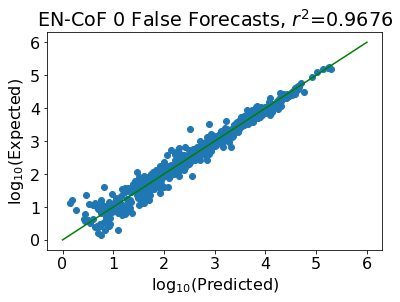

r2 0.9676124240833585 rmse 2536.8612542543738 mae 665.9577956312974 mape 0.29046140048974134 ida 0.645909645909646 




C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1747447524.9869475, tolerance: 23032400.65138967
  model = cd_fast.enet_coordinate_descent(


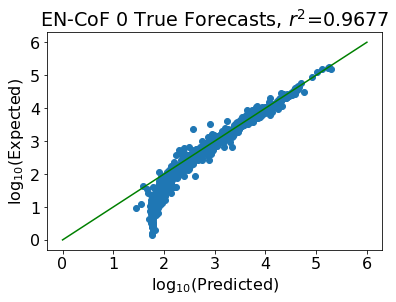

r2 0.9677142601194942 rmse 2521.6319340632267 mae 674.0374255885731 mape 1.3345537547729176 ida 0.6227327690447401 




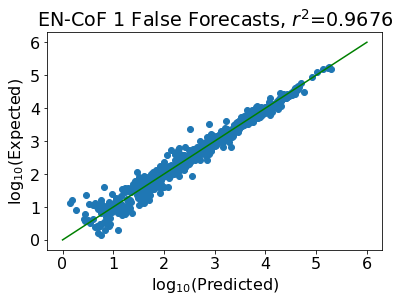

r2 0.9676124334342567 rmse 2536.8608880347297 mae 665.9576502881378 mape 0.290461276520743 ida 0.645909645909646 




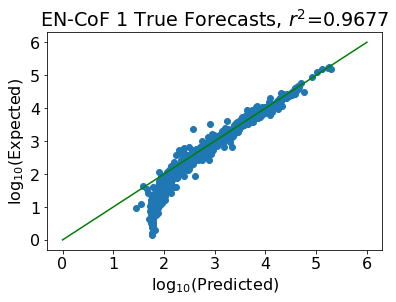

r2 0.9677142694507409 rmse 2521.631569661302 mae 674.0372942096611 mape 1.3345537769650369 ida 0.6227327690447401 




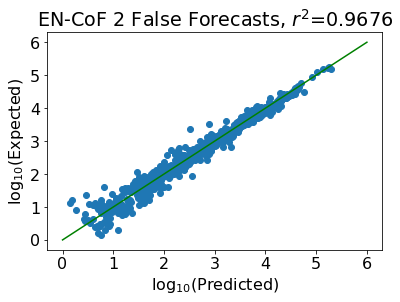

r2 0.9676124445051102 rmse 2536.8604544544914 mae 665.9574975658204 mape 0.2904611549823573 ida 0.645909645909646 




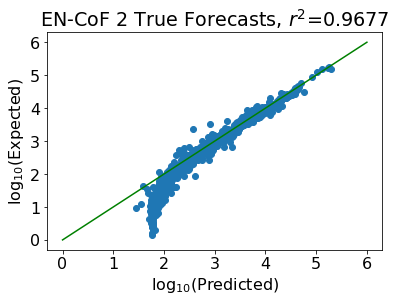

r2 0.9677142803785613 rmse 2521.631142910248 mae 674.0371548759423 mape 1.3345537870621464 ida 0.6227327690447401 




In [ ]:
#### EN-CoF elastic net linear regression
model_name = 'EN-CoF'
proc = 'raw'

for l1_x in range(11):
    l1_ratio = l1_x /10
    for fit_intercept in [False, True]:
        str_params = str(l1_x) + ' ' + str(fit_intercept)

        # create and train model
        models[proc + '_' + model_name] = ElasticNet(
            fit_intercept = fit_intercept
            , l1_ratio = l1_ratio
            , max_iter = 100000
        )
        models[proc + '_' + model_name].fit(Xs_train[proc], Ys_train[proc])

        # get predictions and post process
        returns = post_process(
            Xs_test['raw']
            , Ys_test['raw']
            , models[proc + '_' + model_name].predict(Xs_test[proc])
            , proc
        )
        Xs_test[proc + '_' + model_name] = returns[0]
        Ts_test[proc + '_' + model_name] = returns[1]
        Ps_test[proc + '_' + model_name] = returns[2]

        # evaluate model
        evaluate(
            model_name
            , str_params
            , Xs_test[proc + '_' + model_name]
            , Ts_test[proc + '_' + model_name]
            , Ps_test[proc + '_' + model_name]
        )

In [ ]:
#### EN-CoF elastic net linear regression
model_name = 'EN-CoF'
proc = 'raw'

for l1_x in range(11):
    l1_ratio = l1_x /10
    for fit_intercept in [False, True]:
        str_params = str(l1_x) + ' ' + str(fit_intercept)

        # create and train model
        models[proc + '_' + model_name] = ElasticNet(
            fit_intercept = fit_intercept
            , l1_ratio = l1_ratio
            , max_iter = 100000
        )
        models[proc + '_' + model_name].fit(Xs_train[proc], Ys_train[proc])

        # get predictions and post process
        returns = post_process(
            Xs_test['raw']
            , Ys_test['raw']
            , models[proc + '_' + model_name].predict(Xs_test[proc])
            , proc
        )
        Xs_test[proc + '_' + model_name] = returns[0]
        Ts_test[proc + '_' + model_name] = returns[1]
        Ps_test[proc + '_' + model_name] = returns[2]

        # evaluate model
        evaluate(
            model_name
            , str_params
            , Xs_test[proc + '_' + model_name]
            , Ts_test[proc + '_' + model_name]
            , Ps_test[proc + '_' + model_name]
        )

## Visualize time series and forecasts

<ipython-input-7-6cf3b381fca0>:34: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  raws = data[data['Country'] == country][data['Date'] >= dates[0]]['Cases'].to_numpy()[0:n*len(aves)]
<ipython-input-7-6cf3b381fca0>:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(15,10))


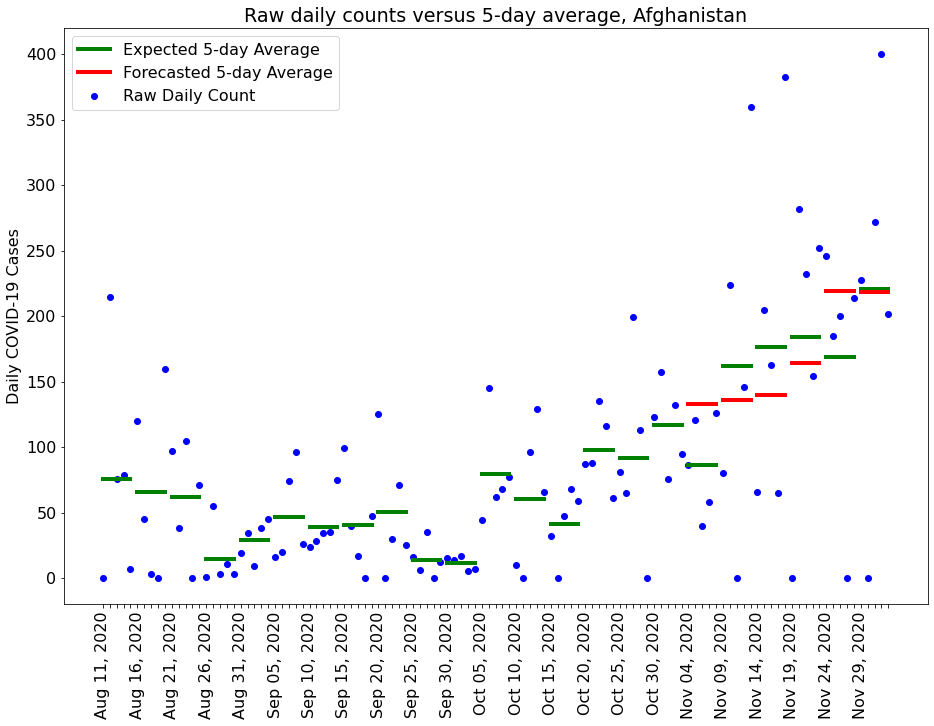

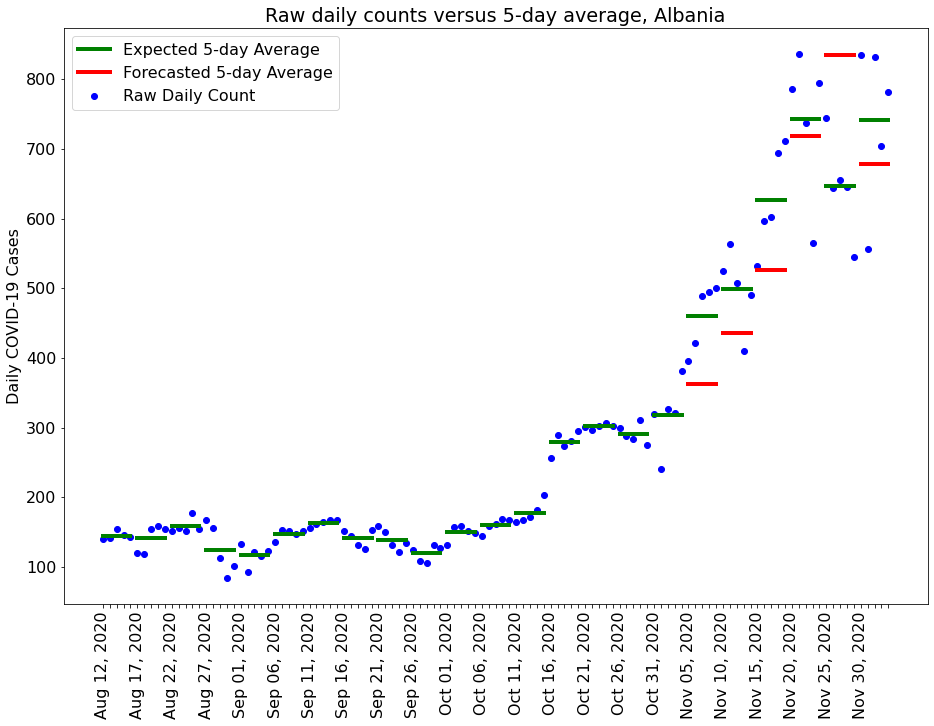

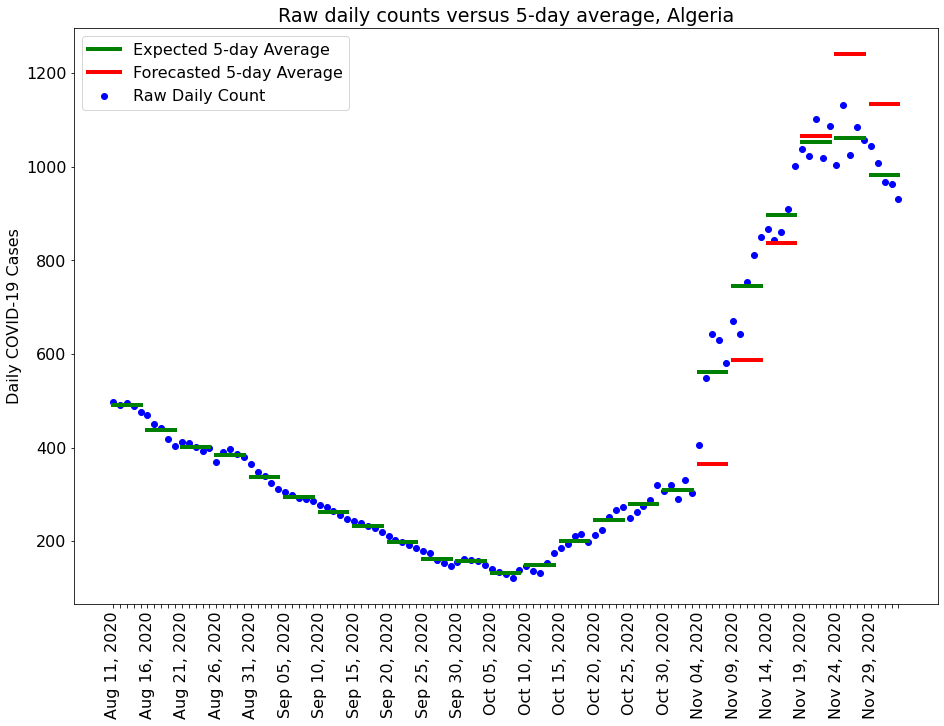

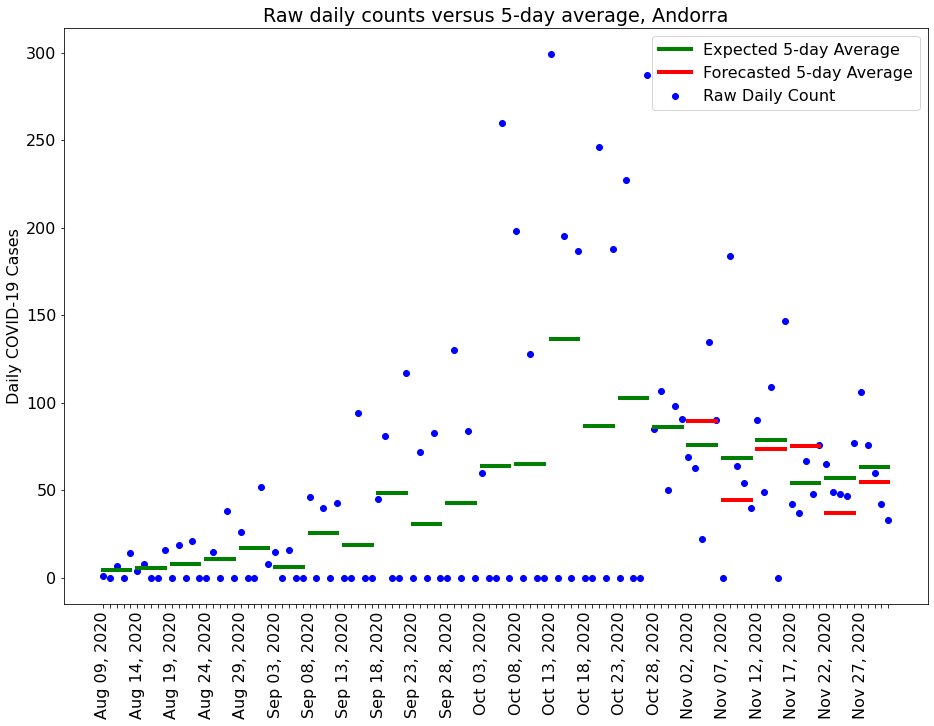

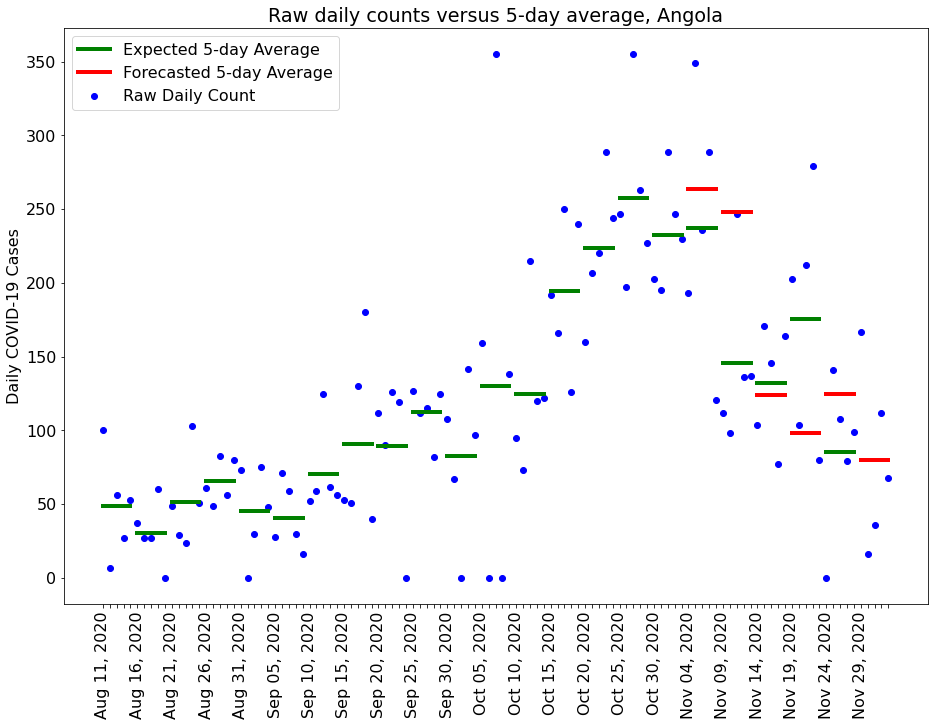

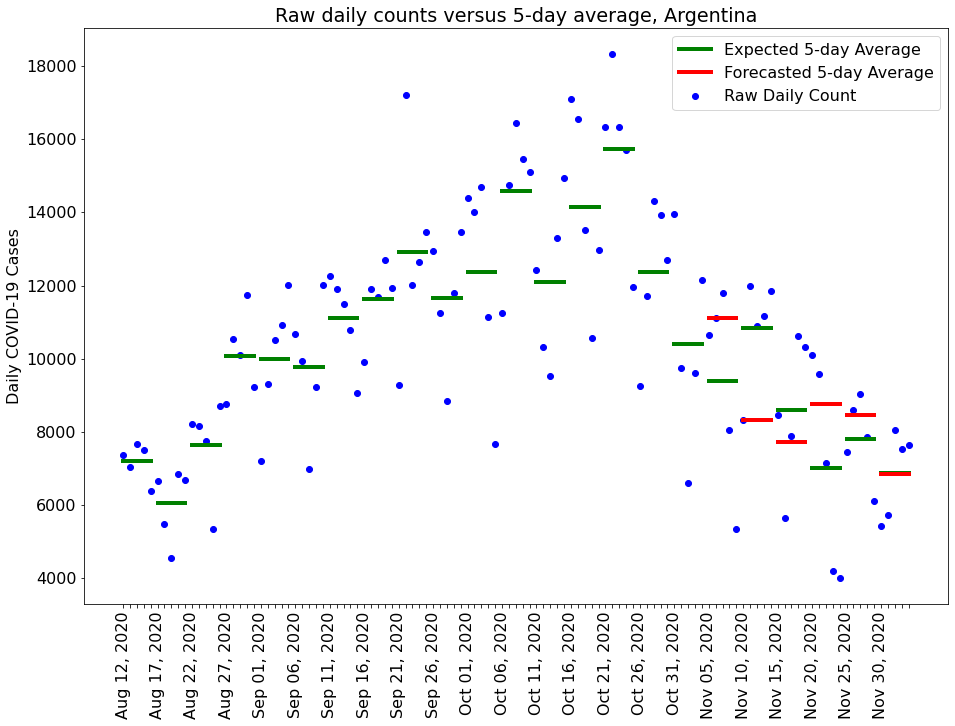

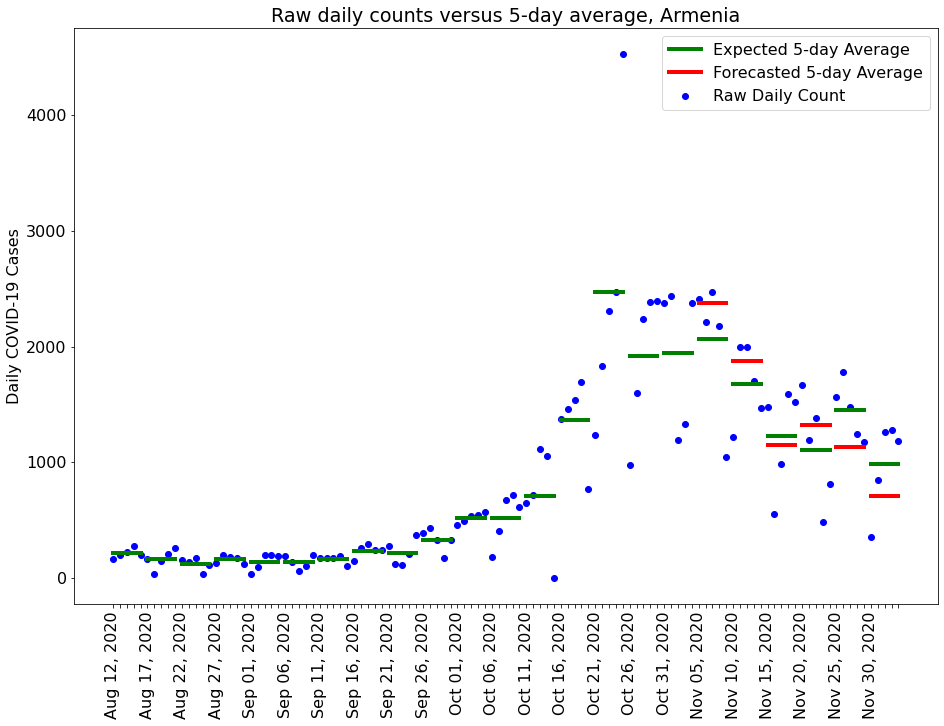

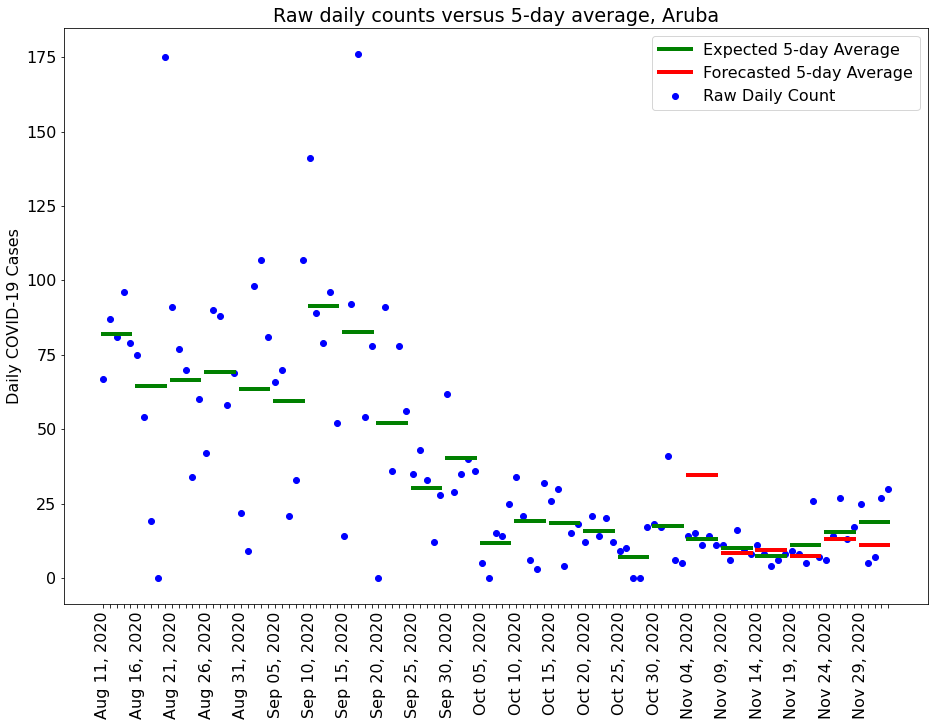

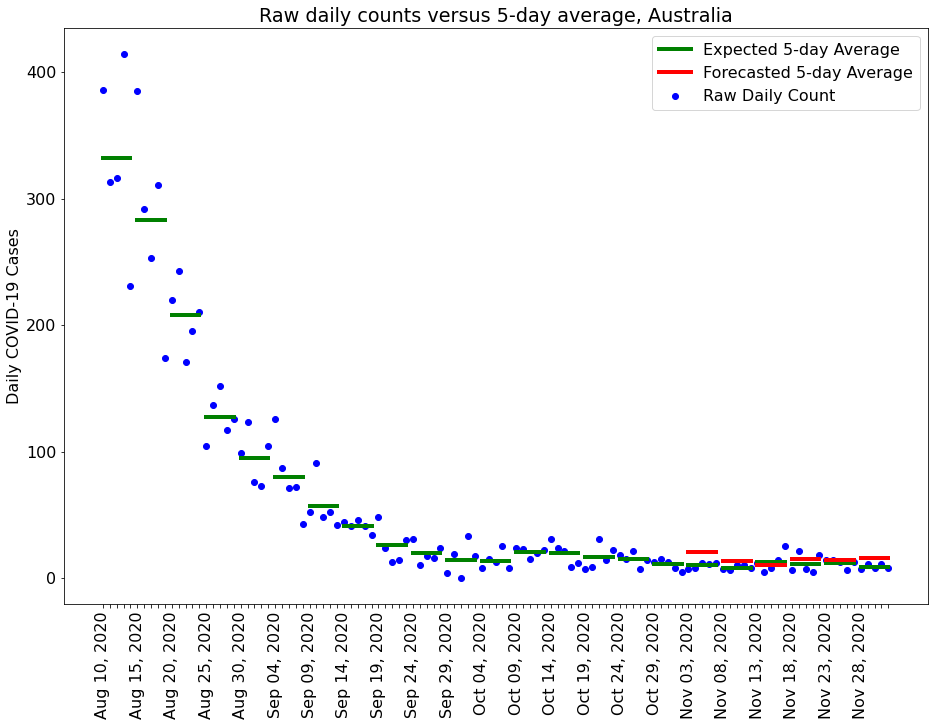

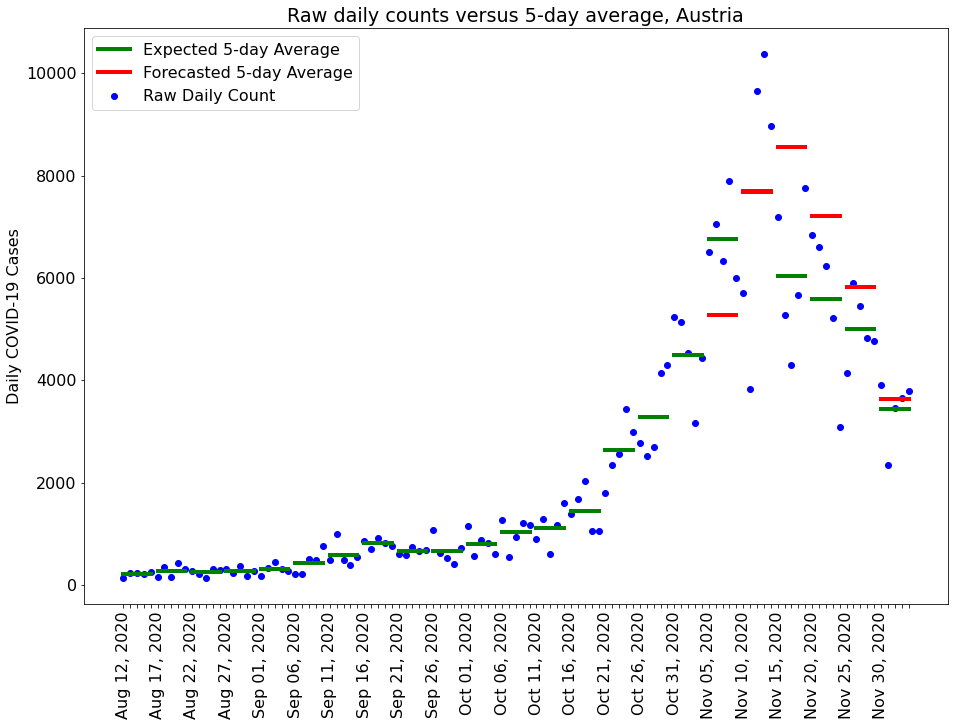

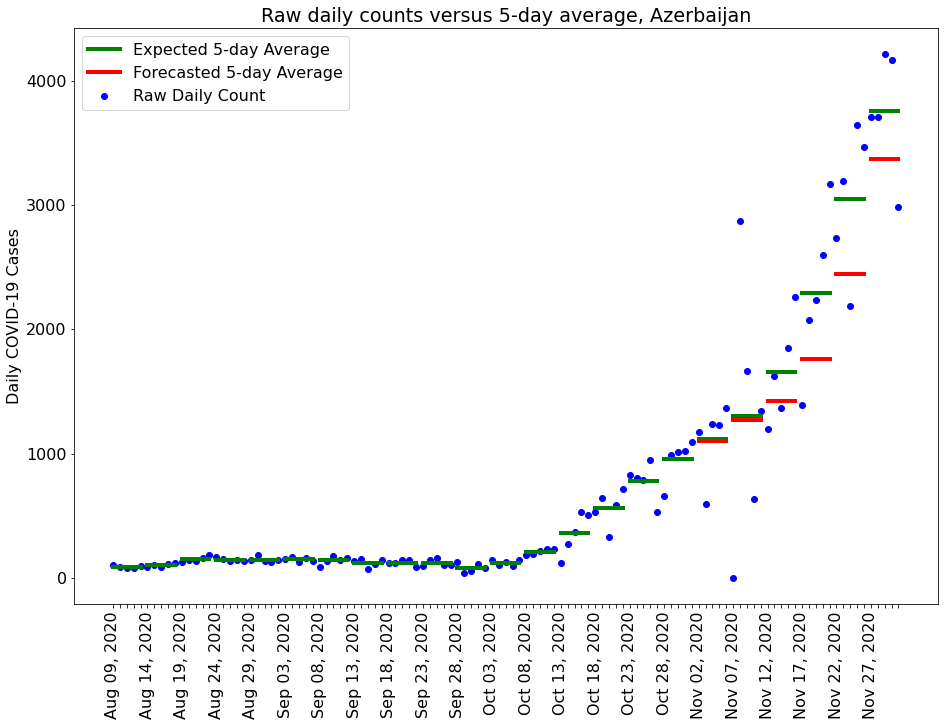

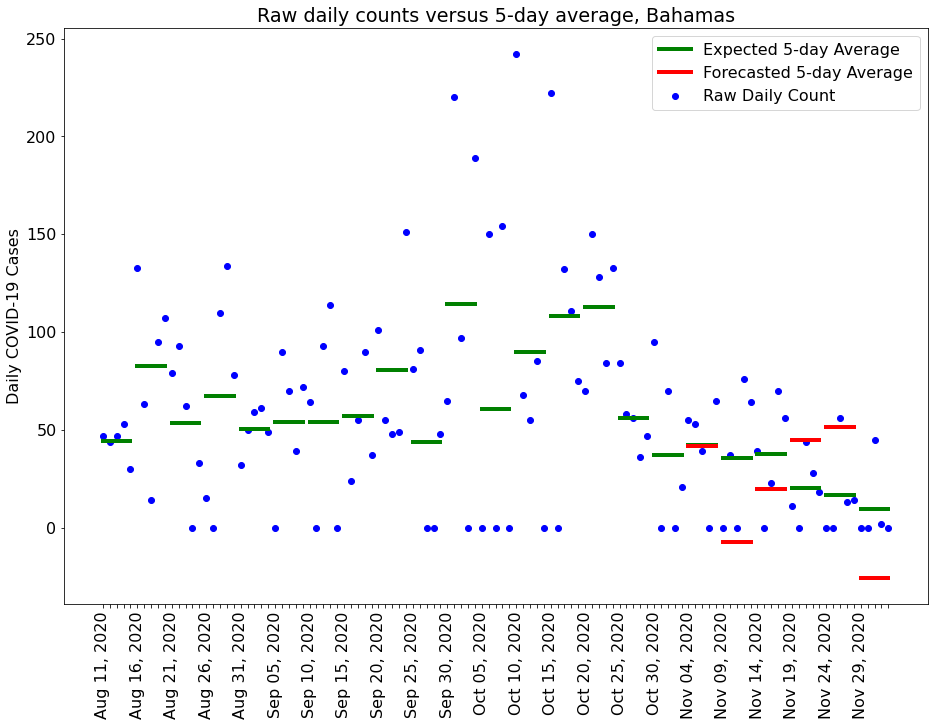

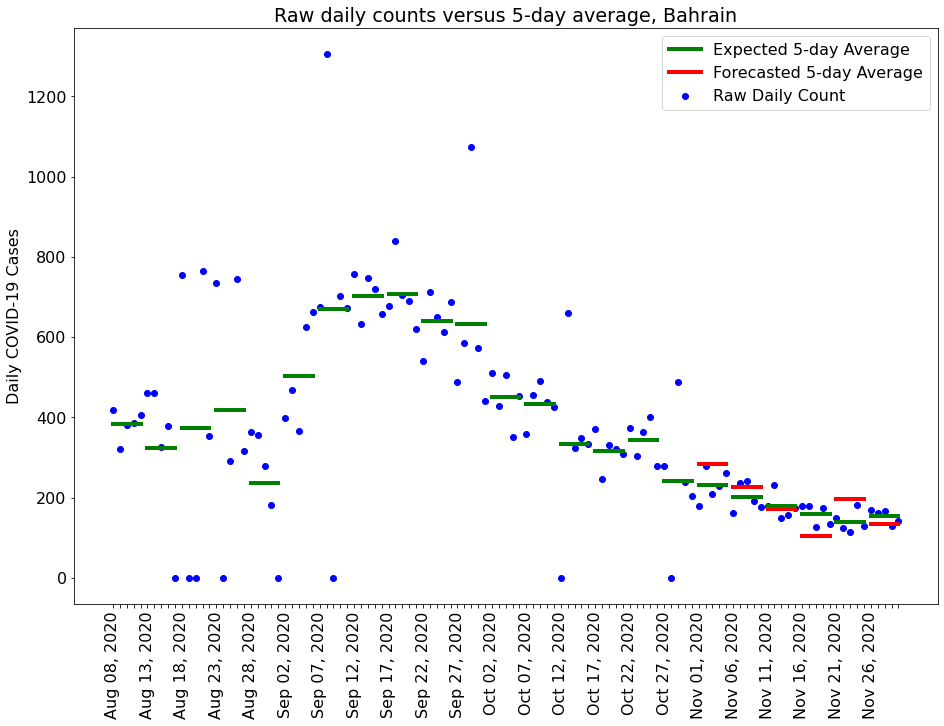

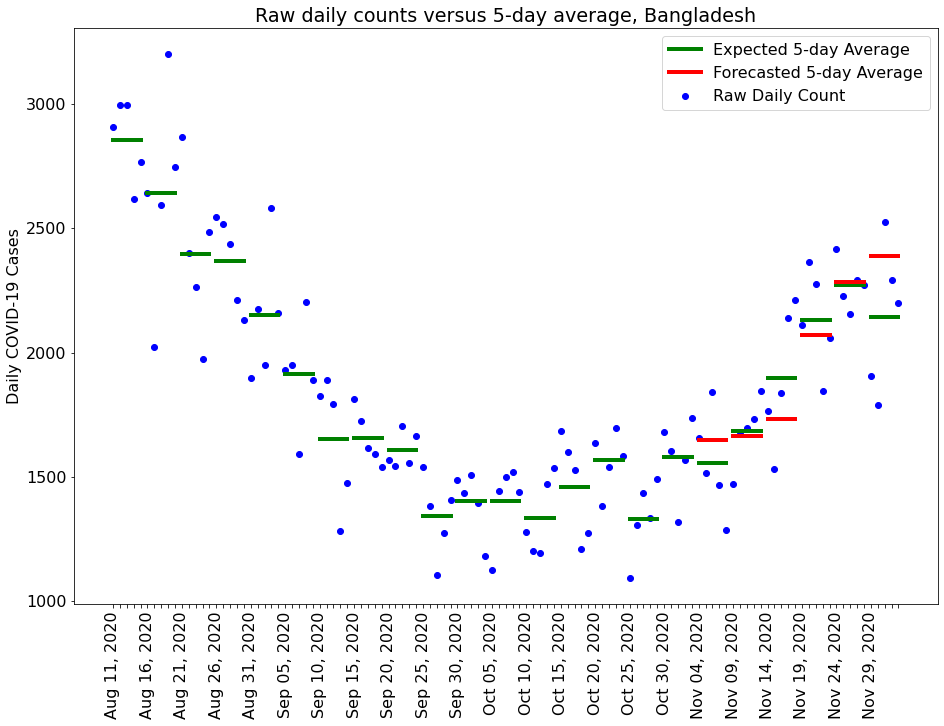

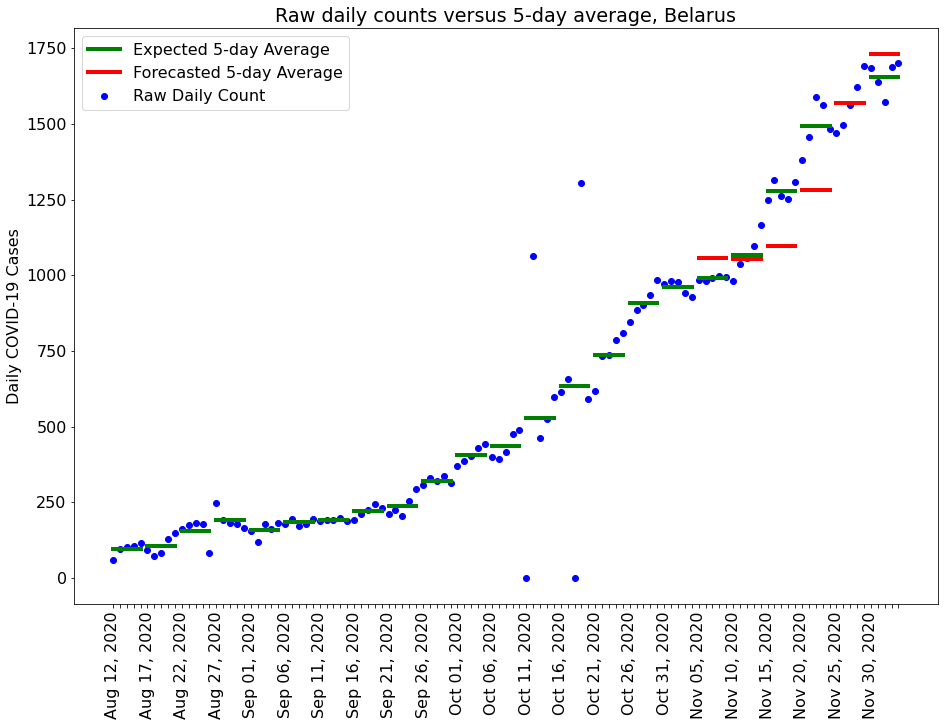

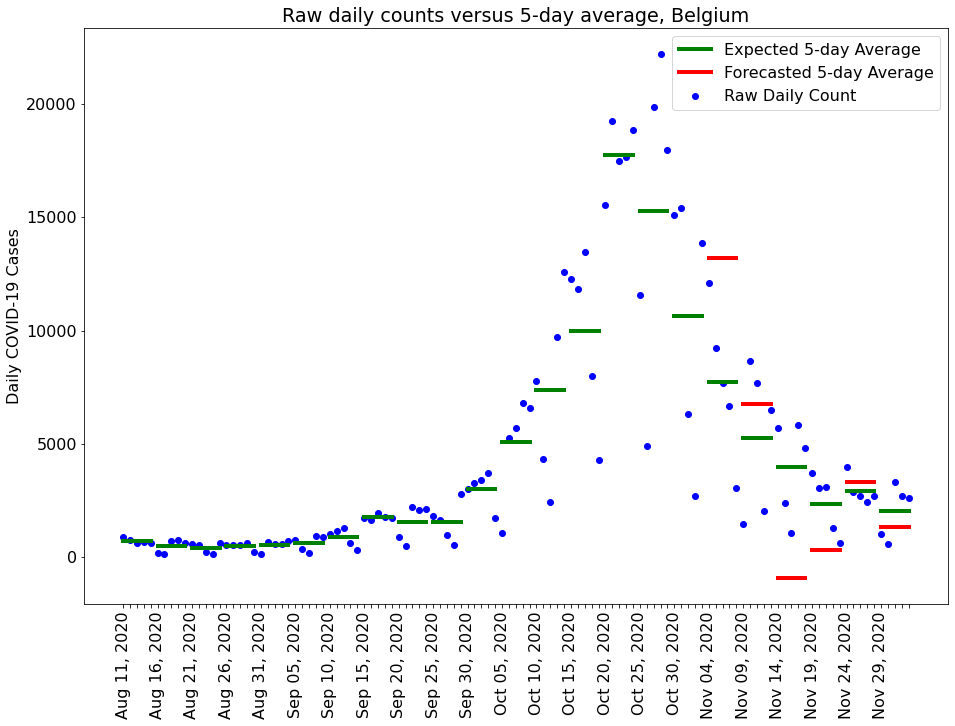

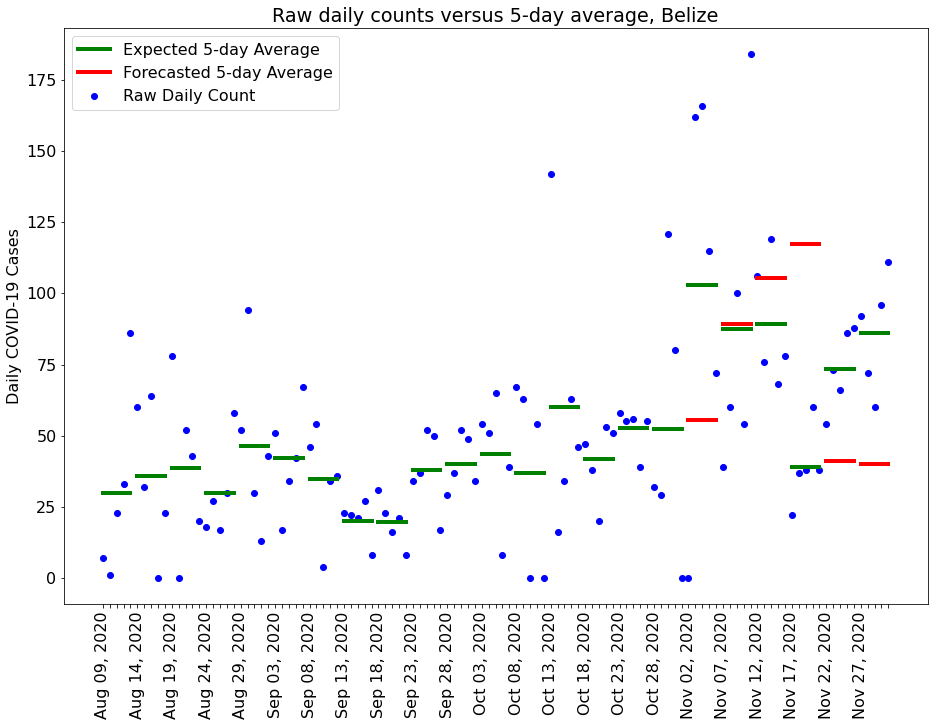

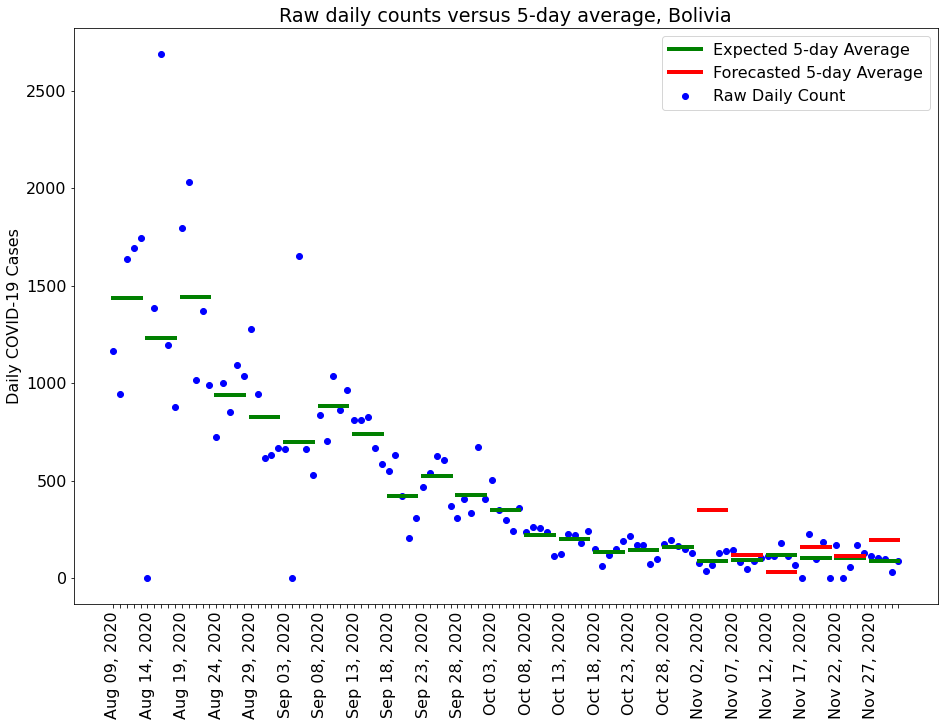

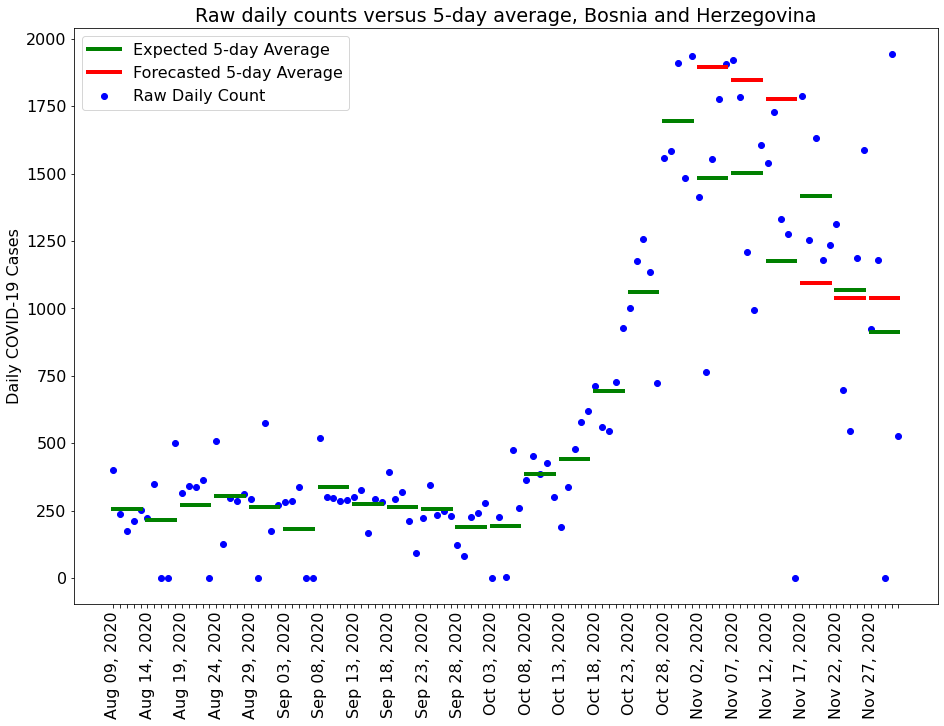

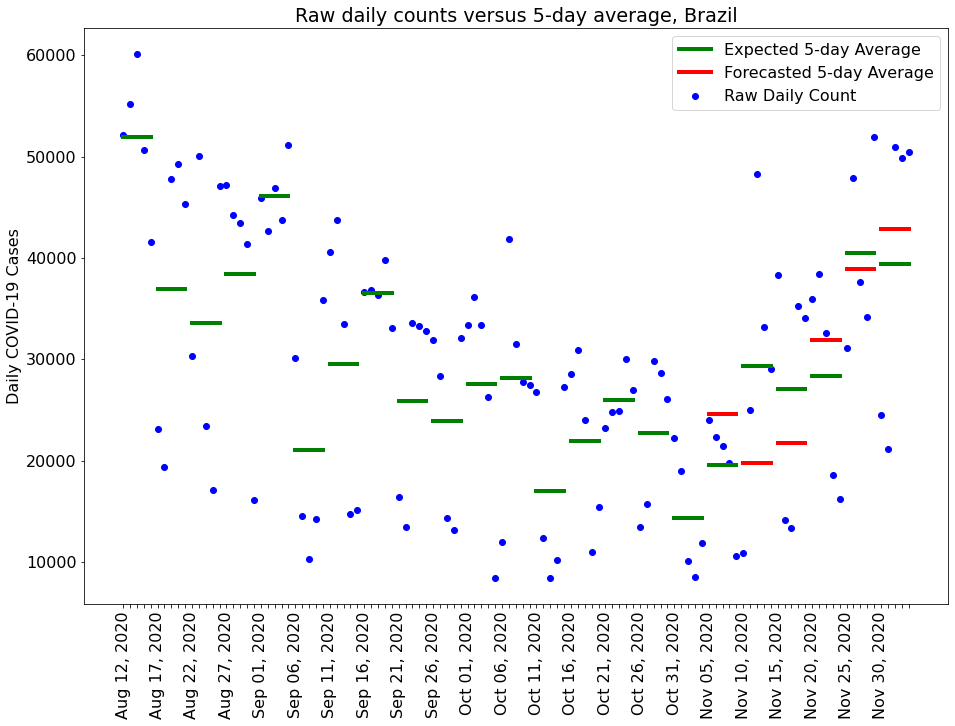

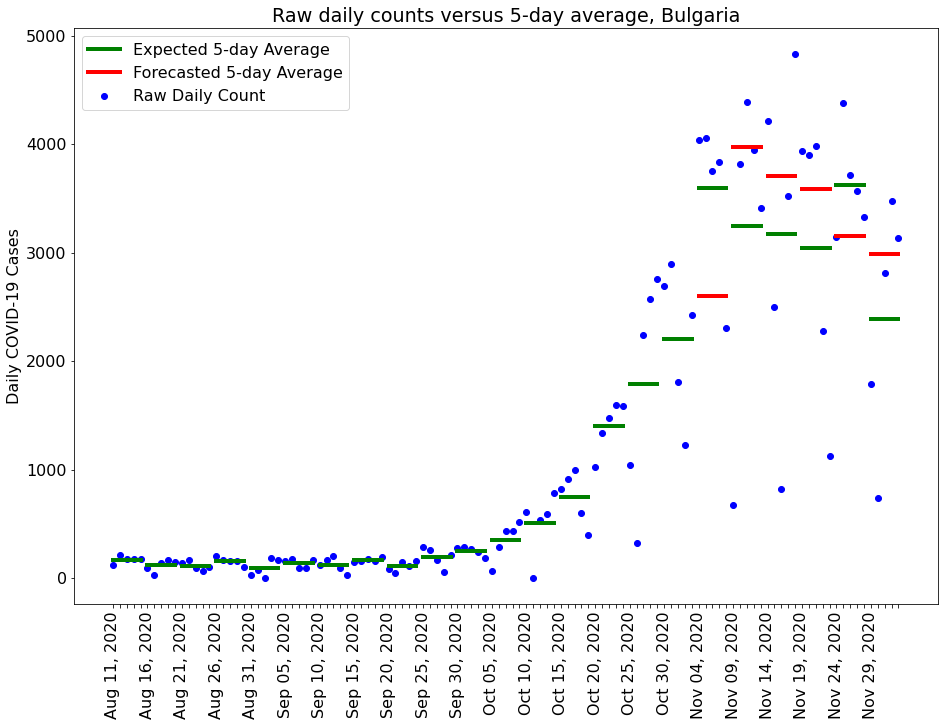

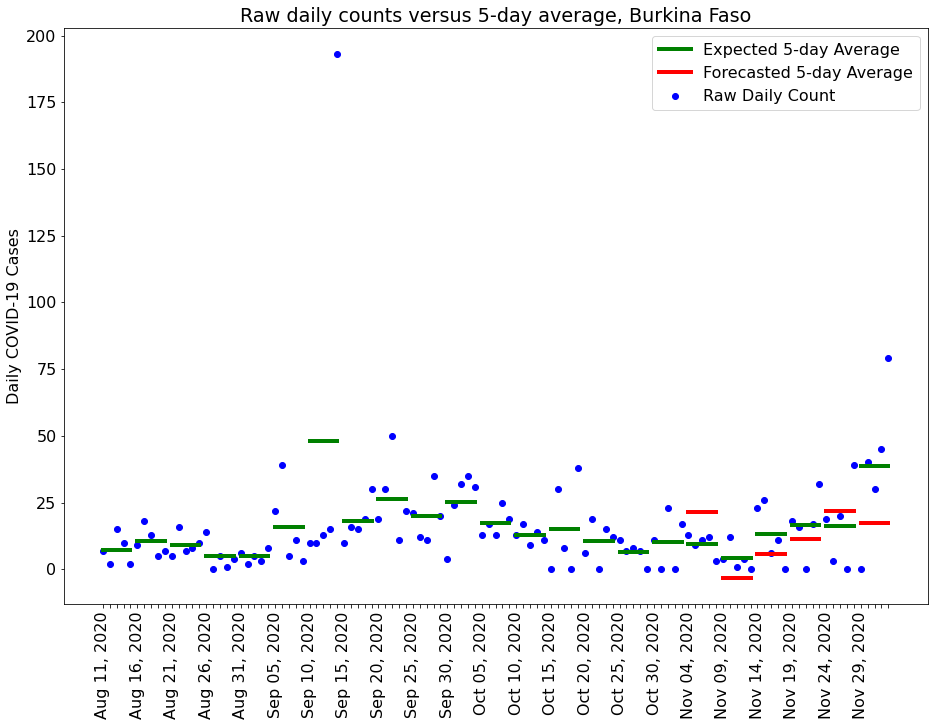

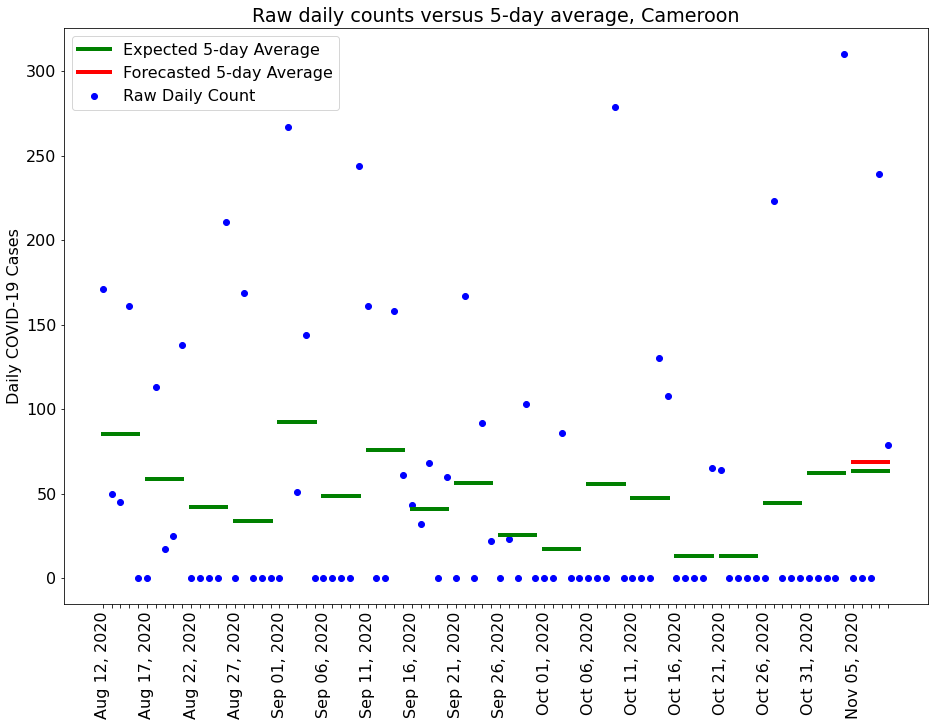

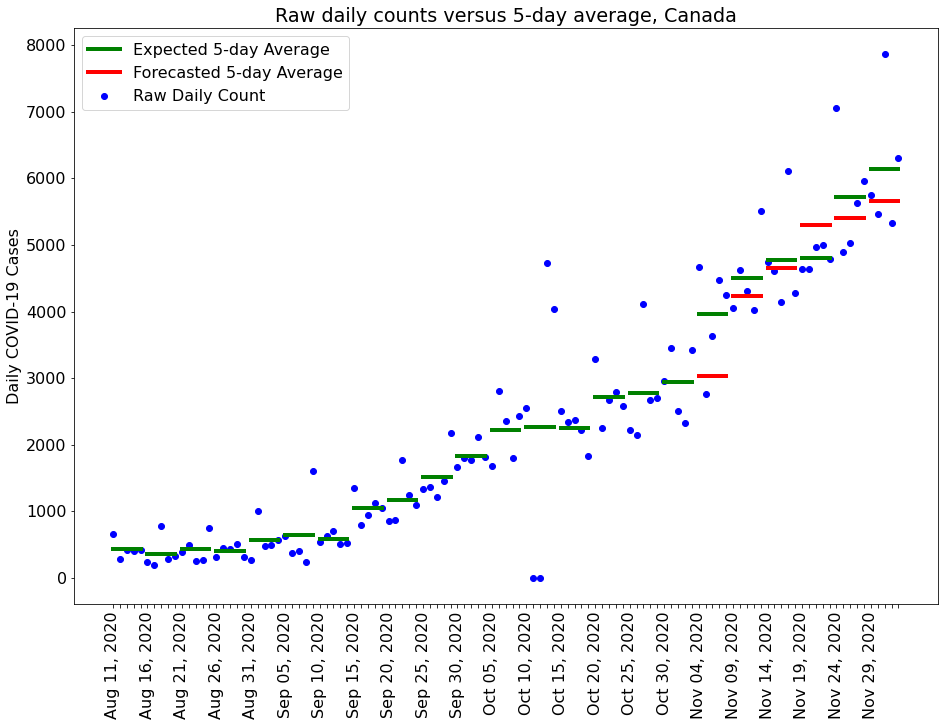

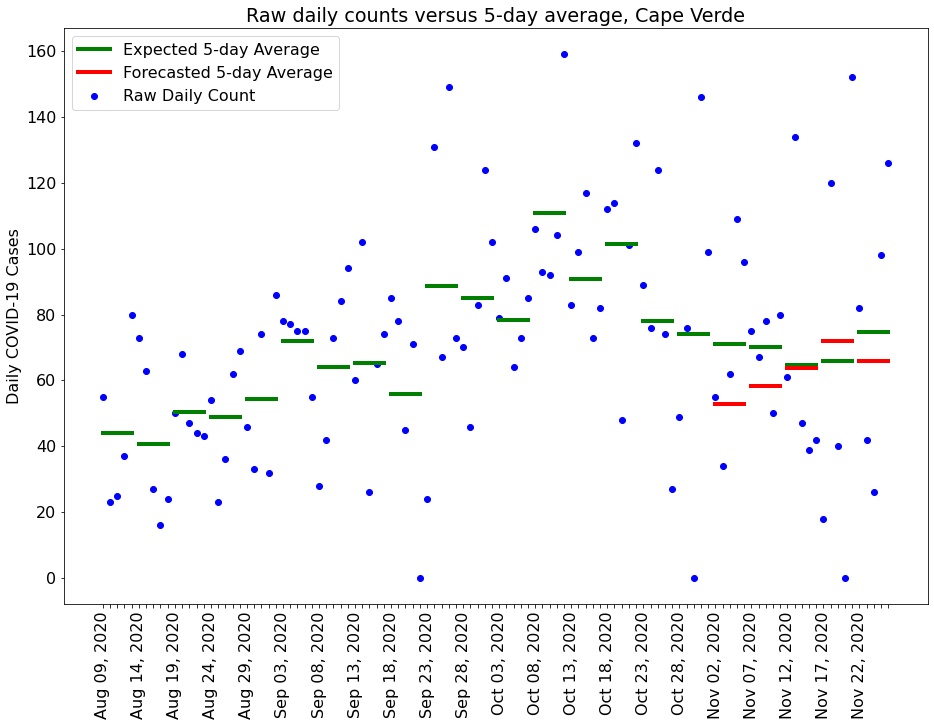

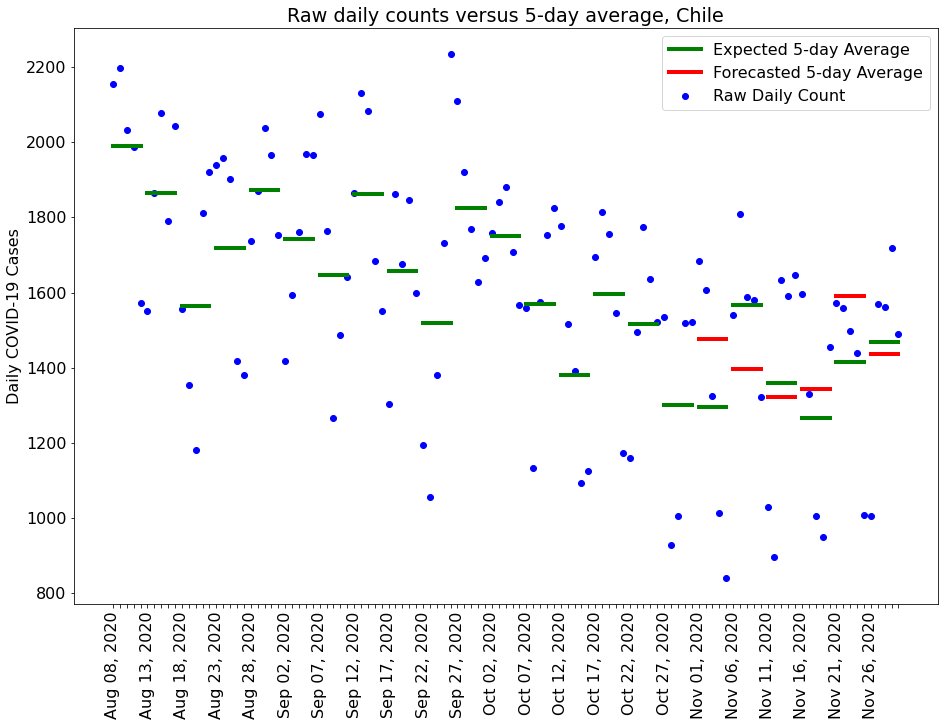

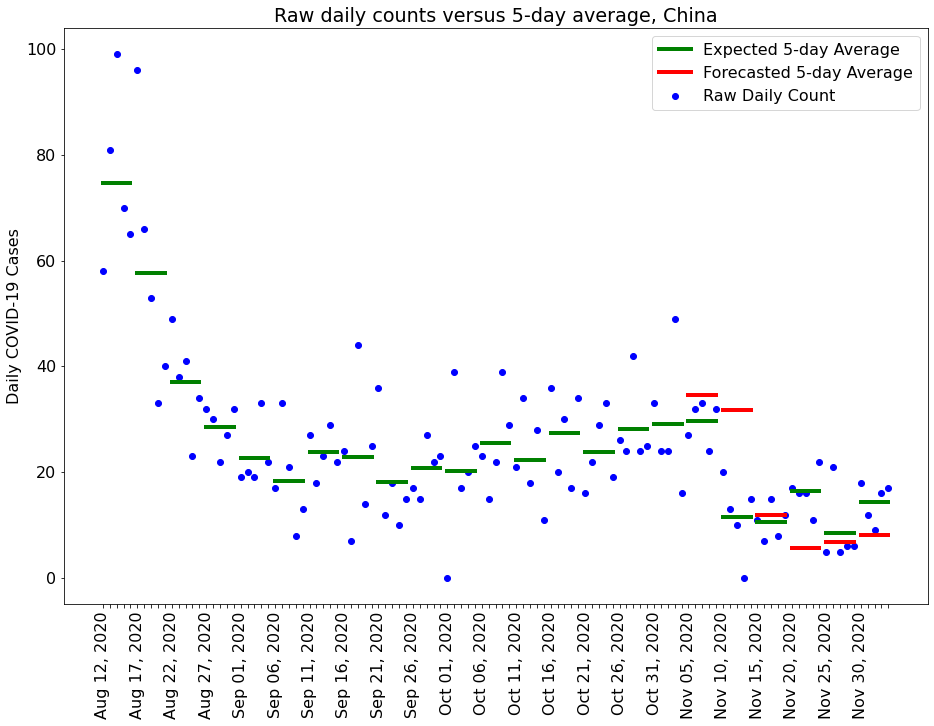

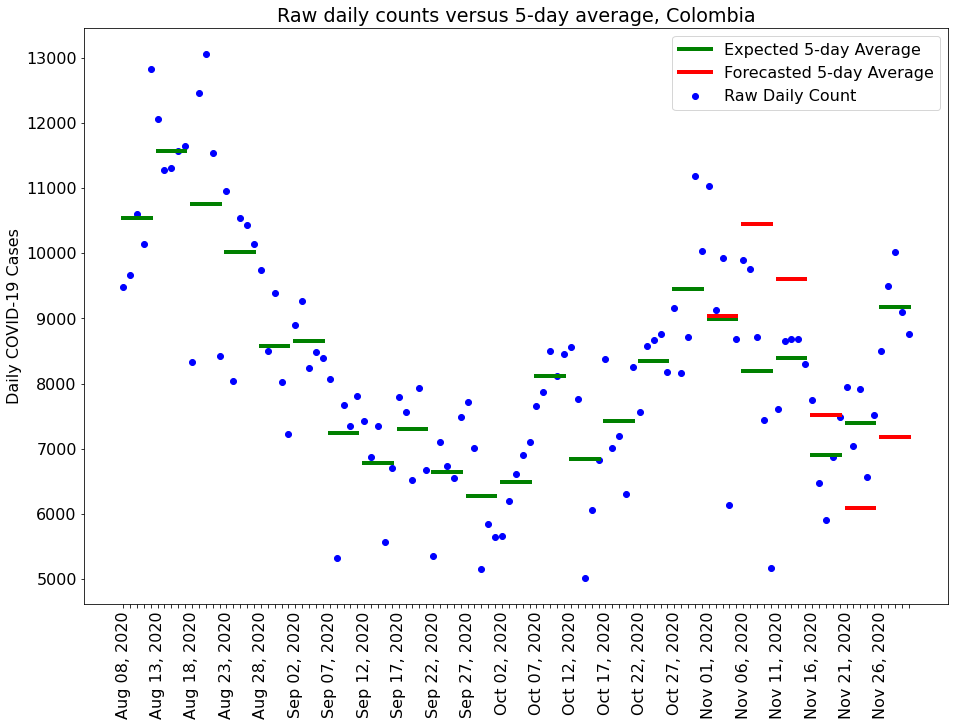

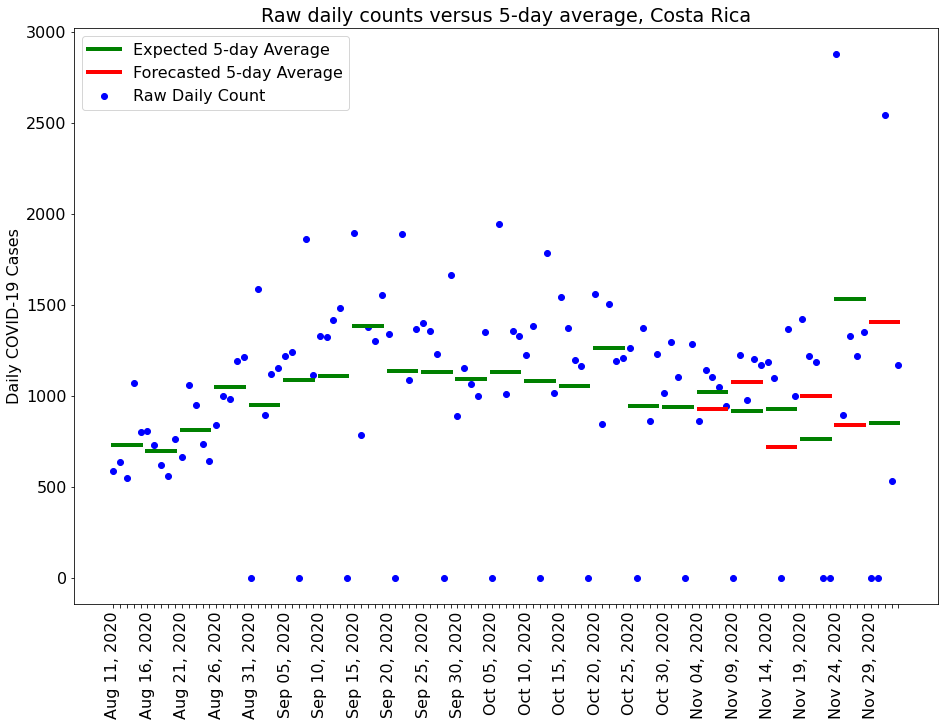

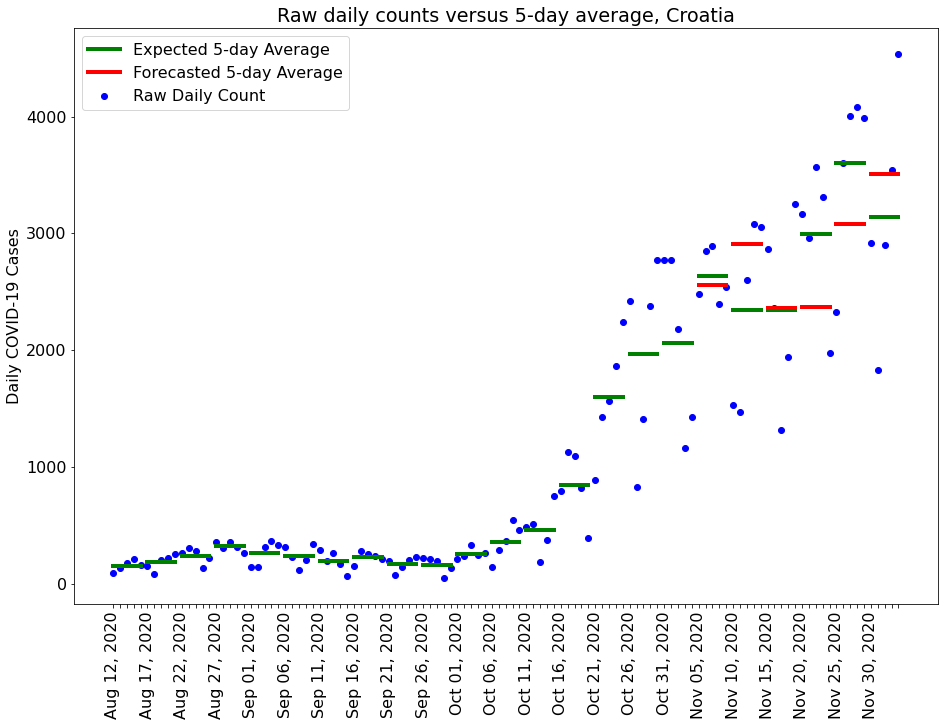

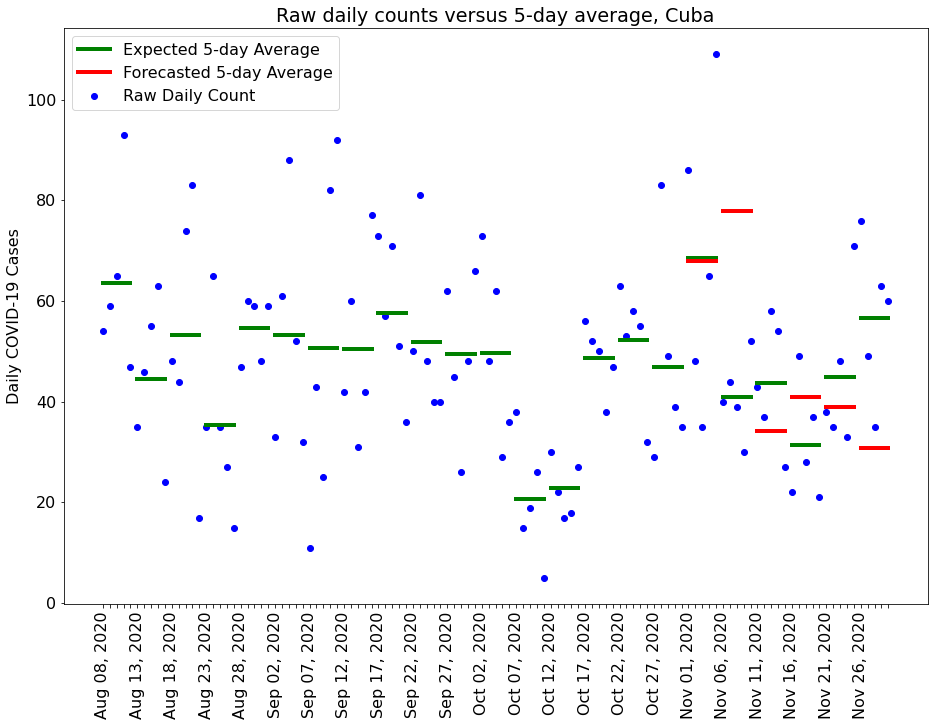

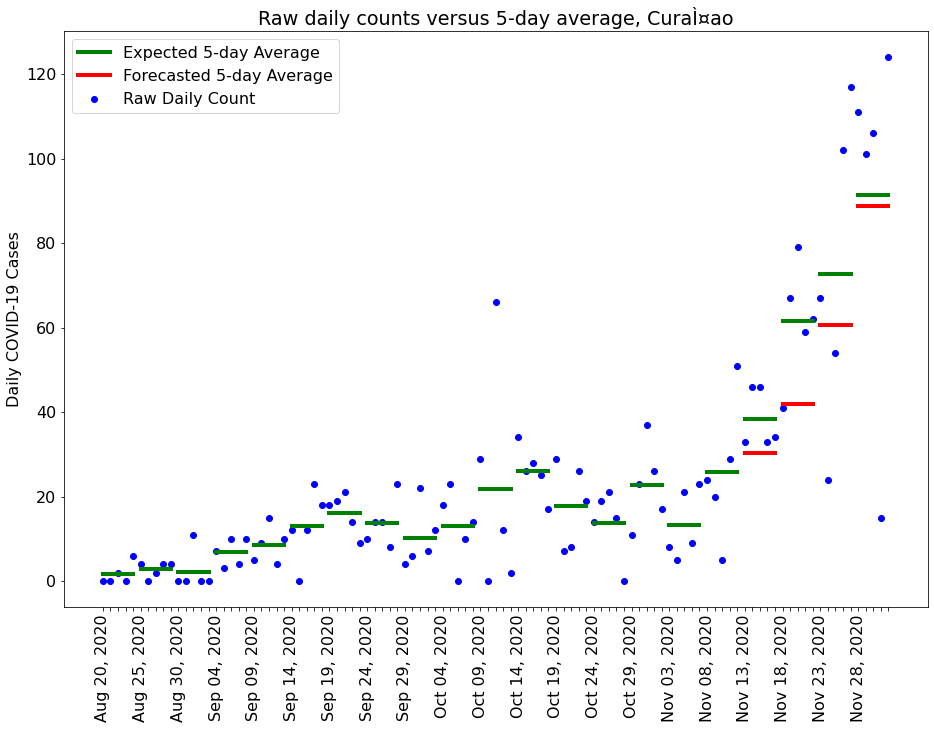

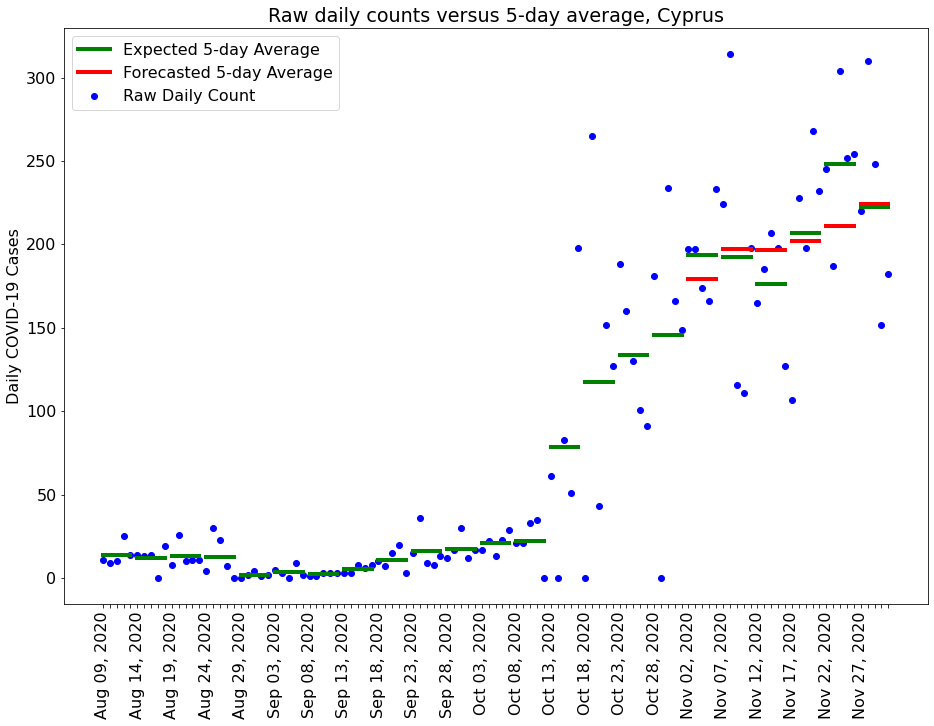

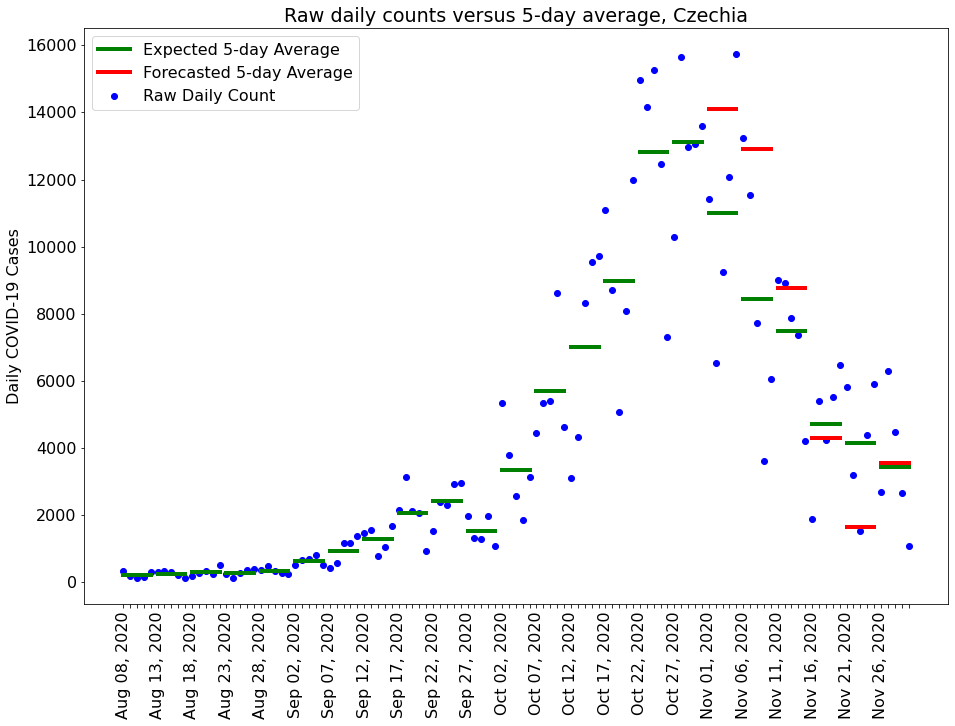

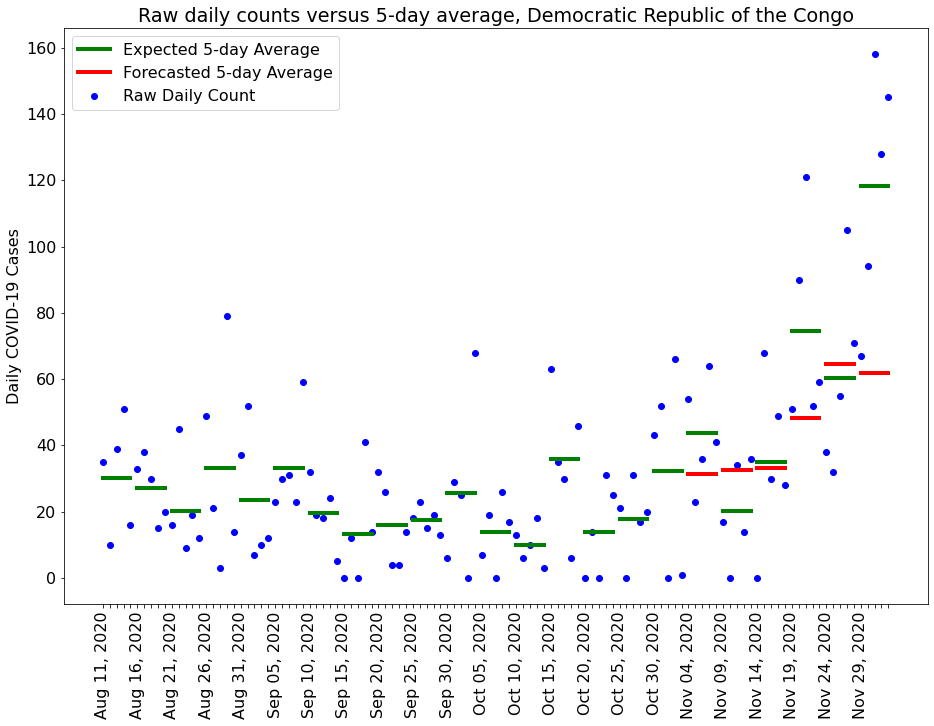

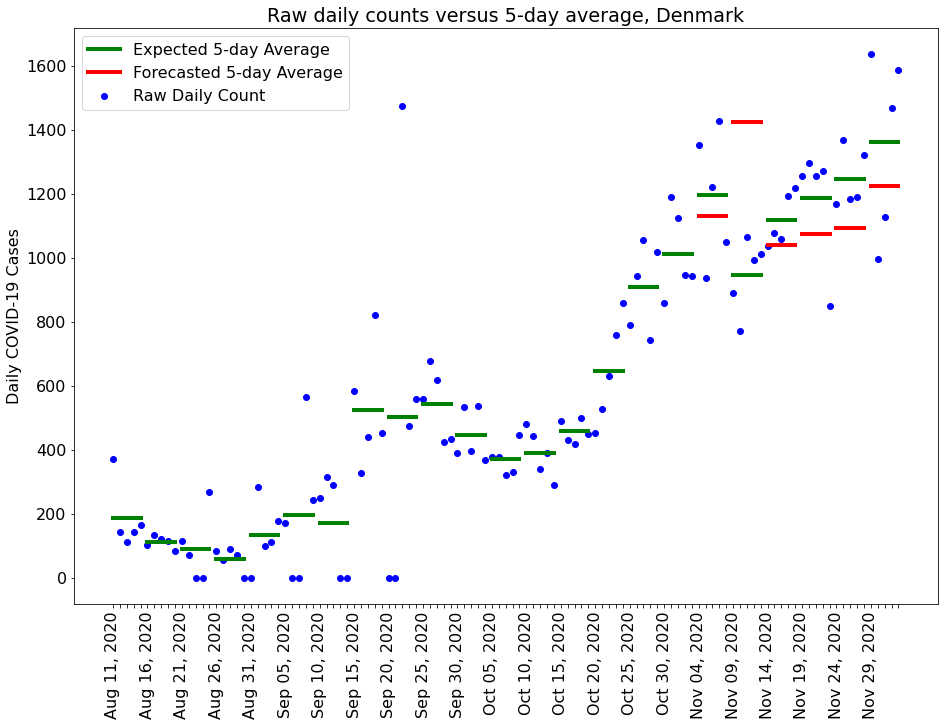

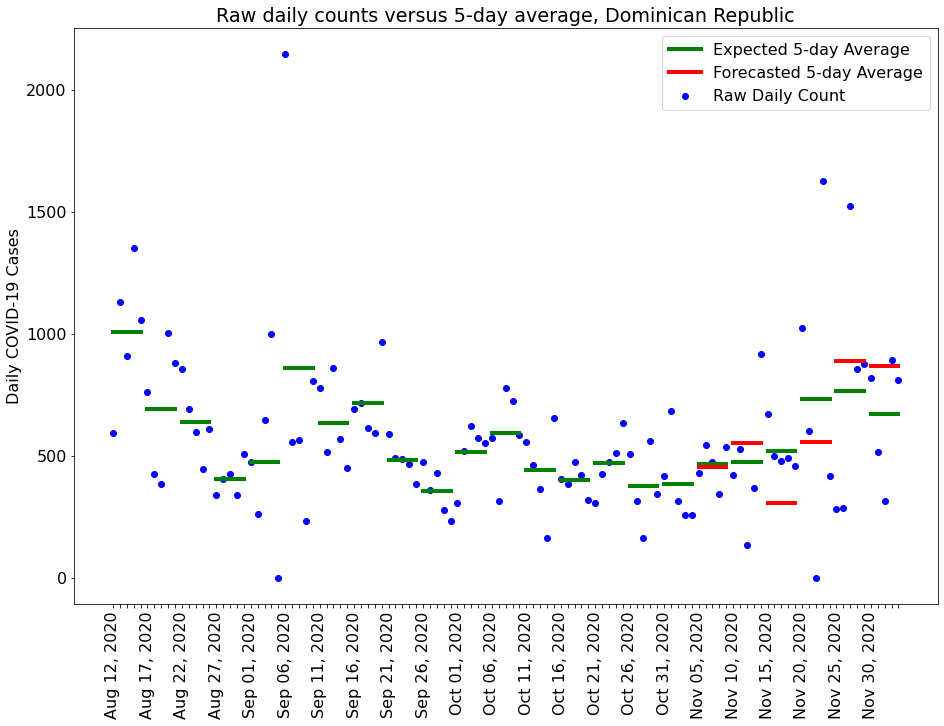

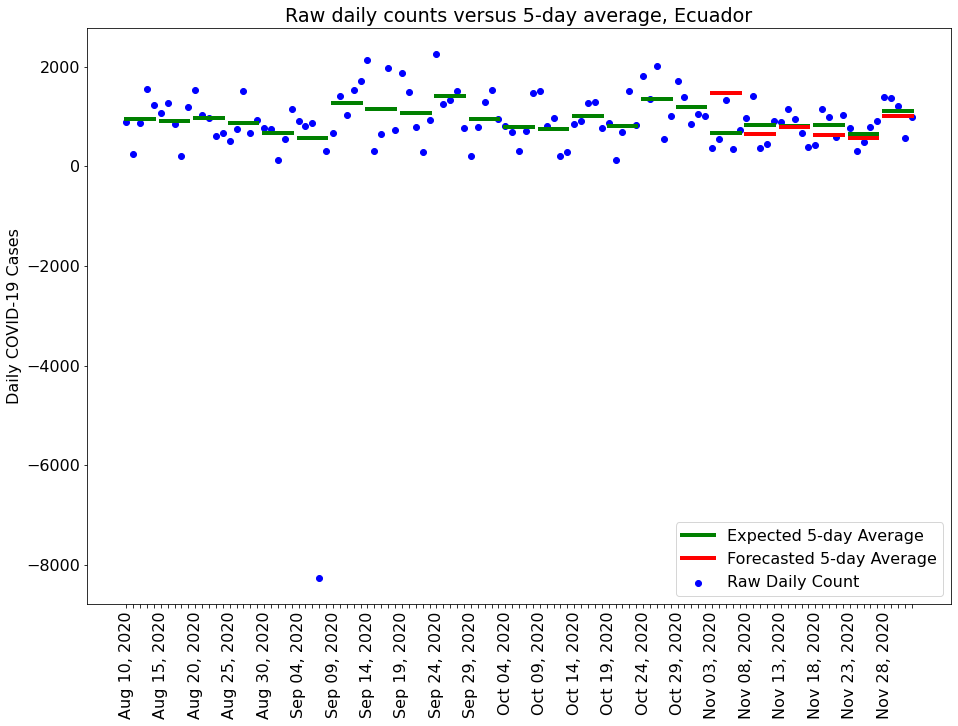

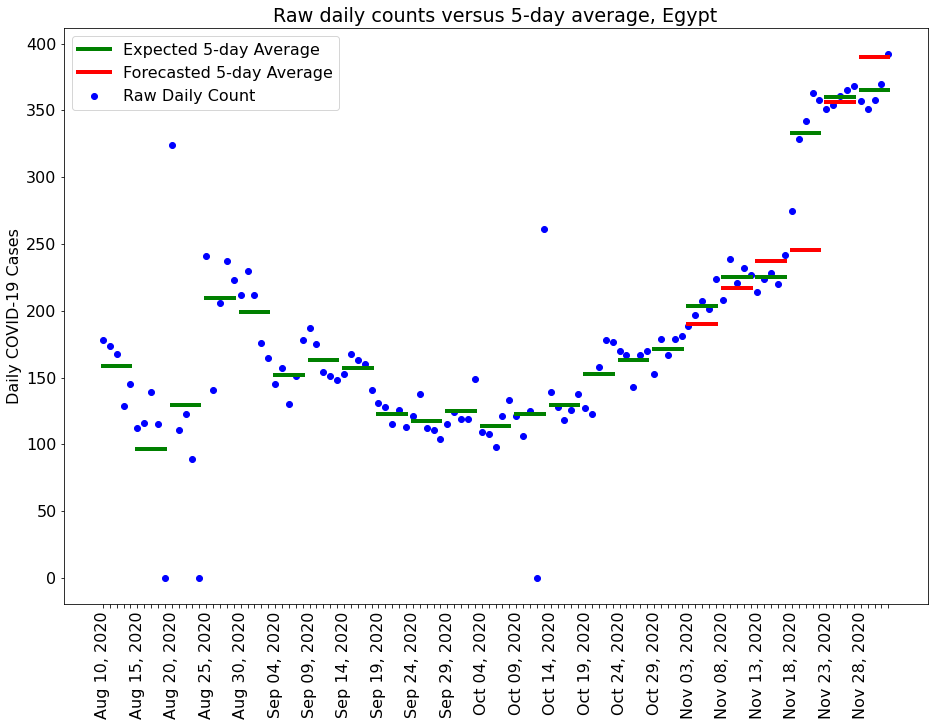

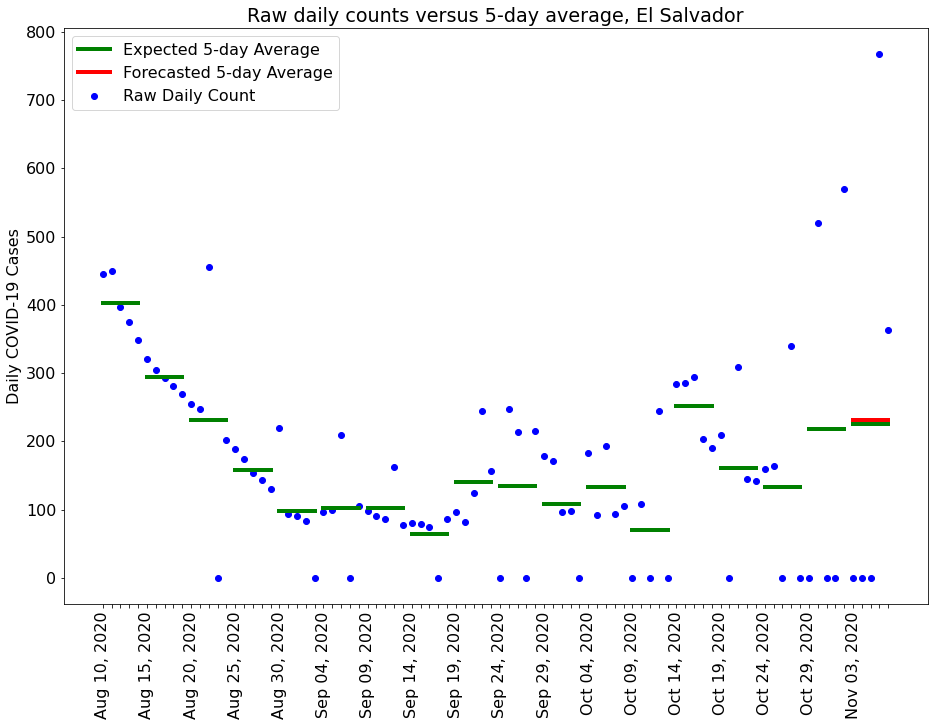

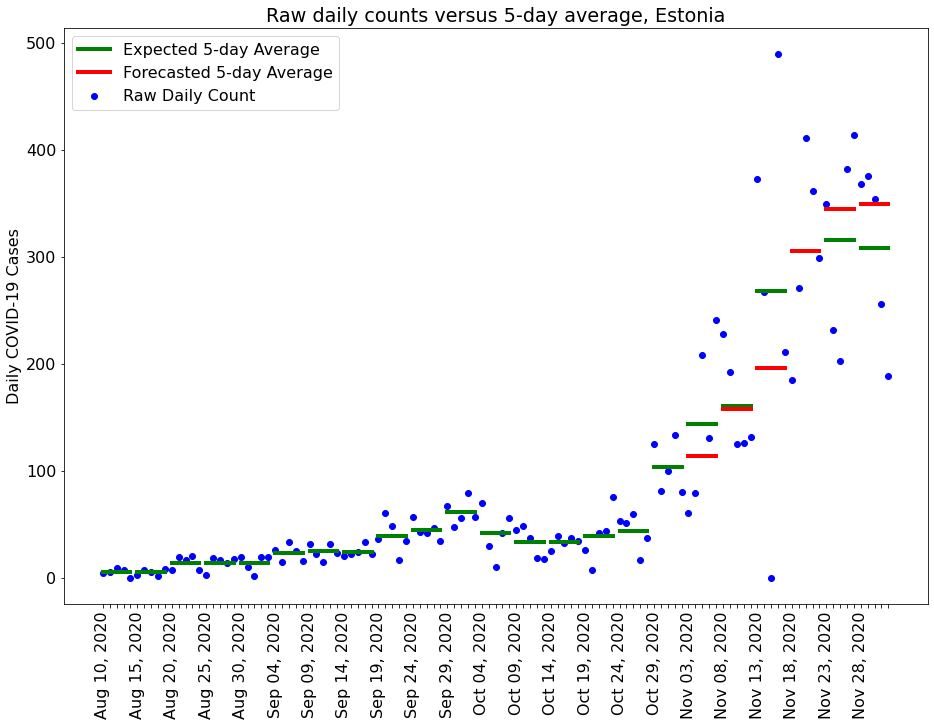

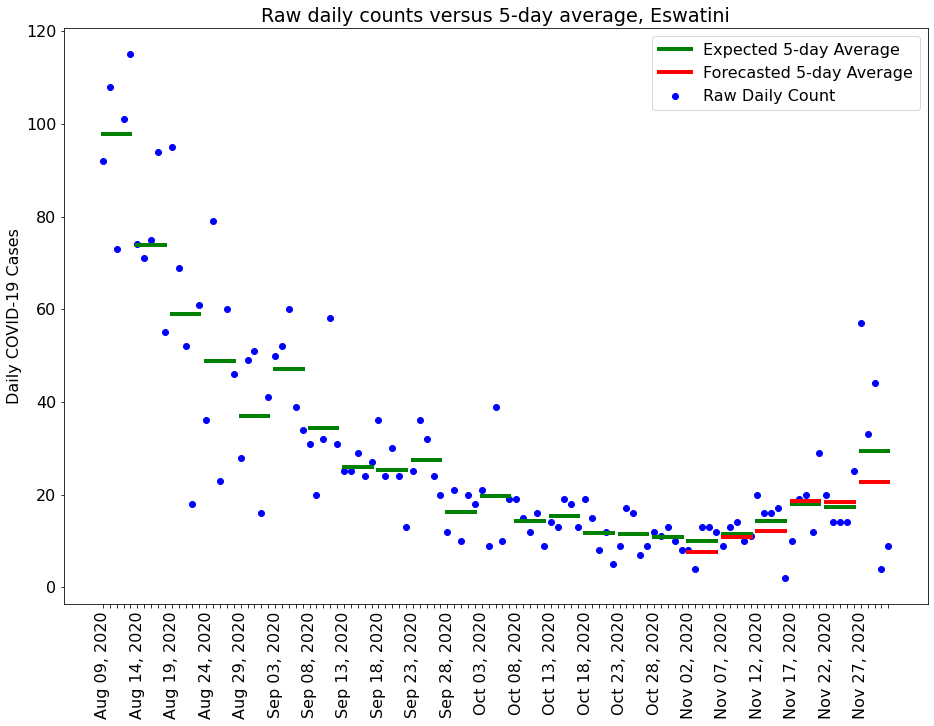

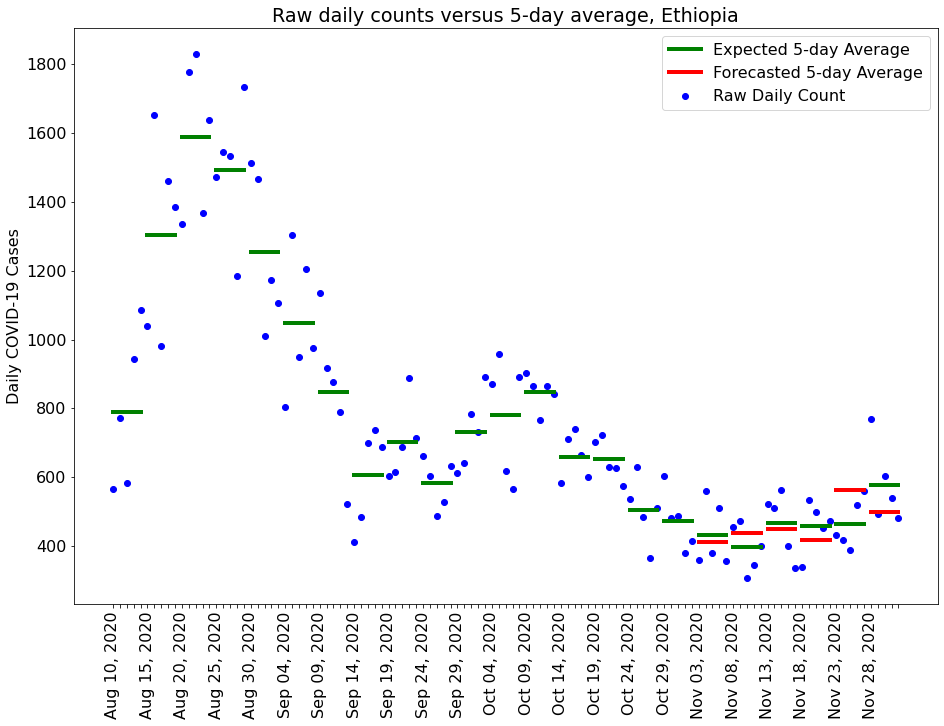

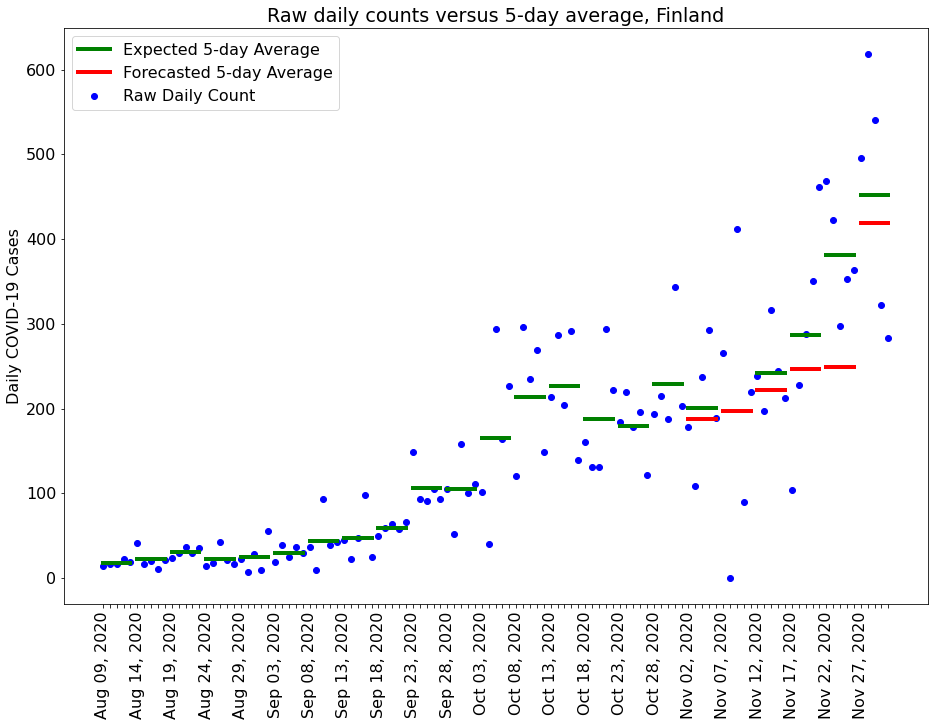

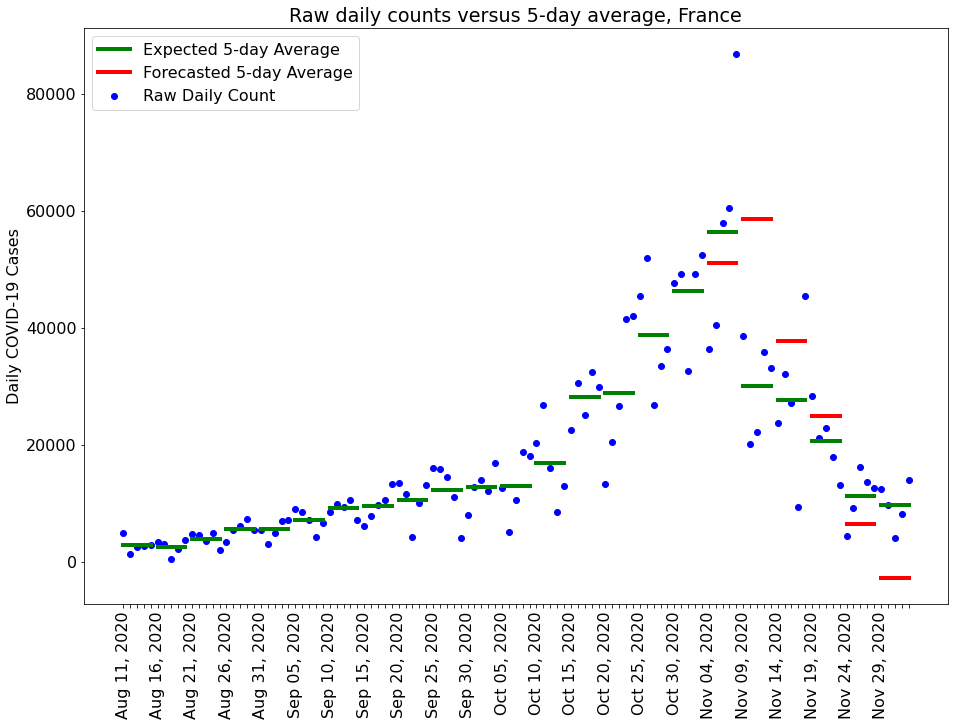

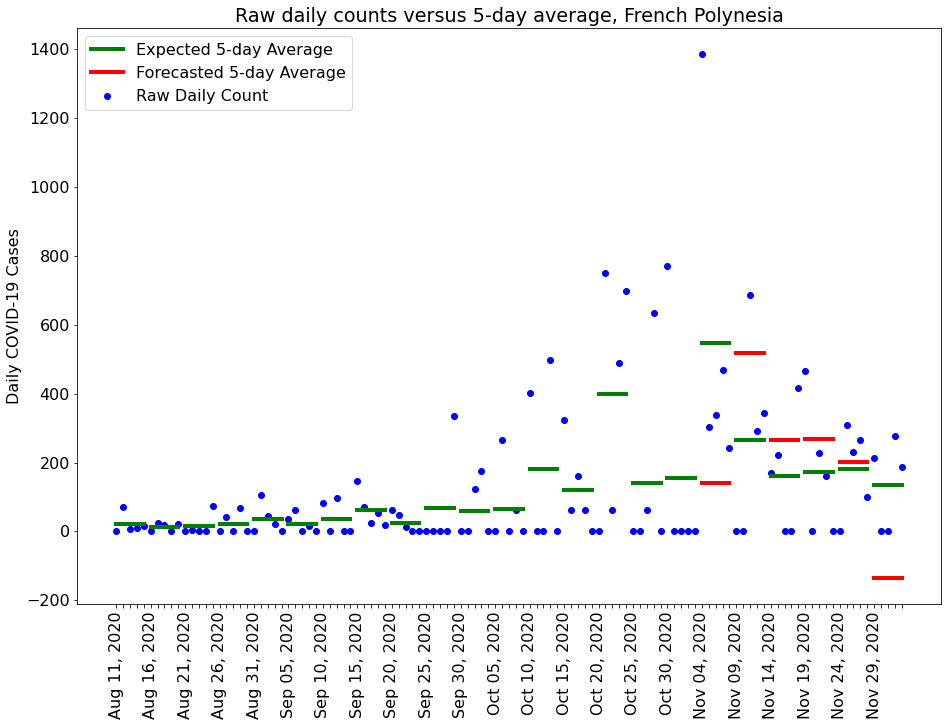

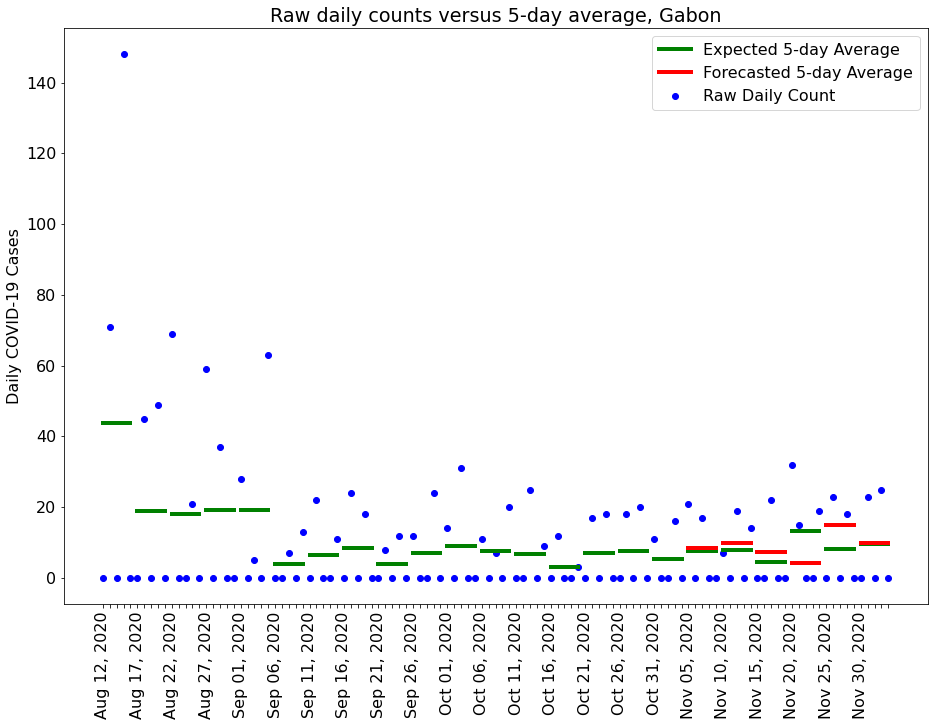

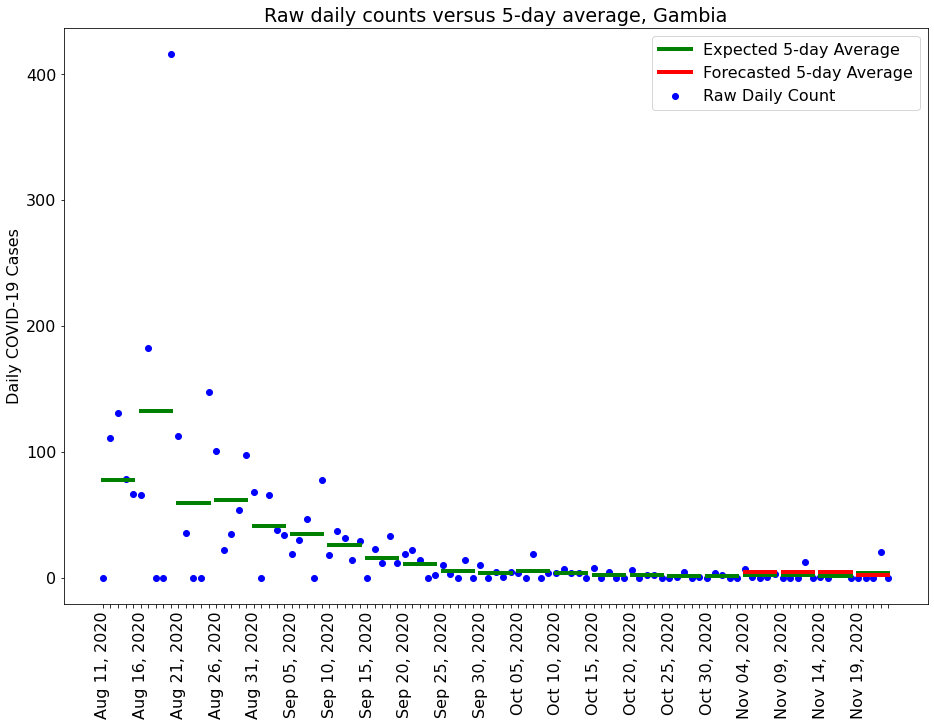

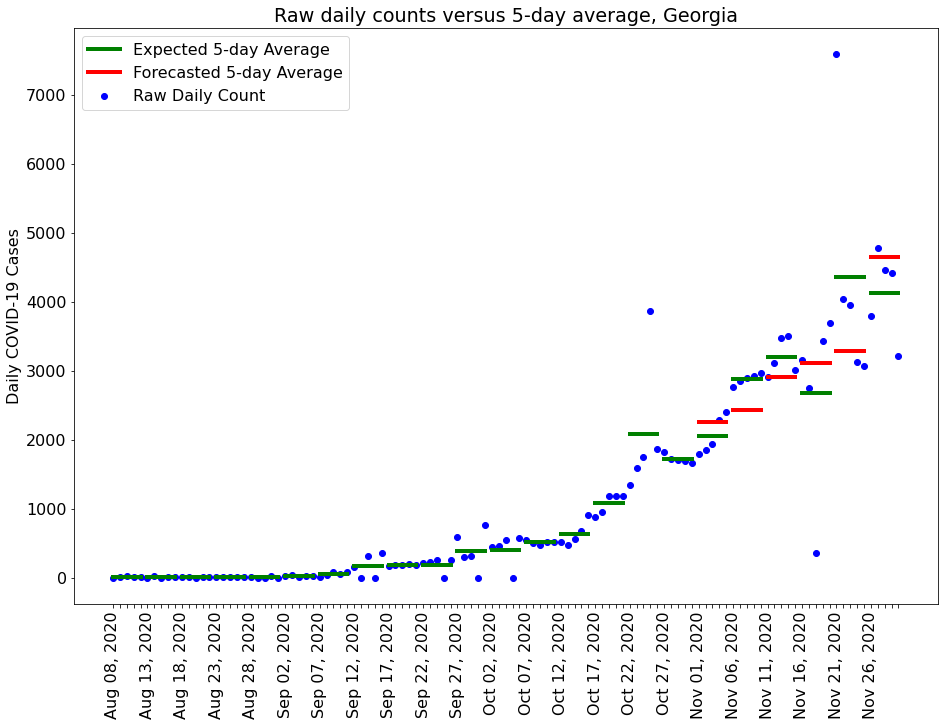

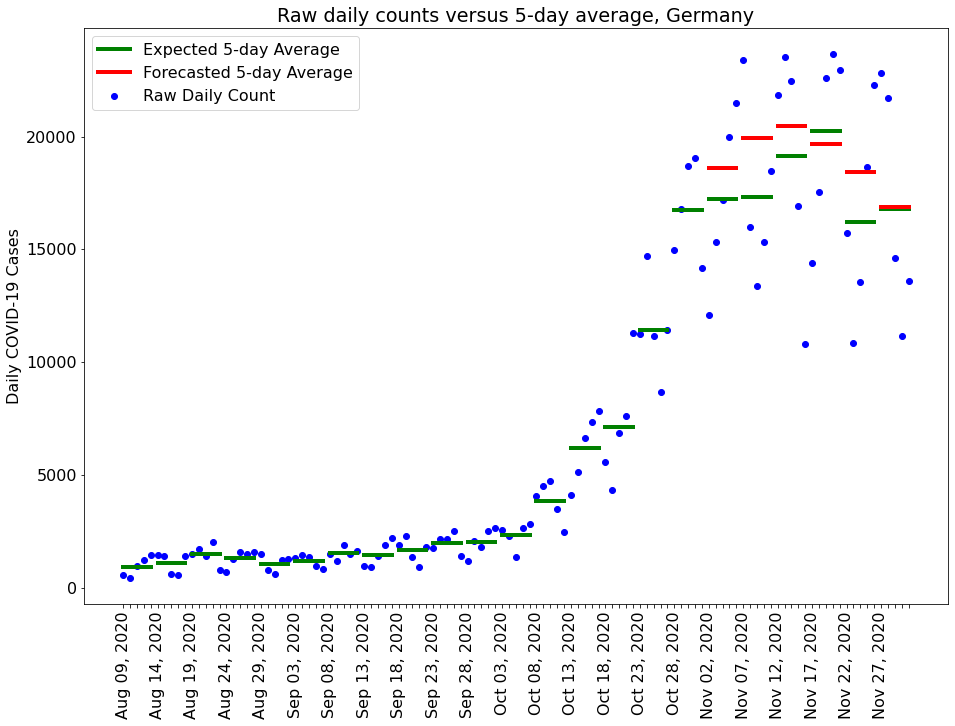

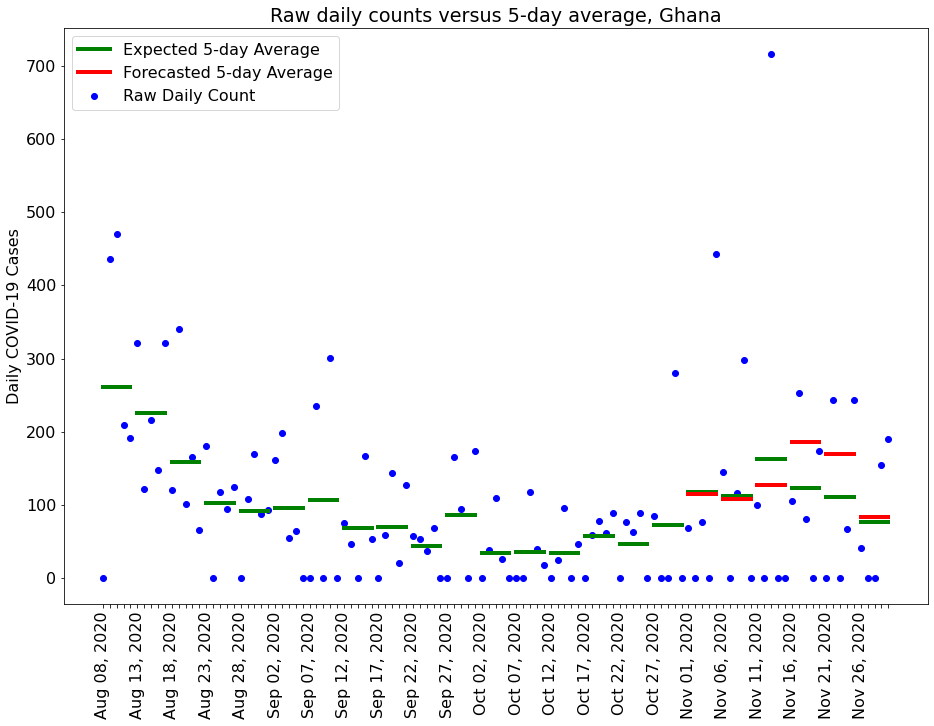

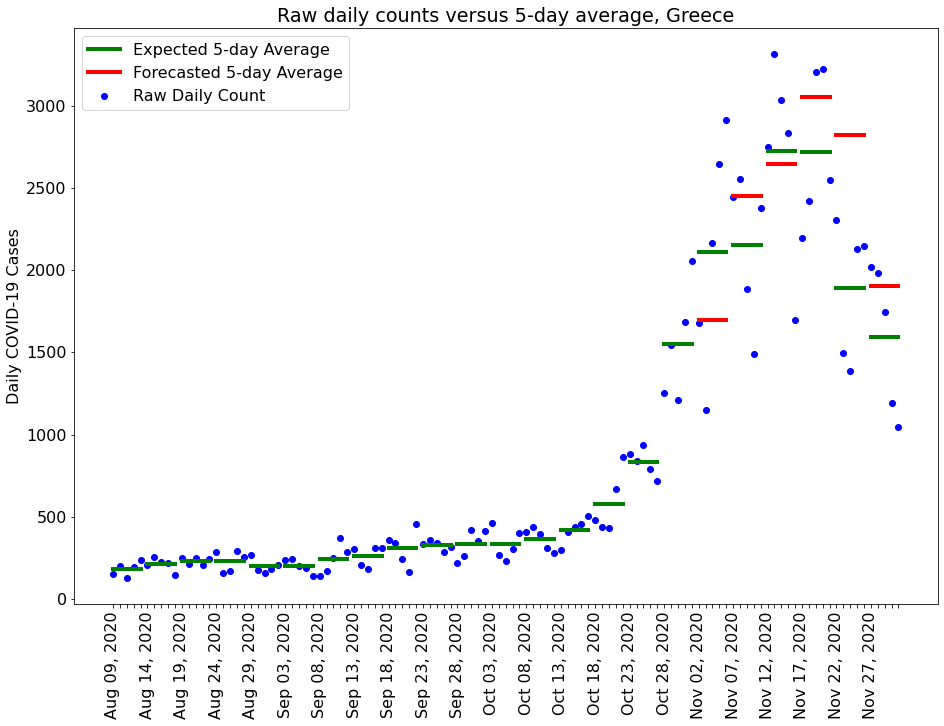

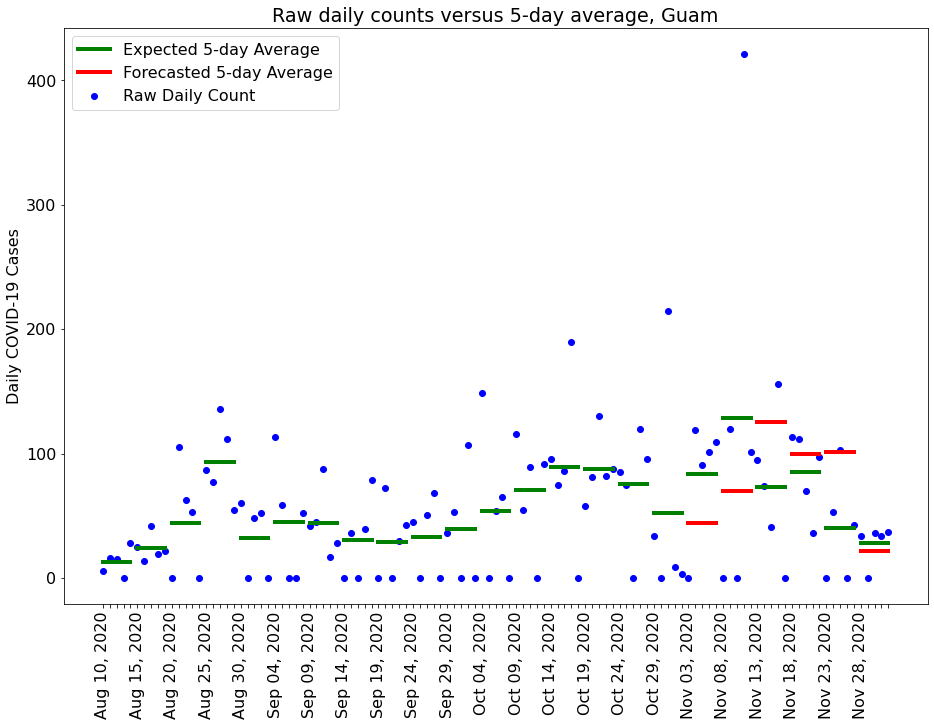

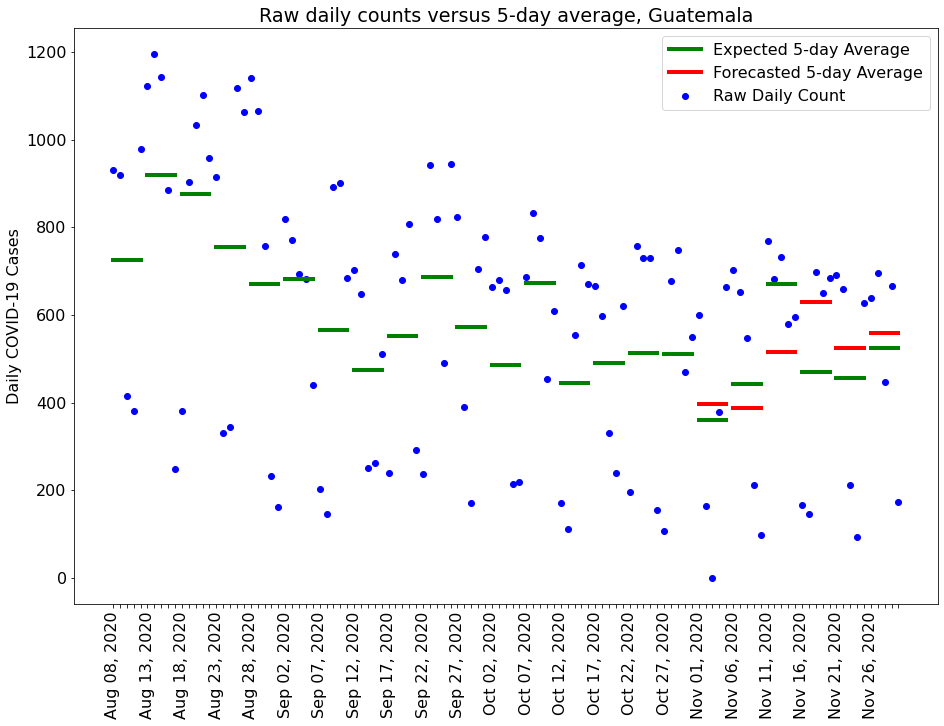

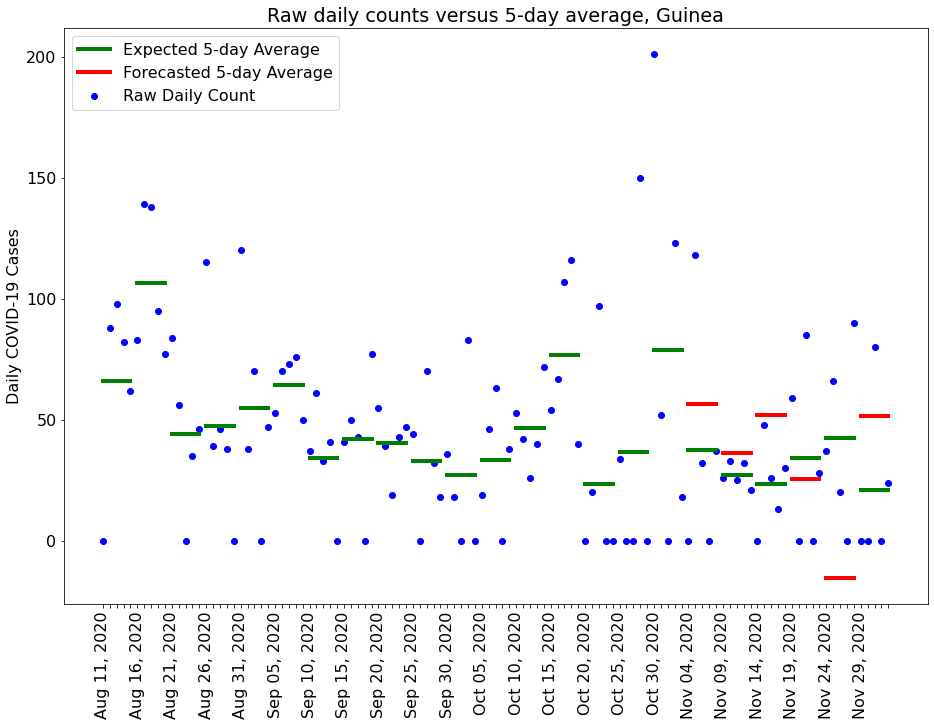

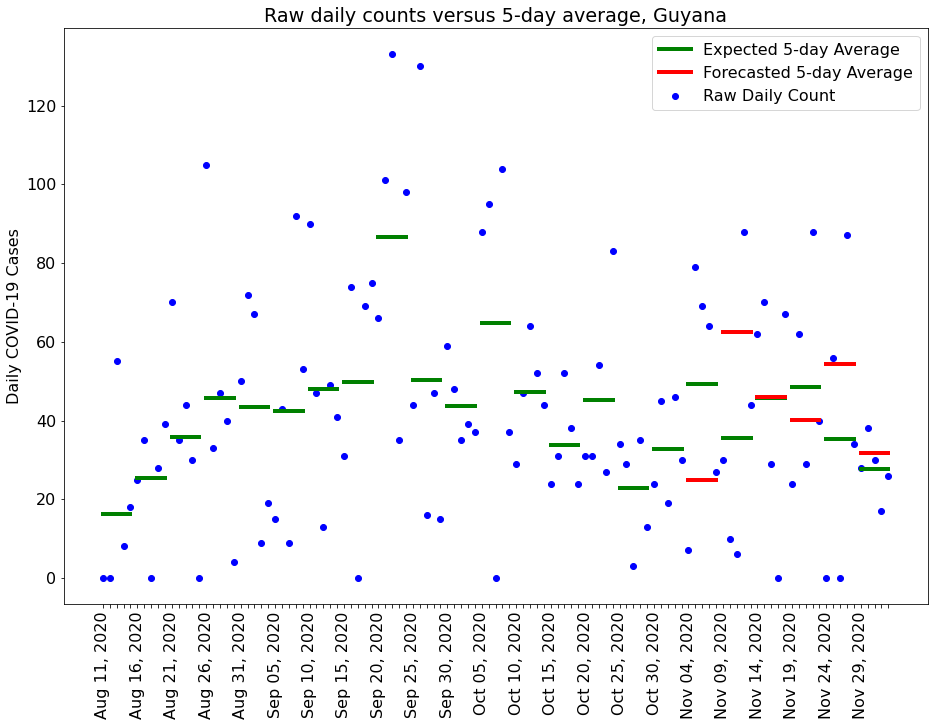

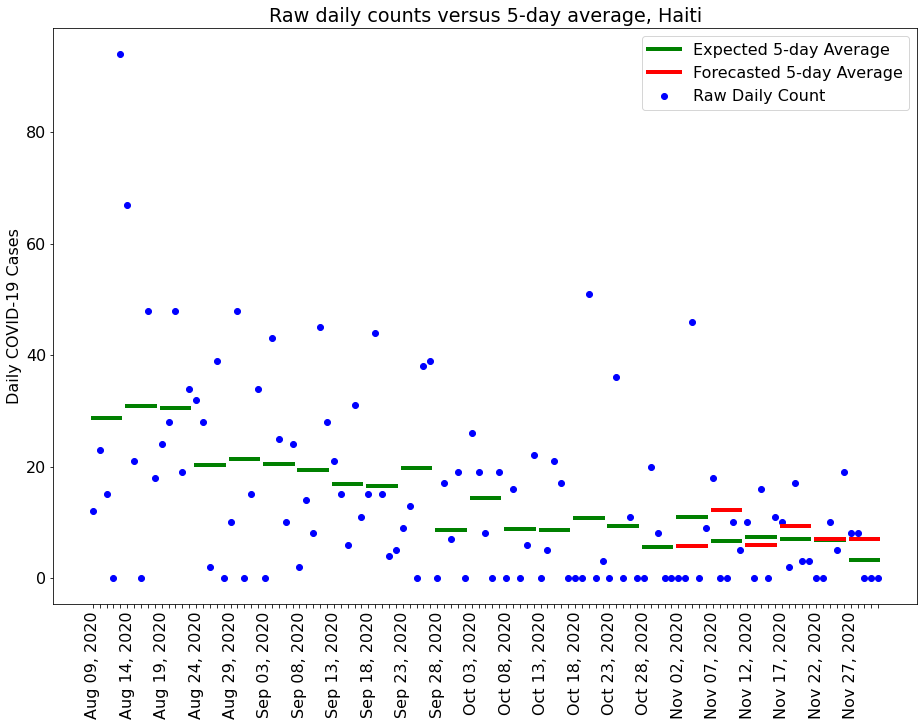

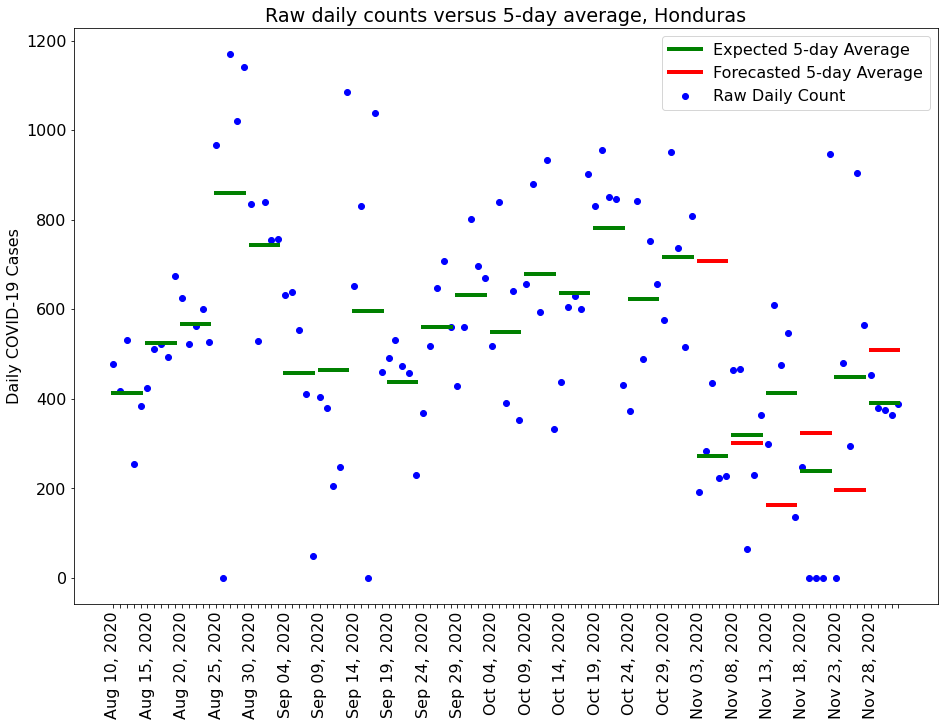

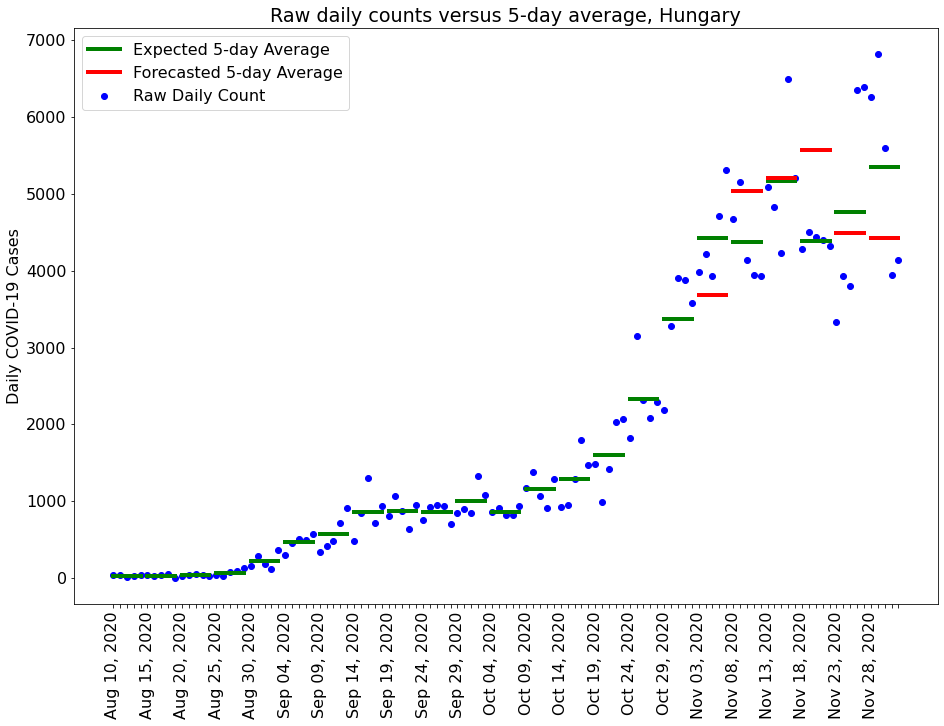

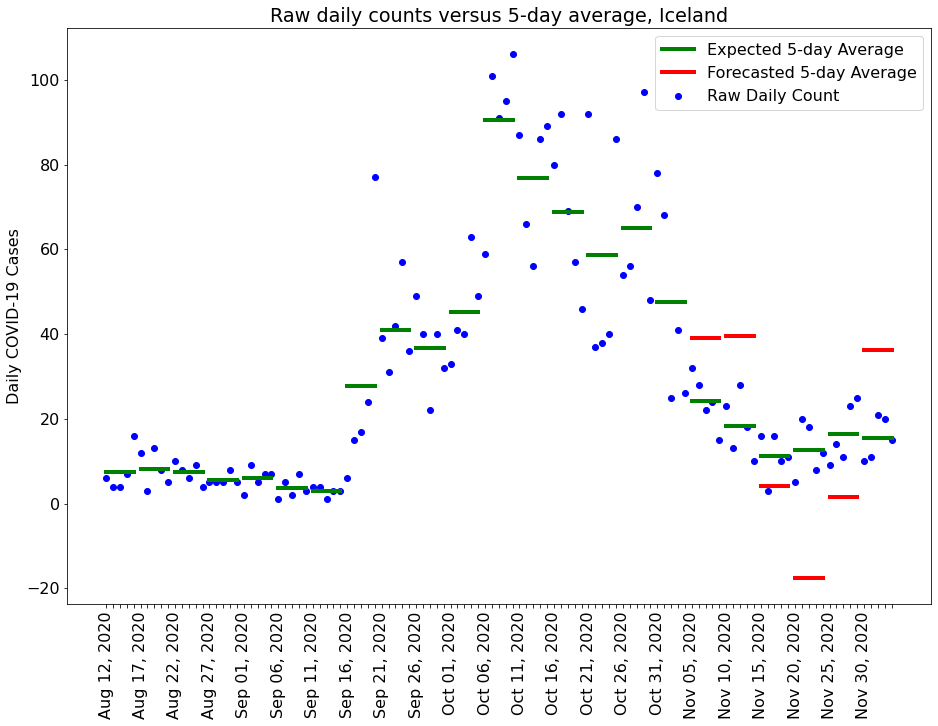

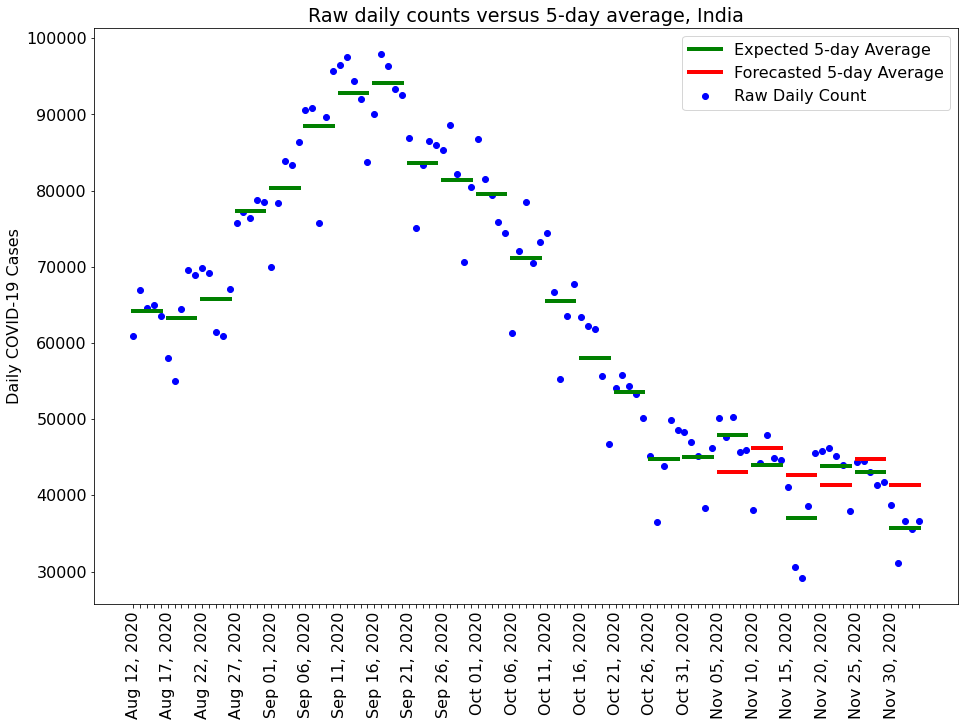

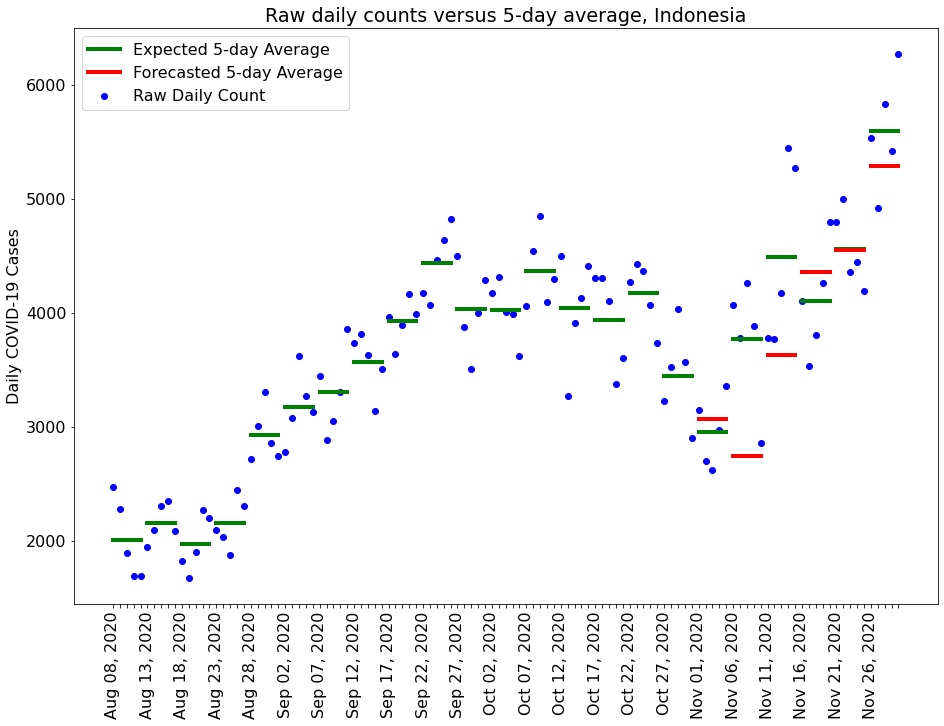

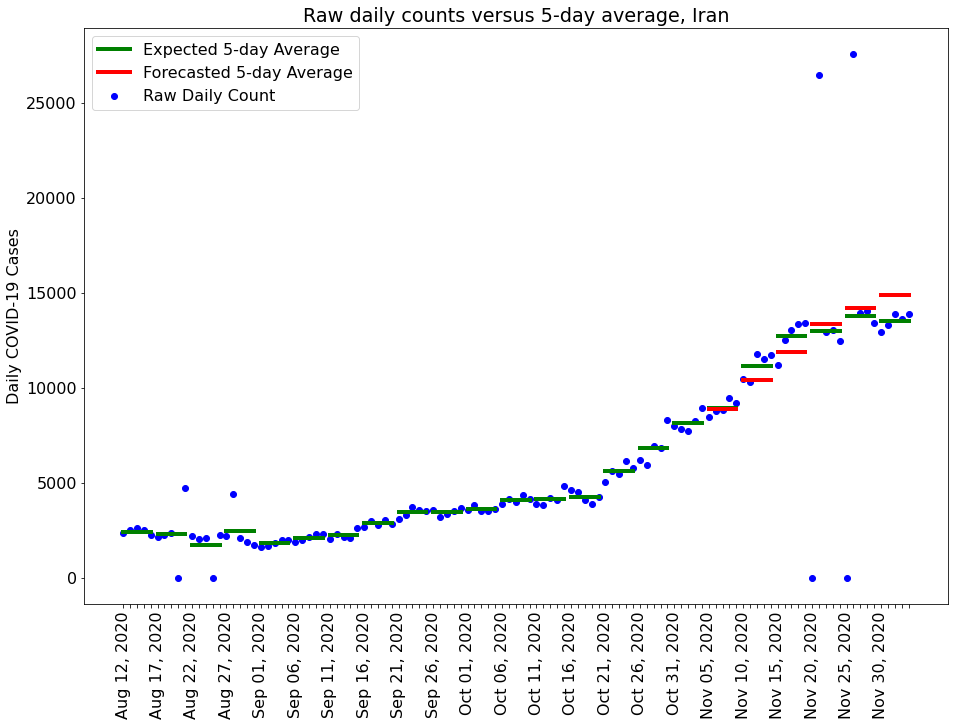

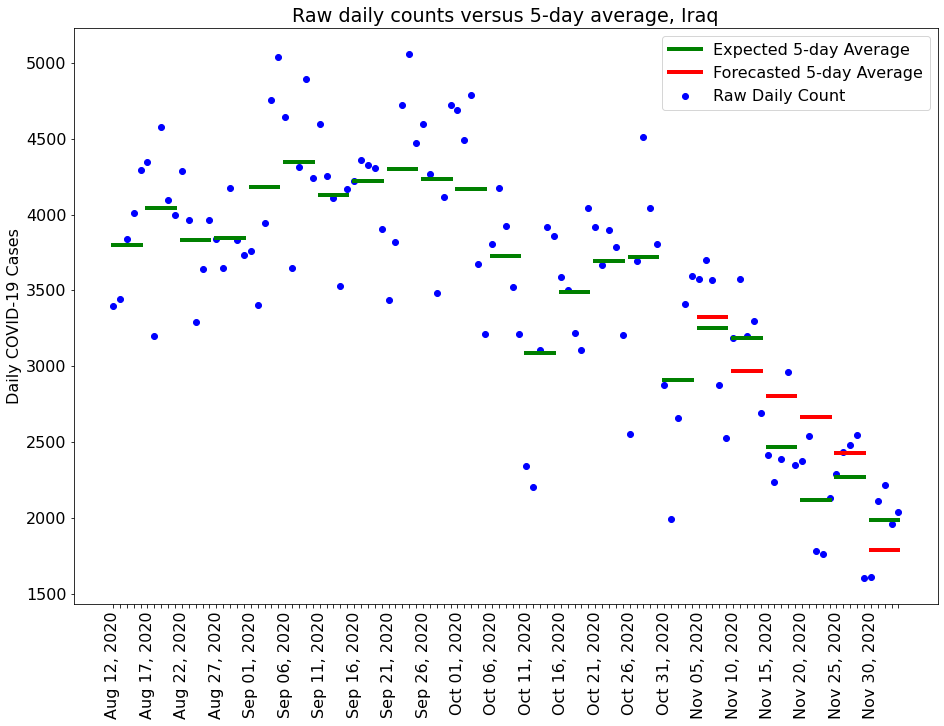

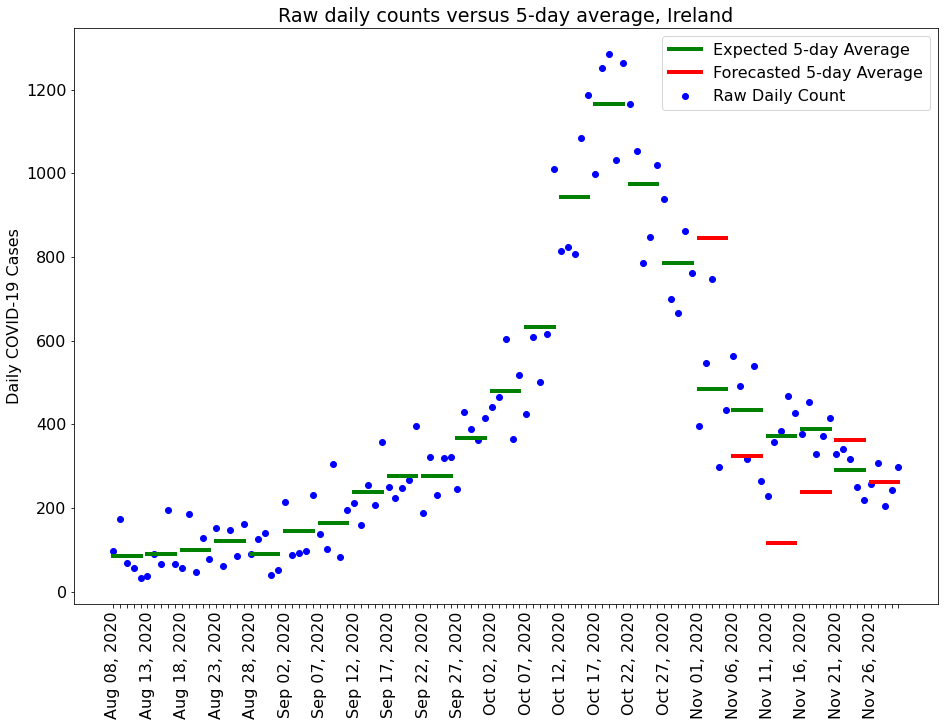

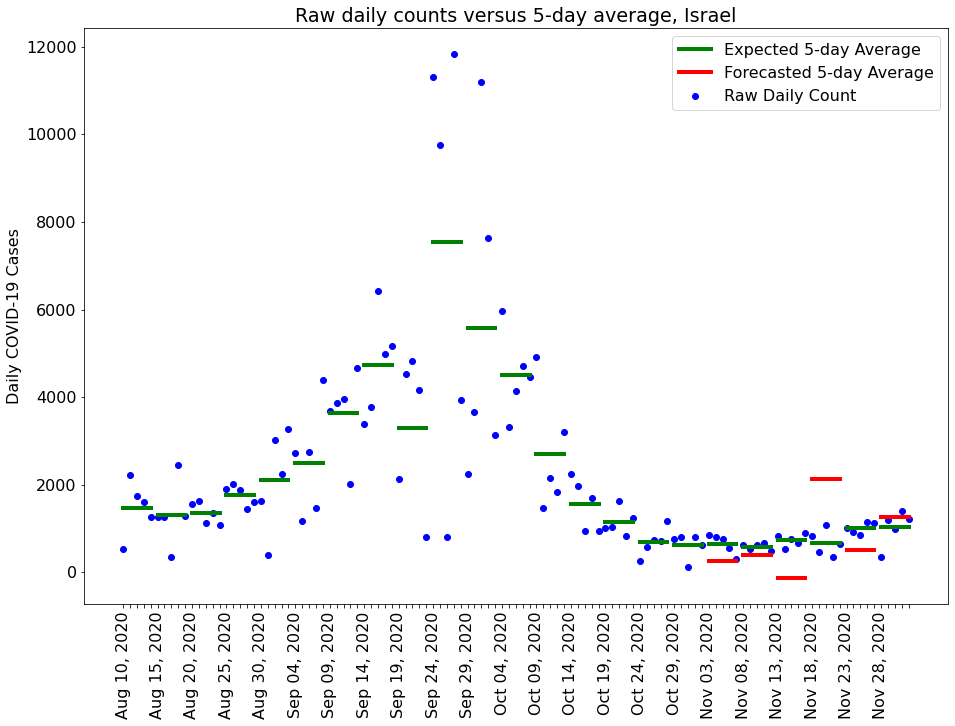

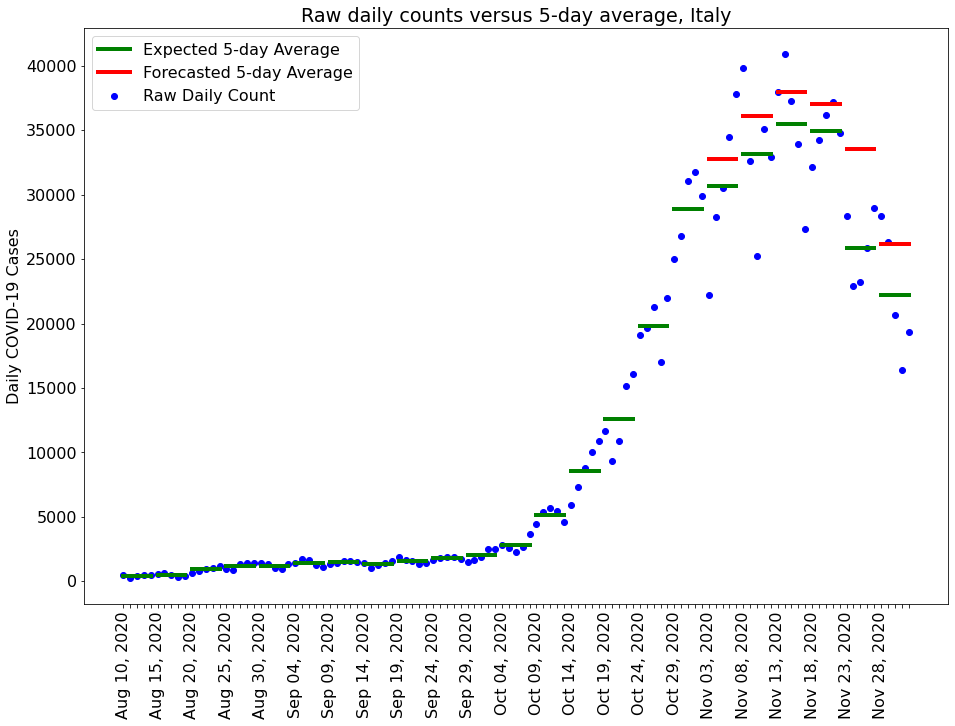

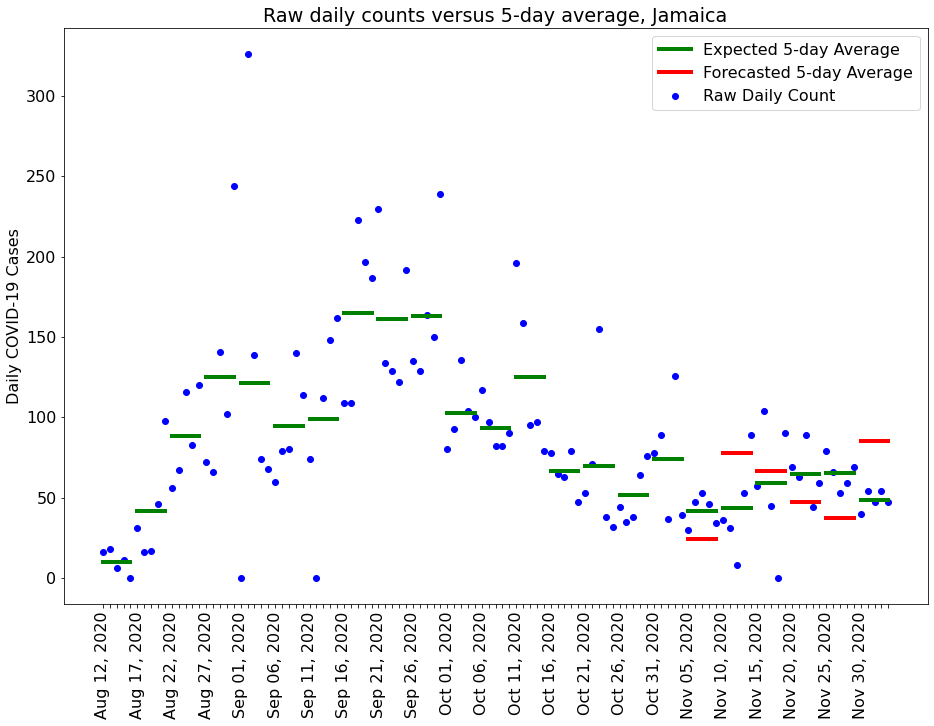

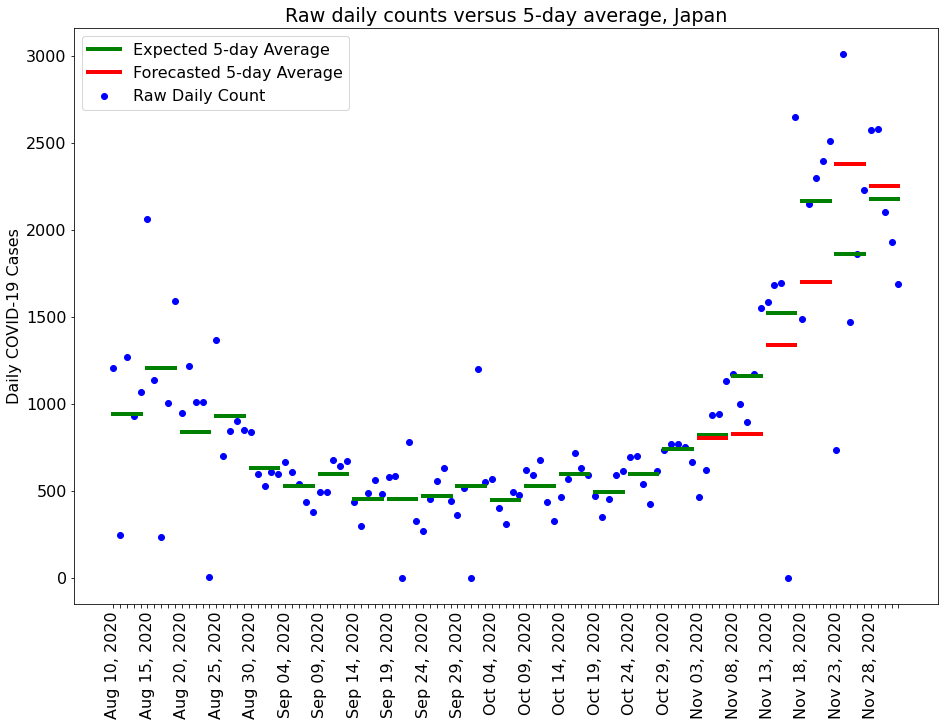

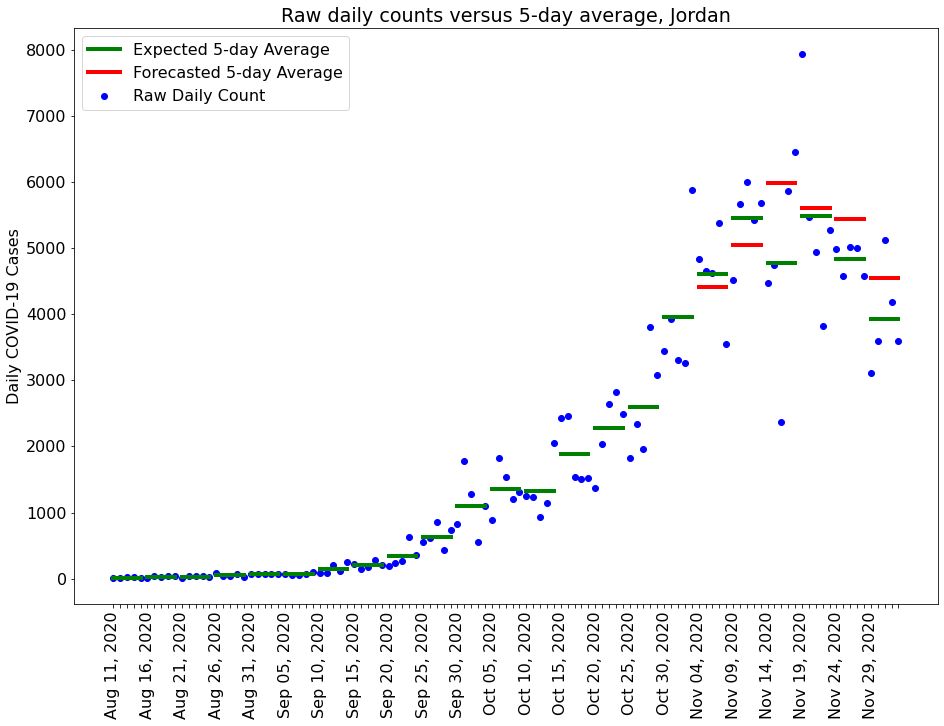

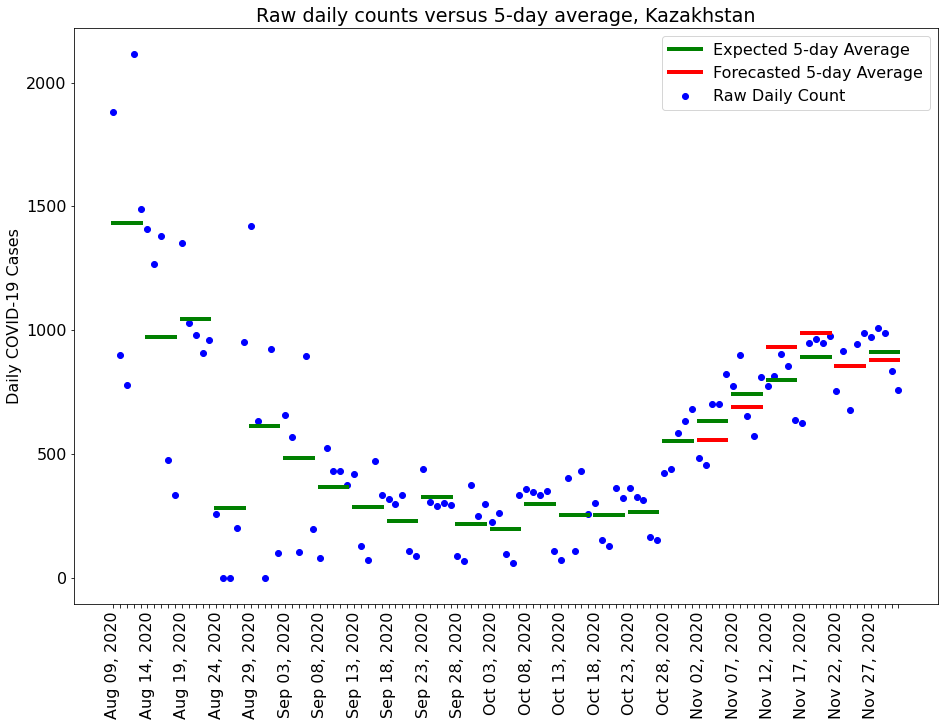

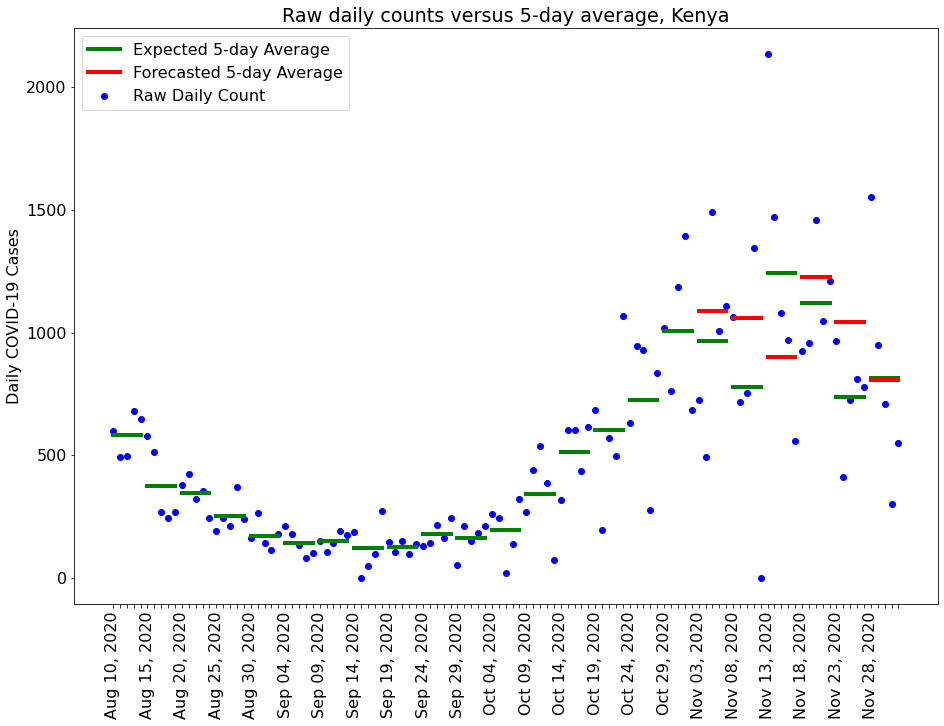

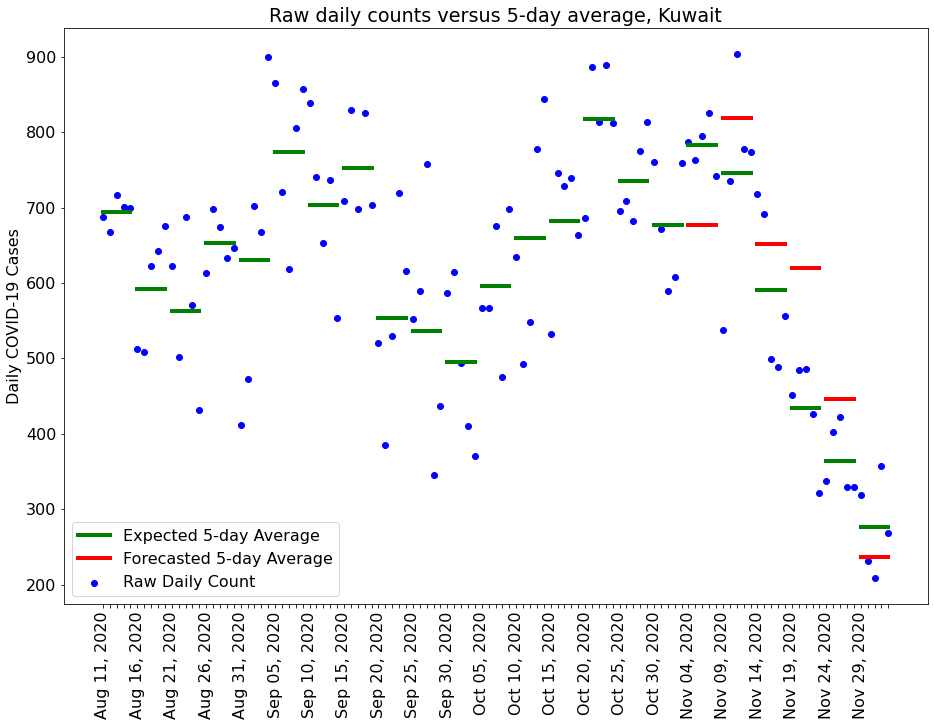

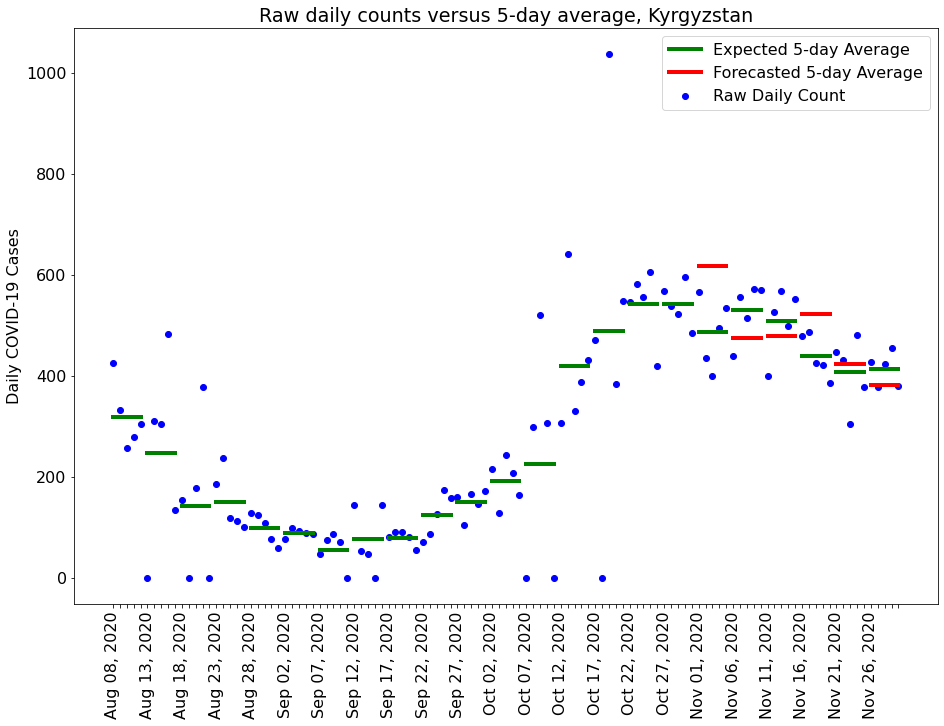

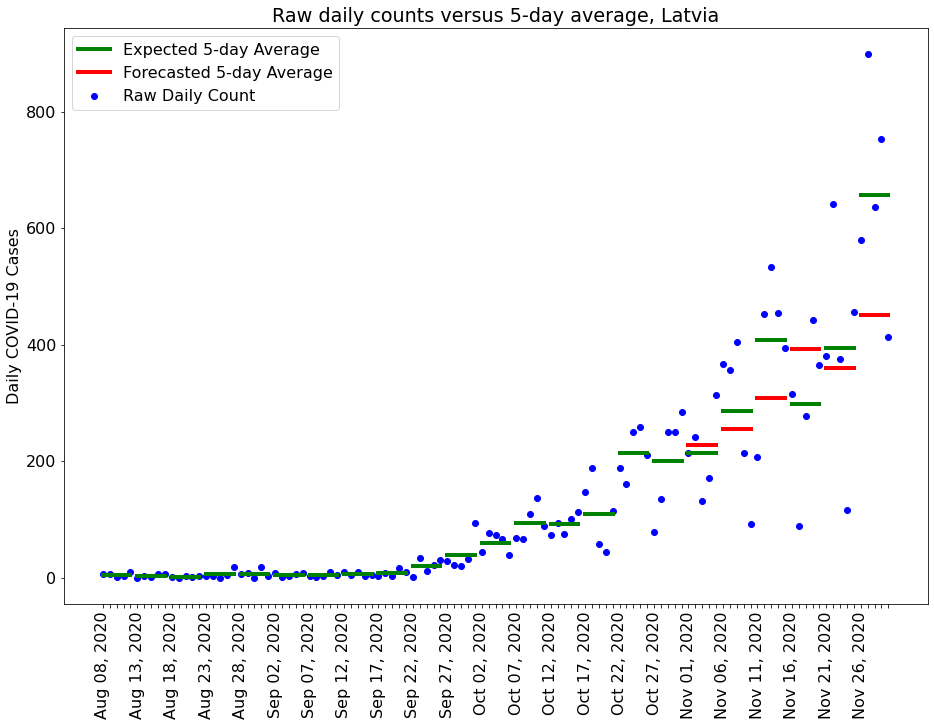

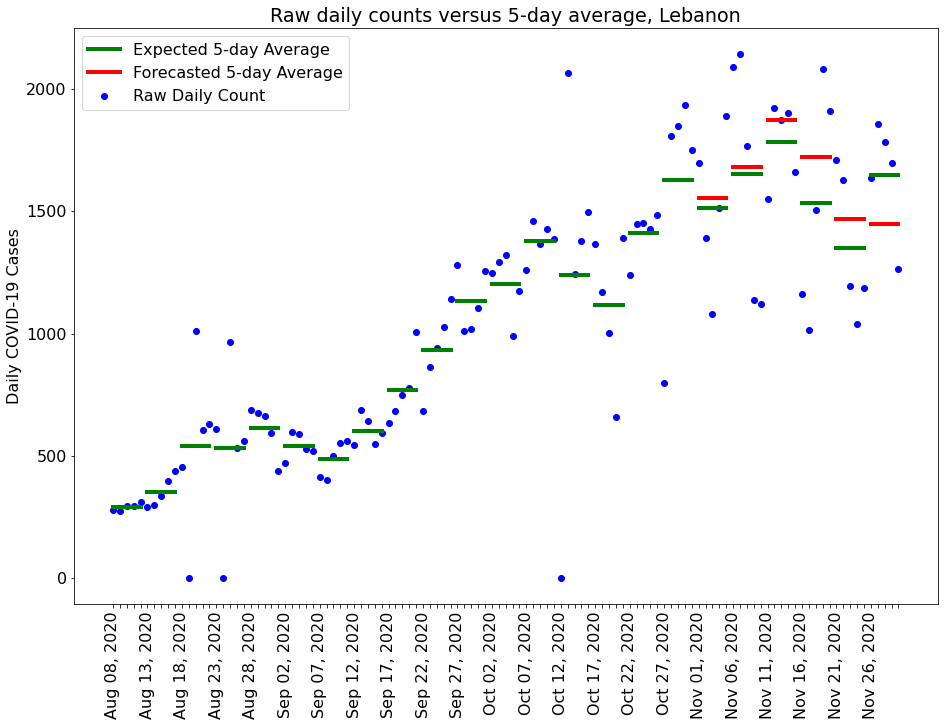

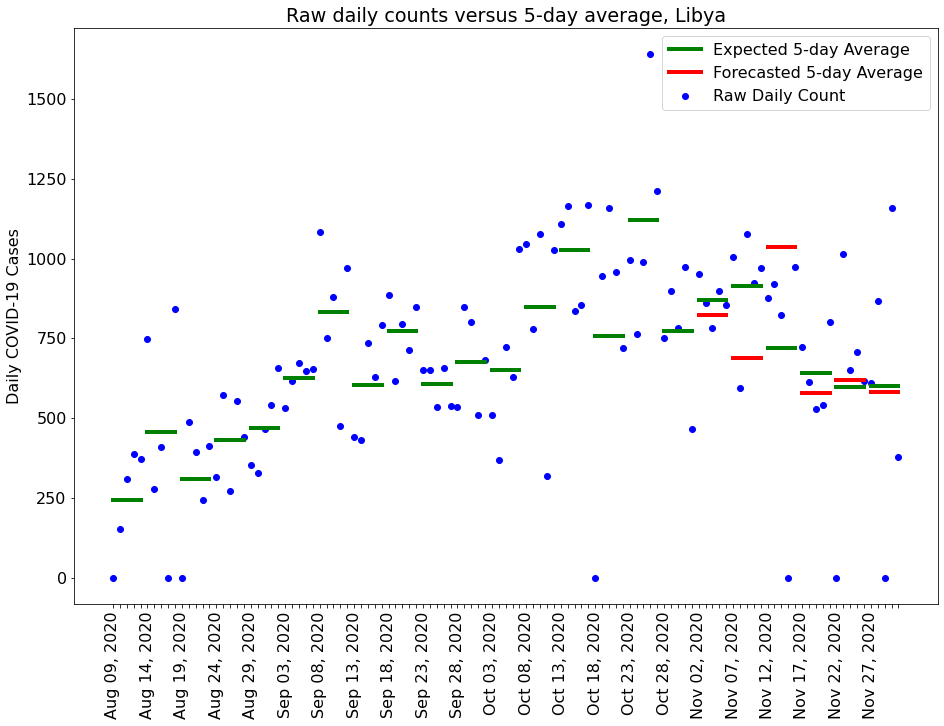

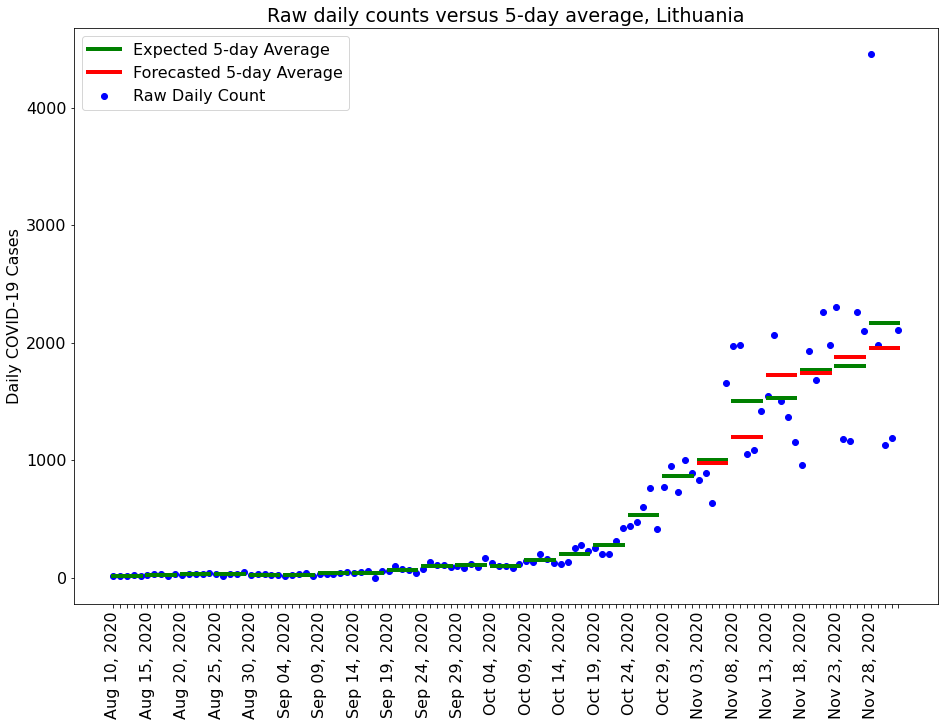

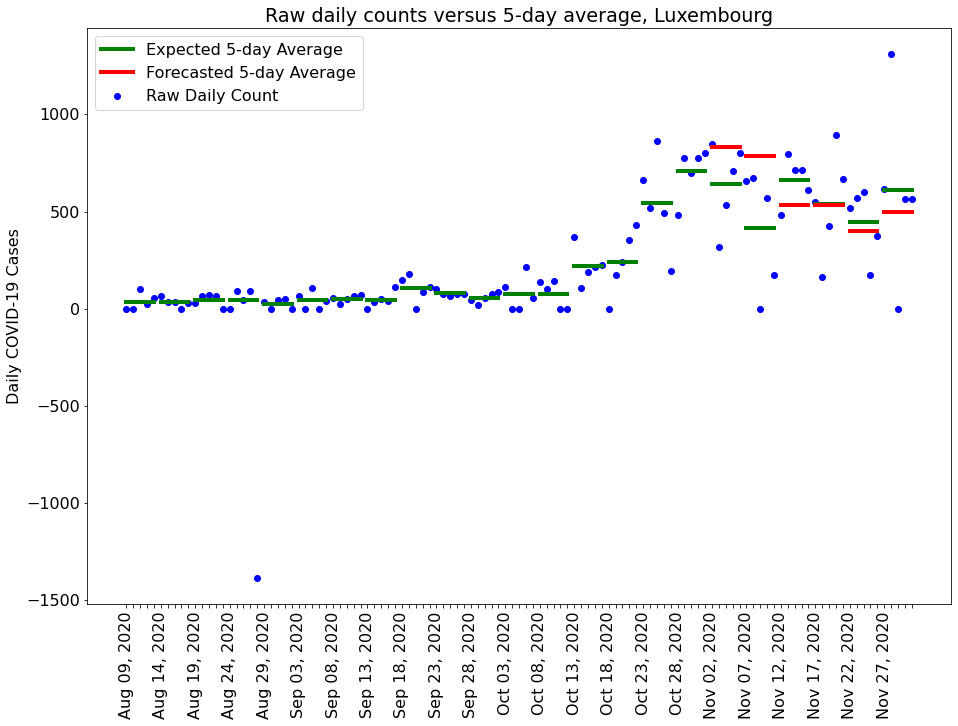

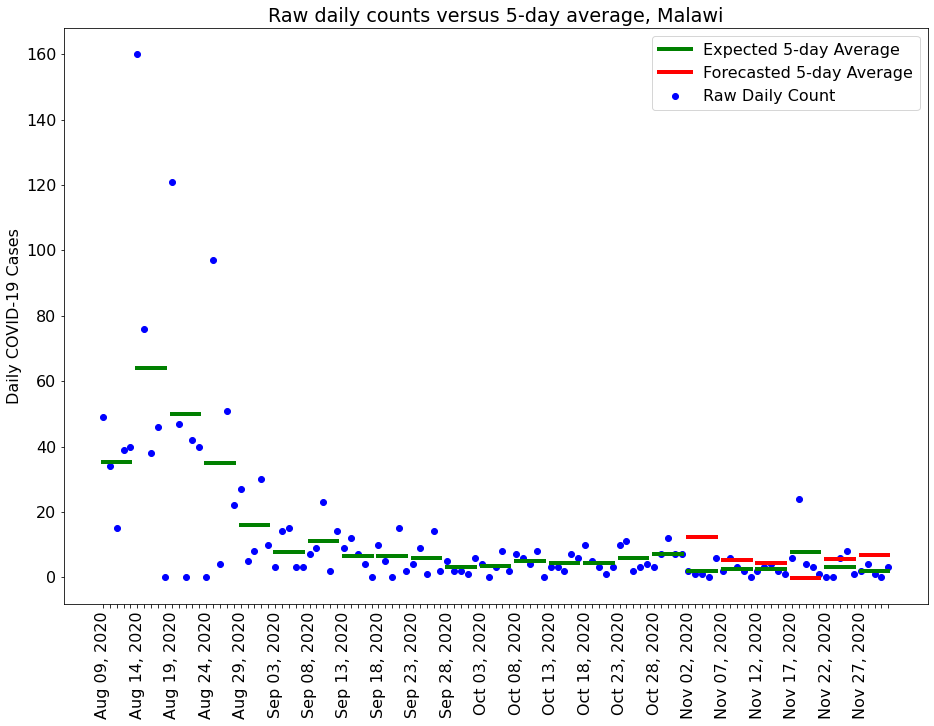

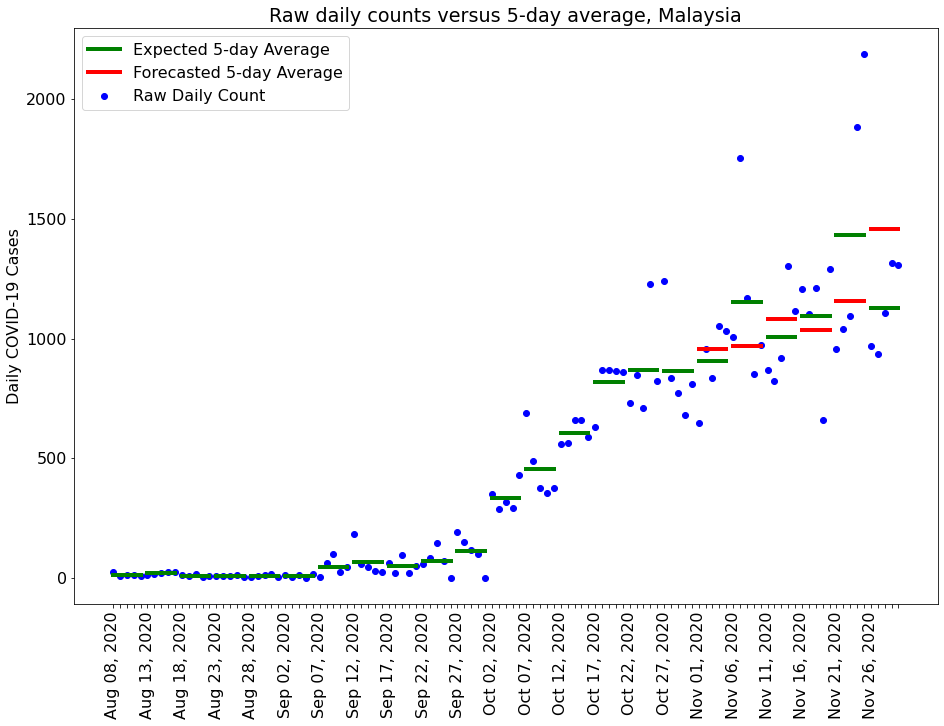

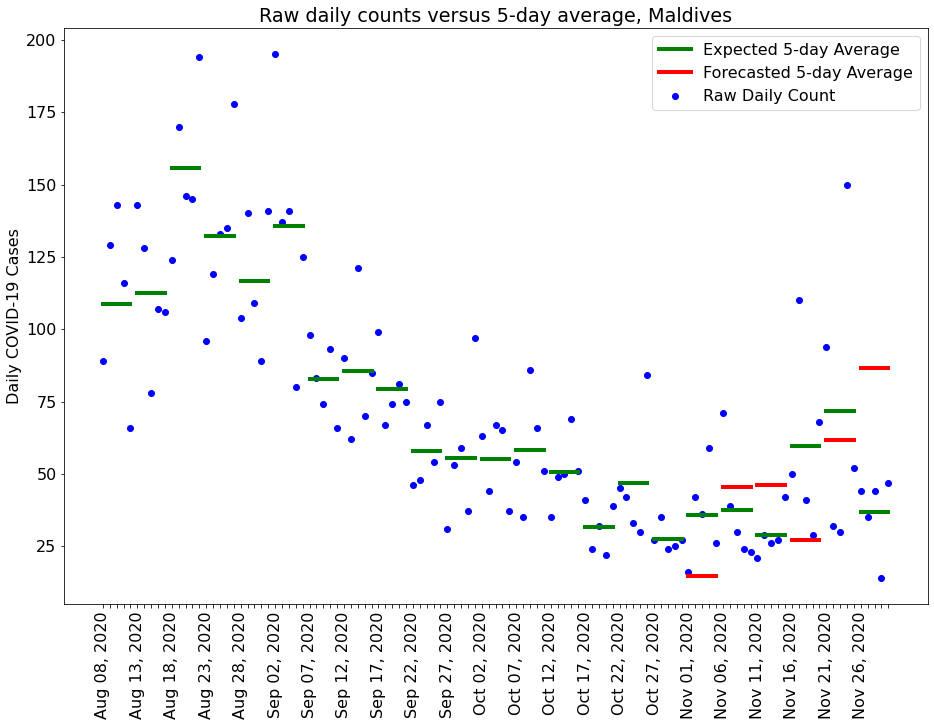

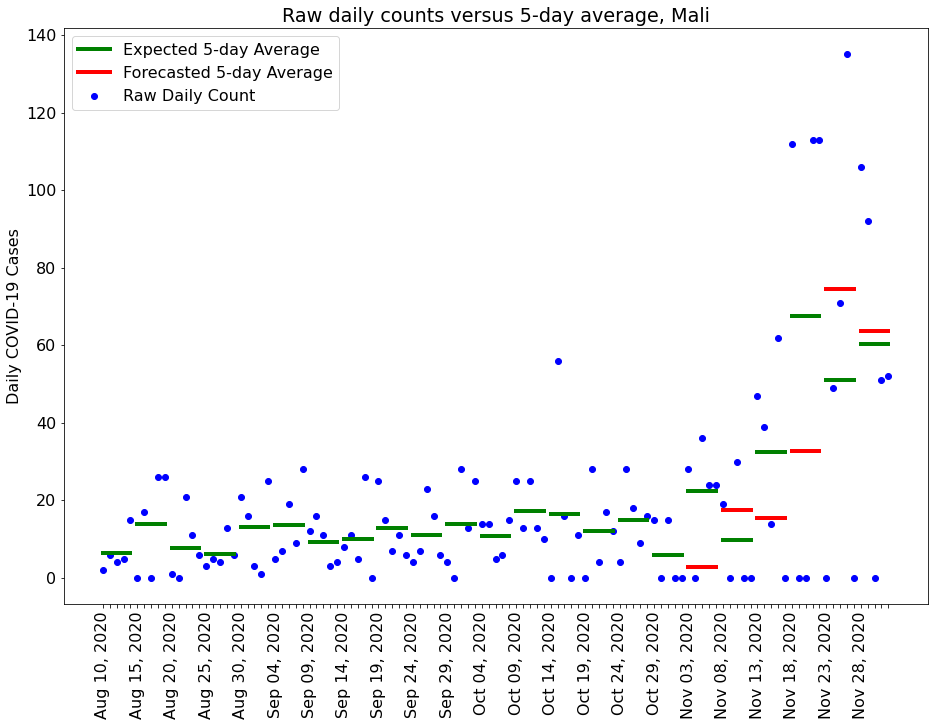

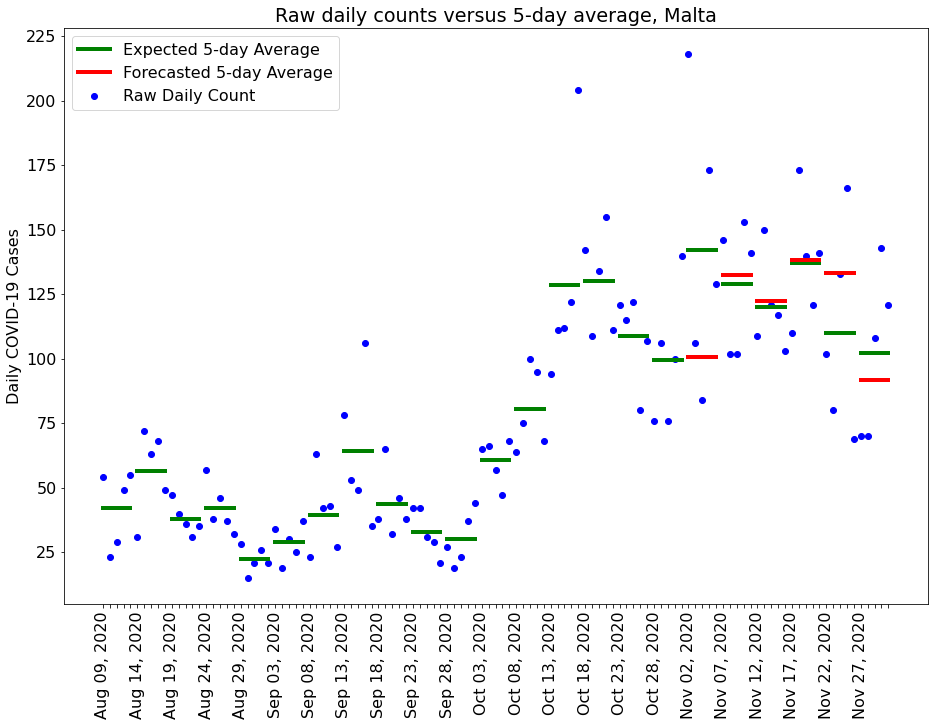

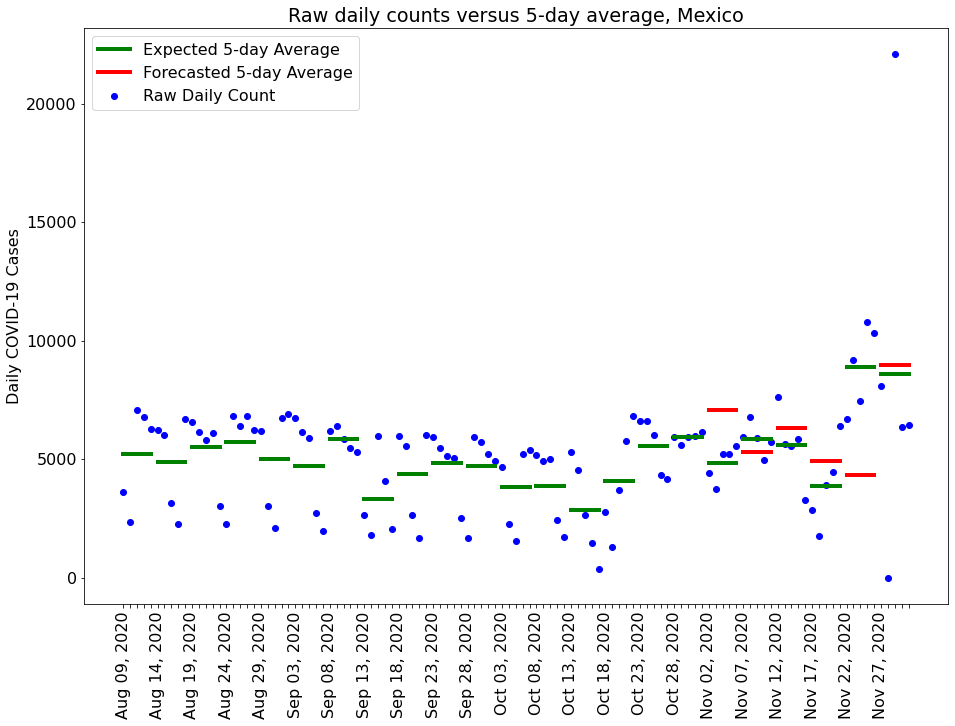

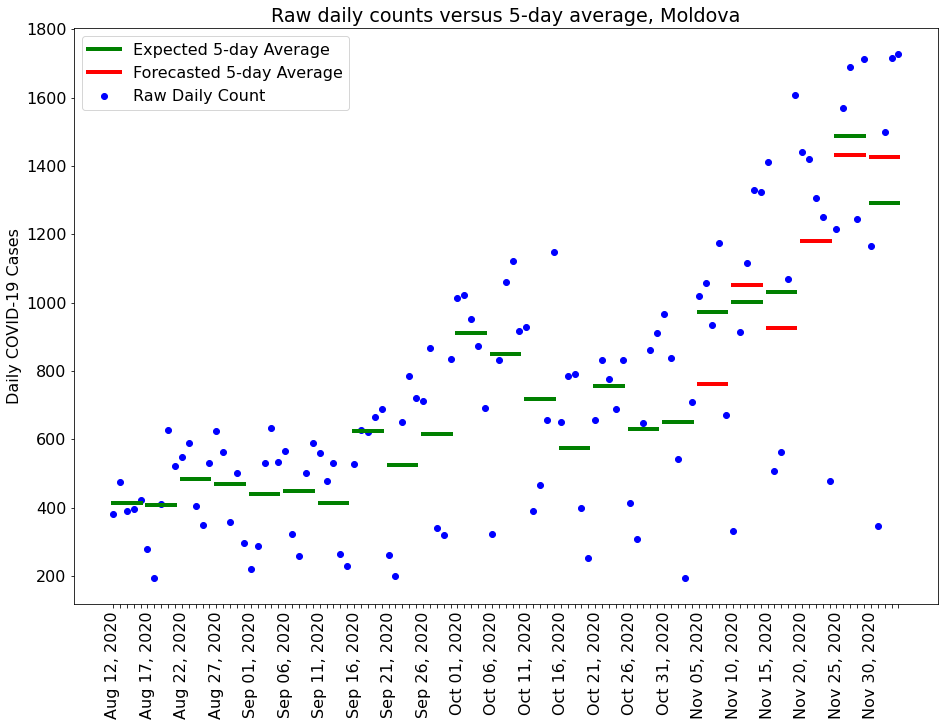

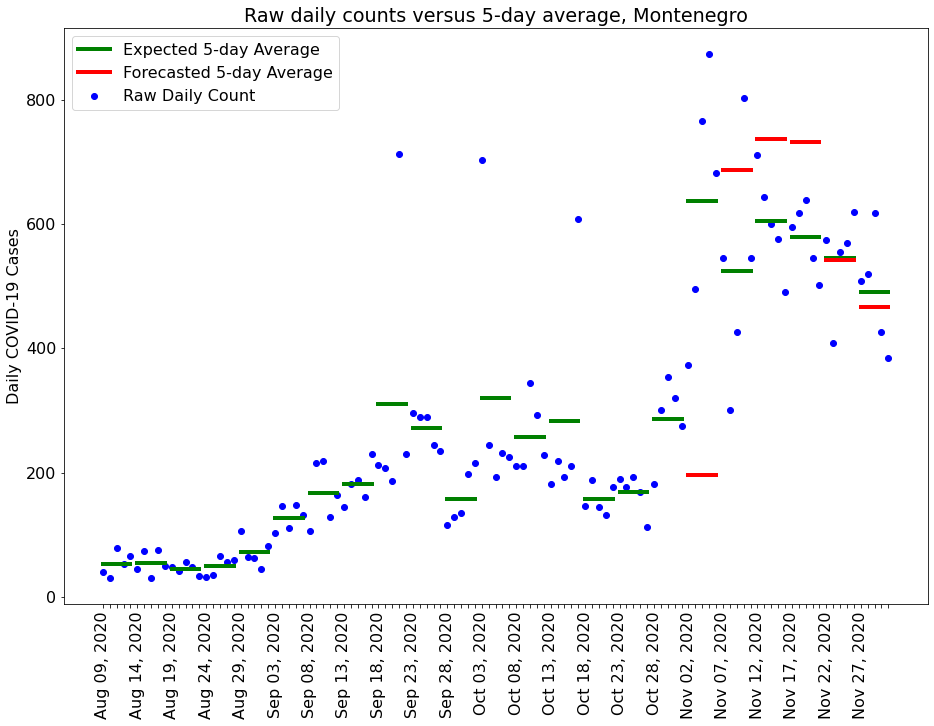

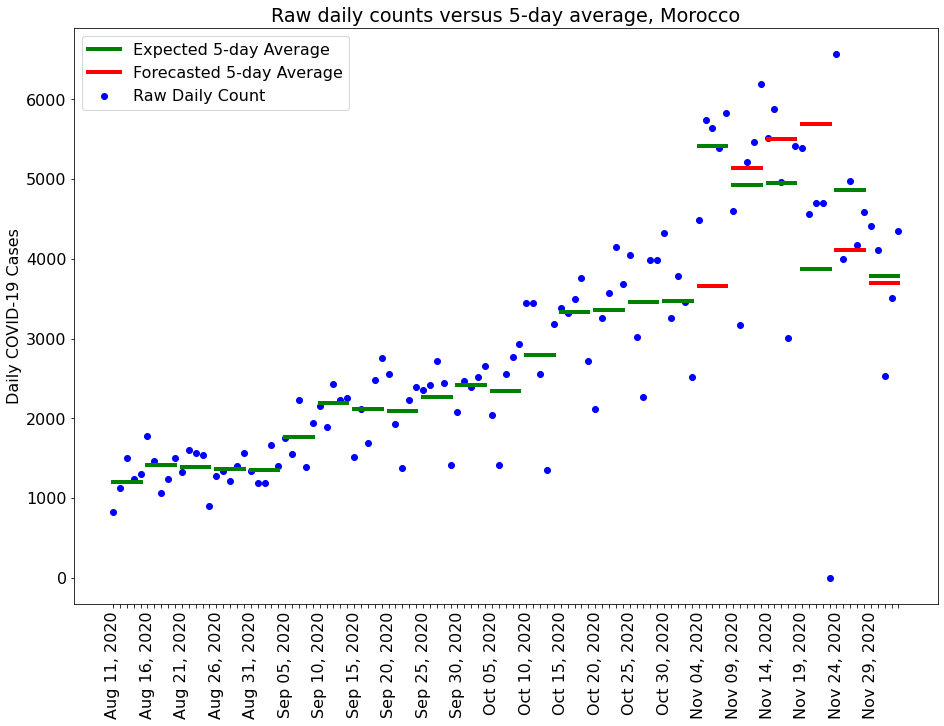

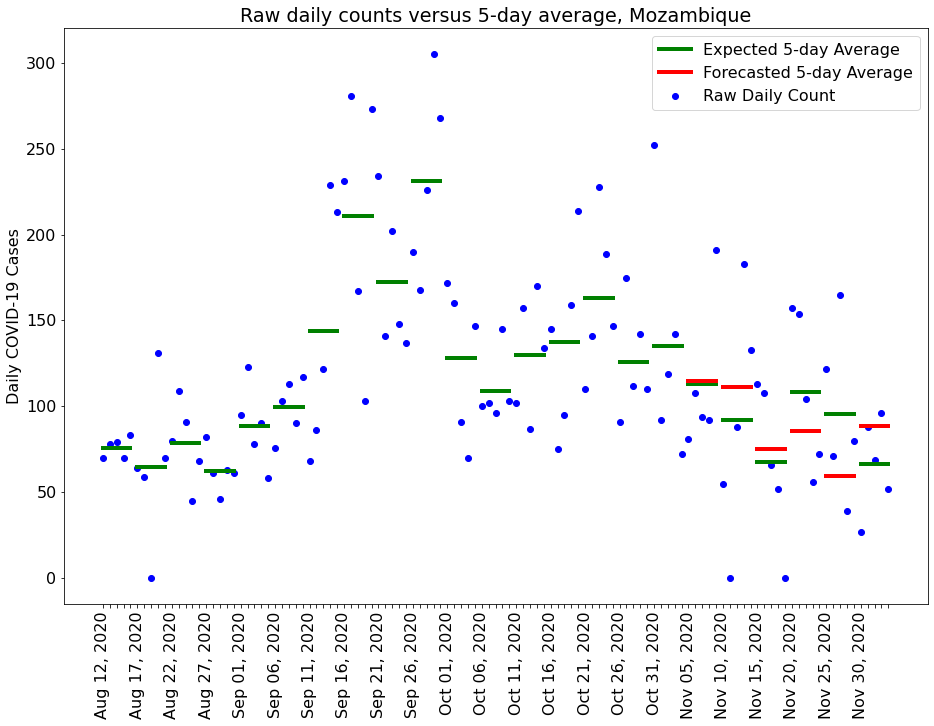

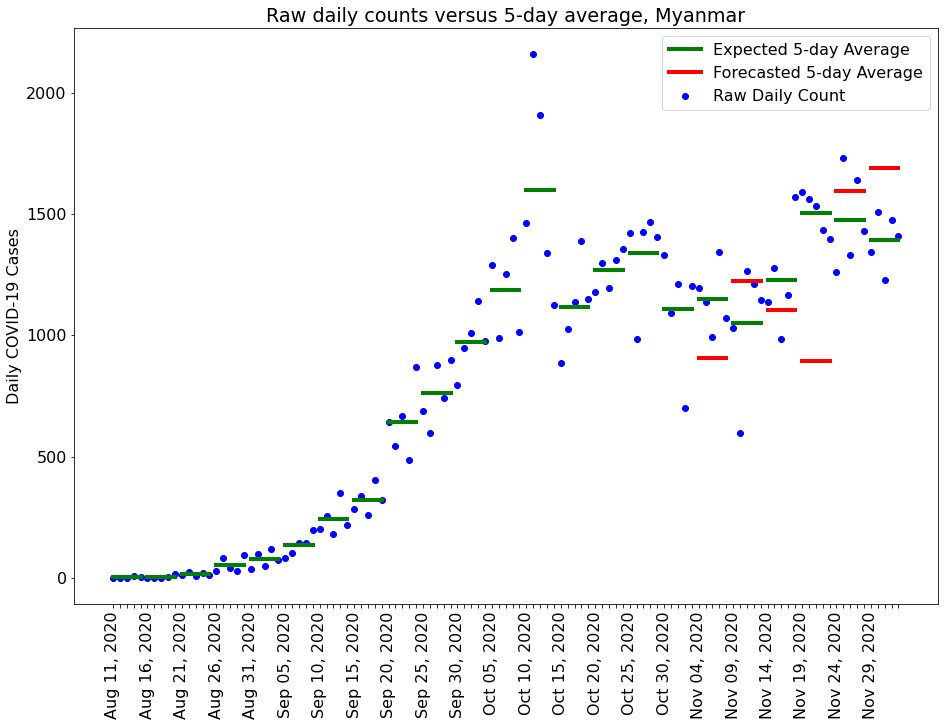

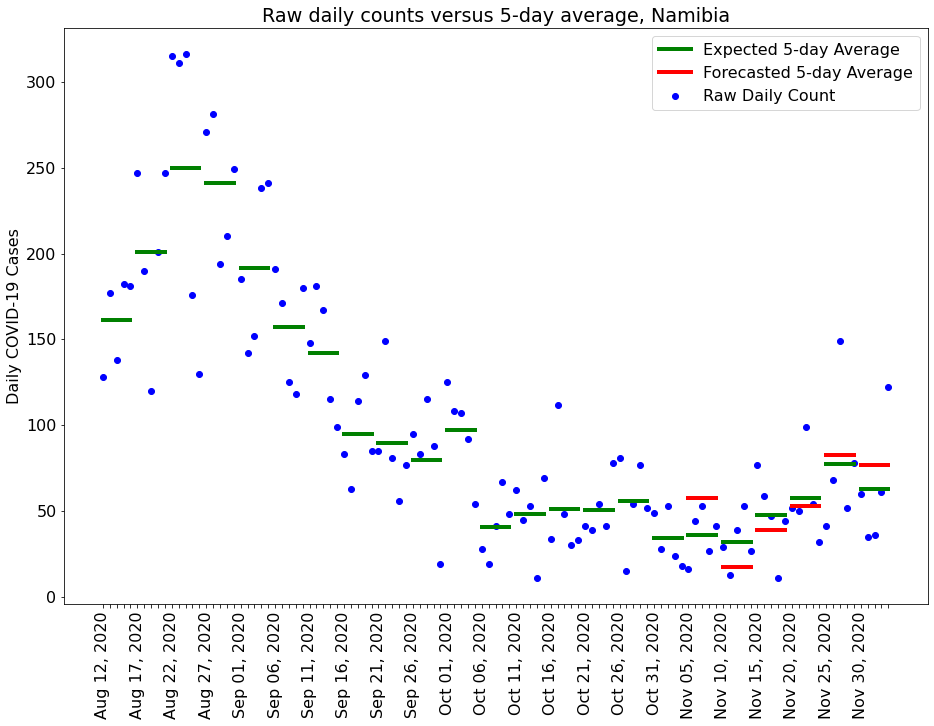

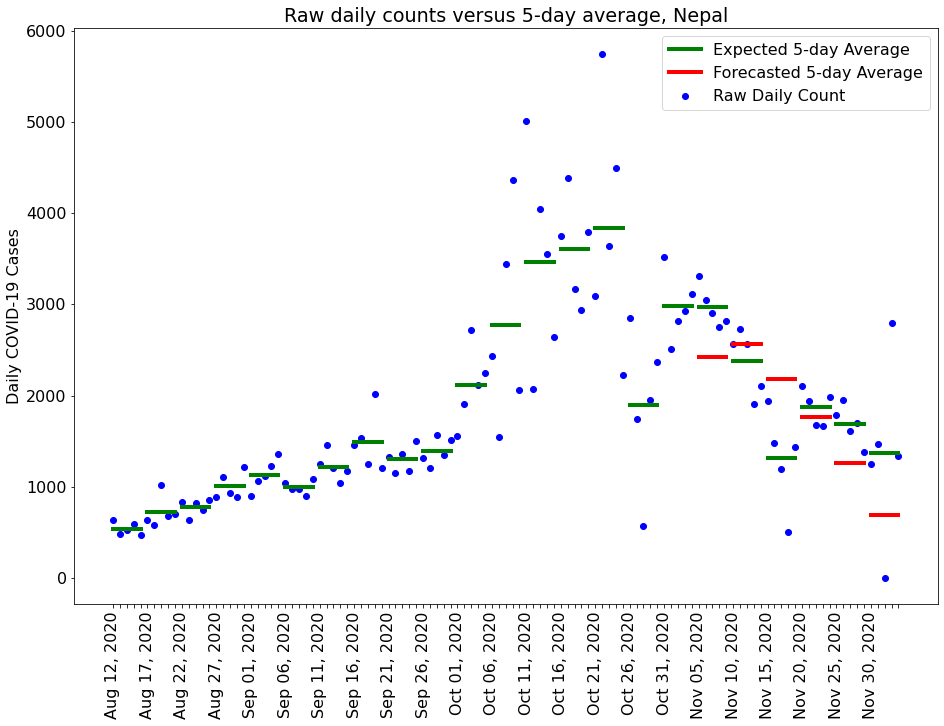

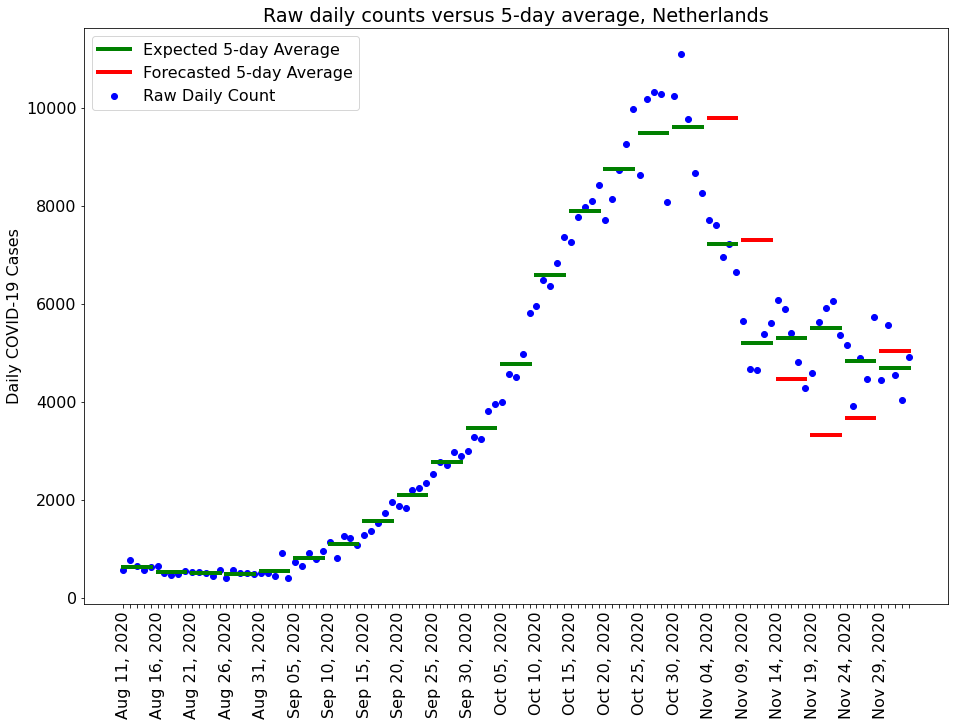

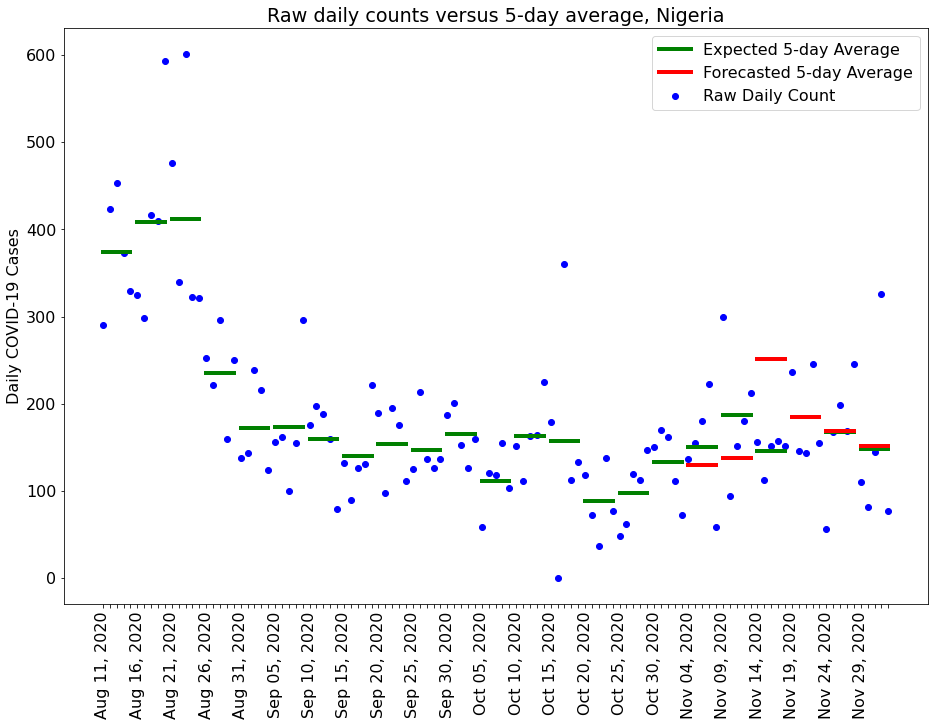

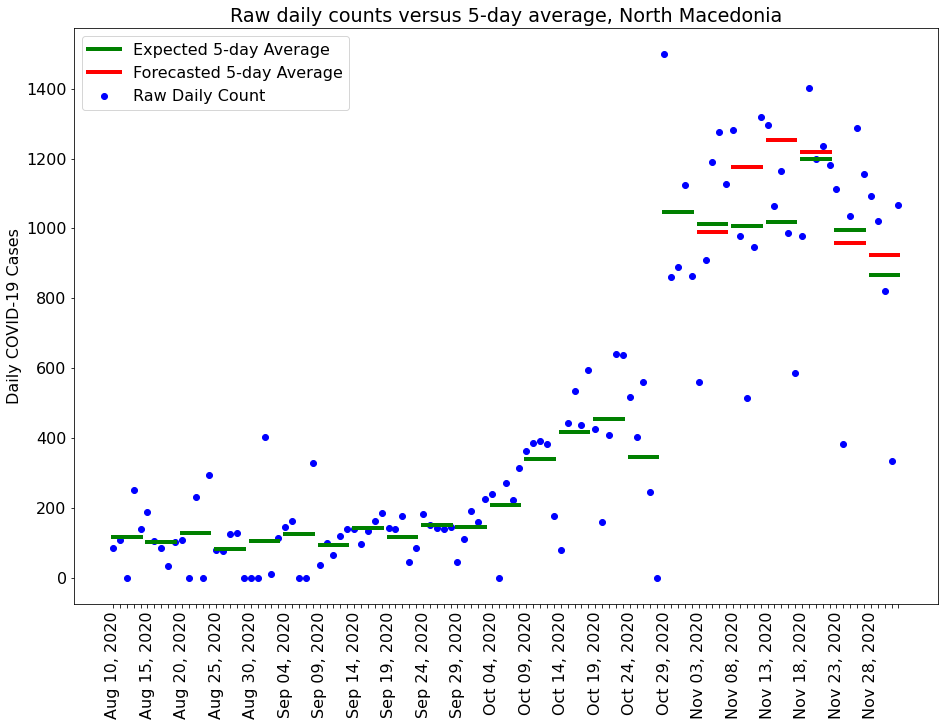

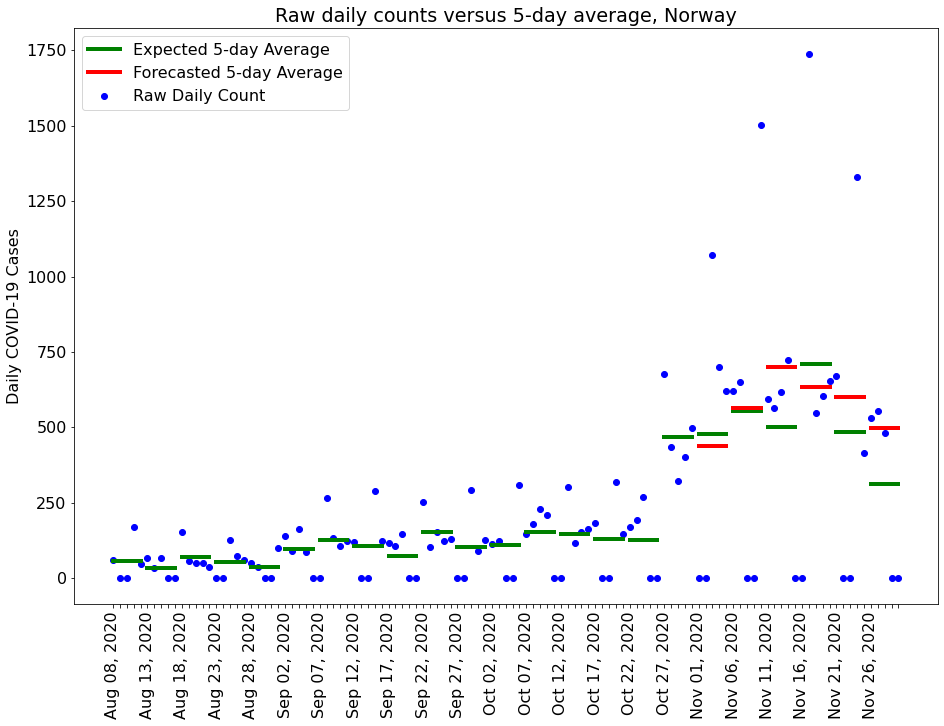

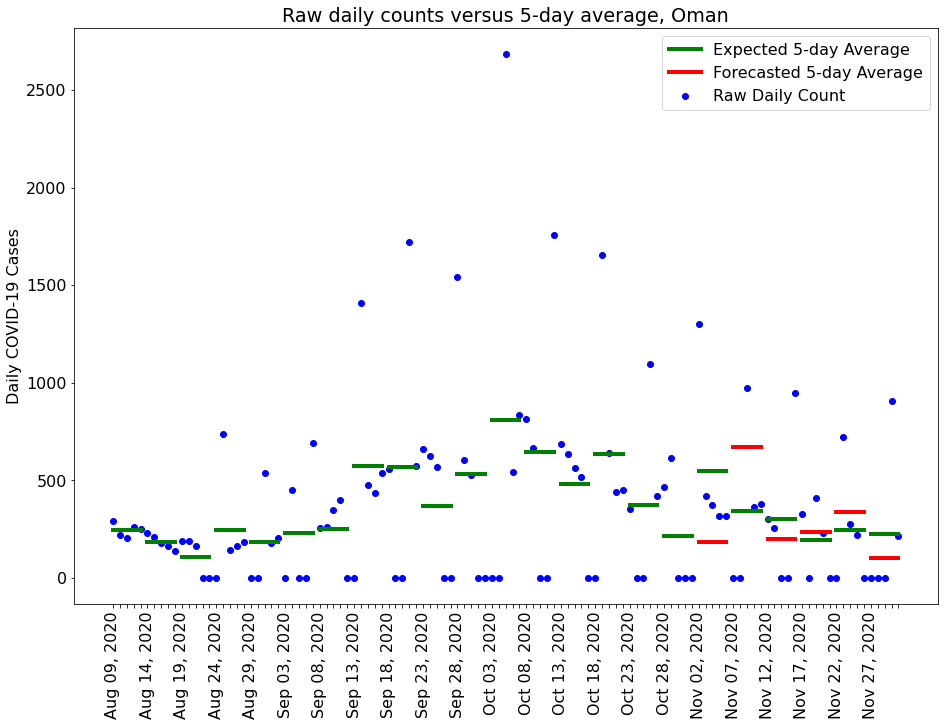

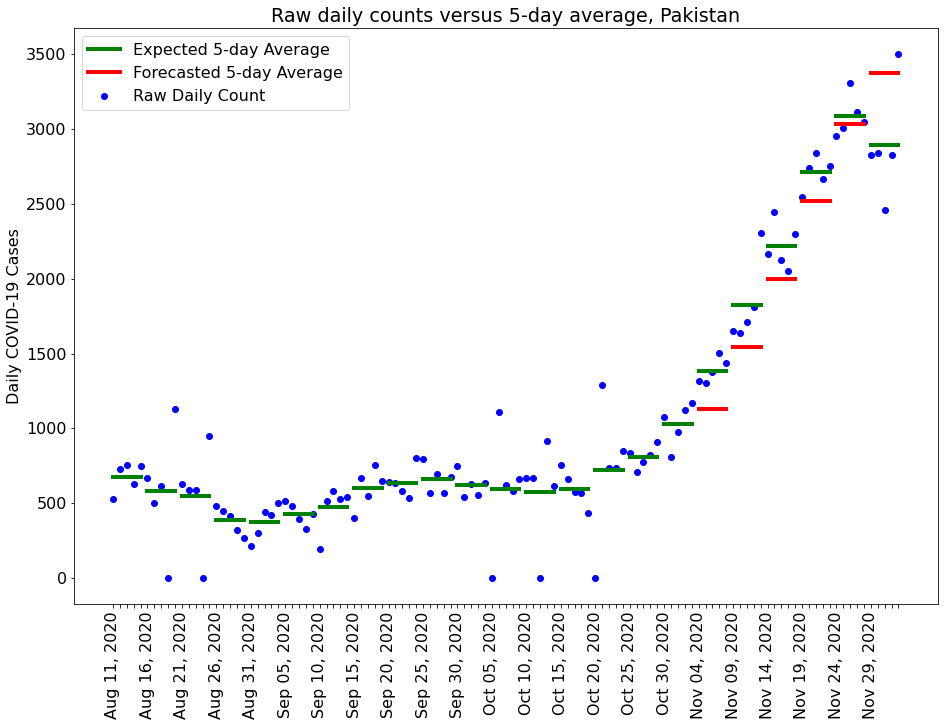

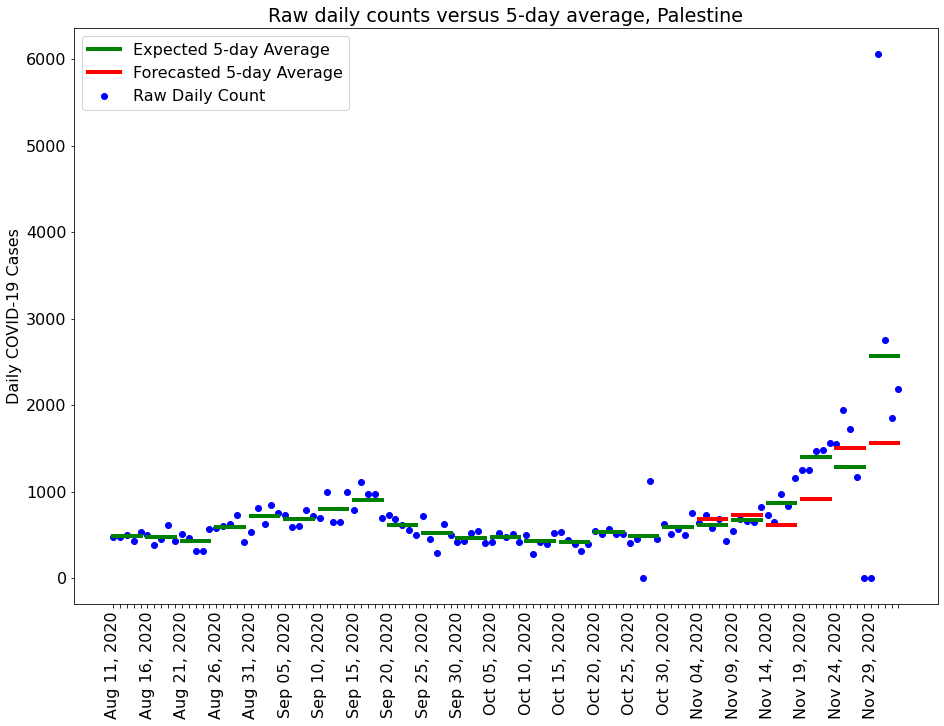

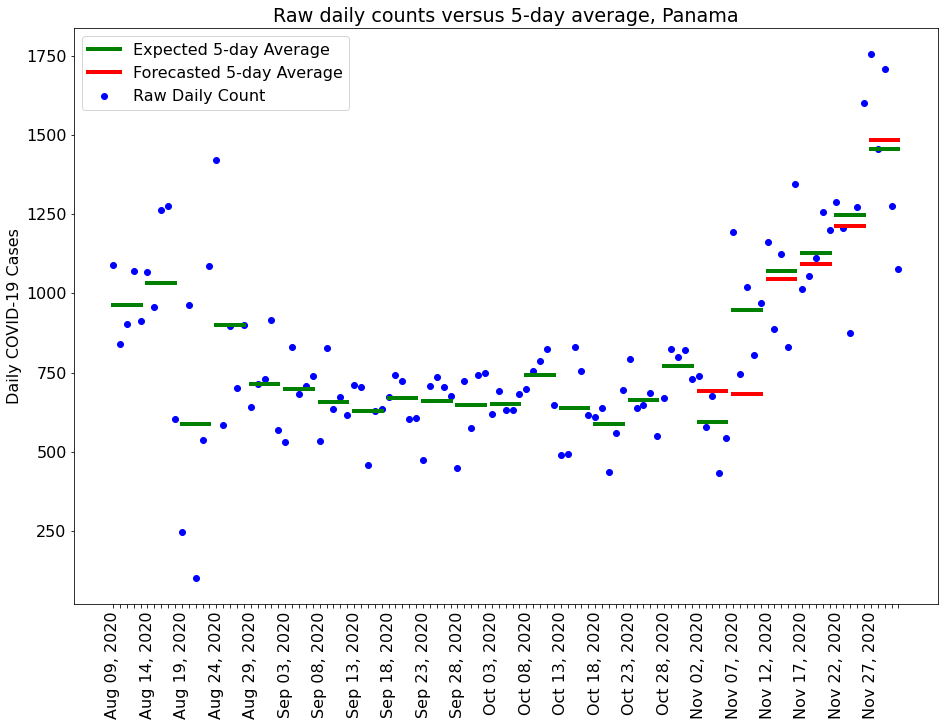

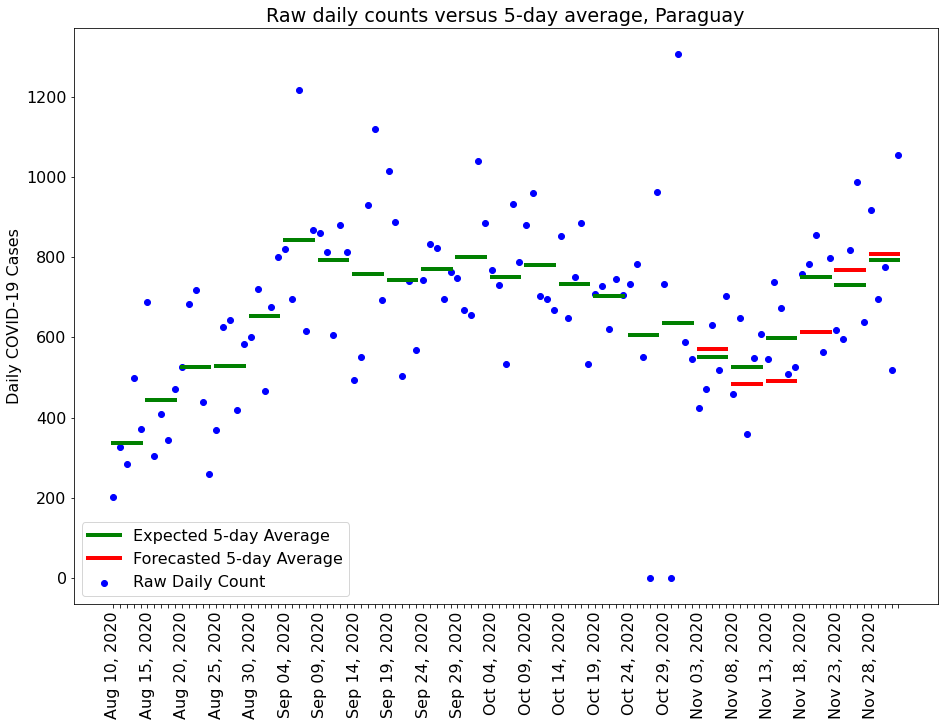

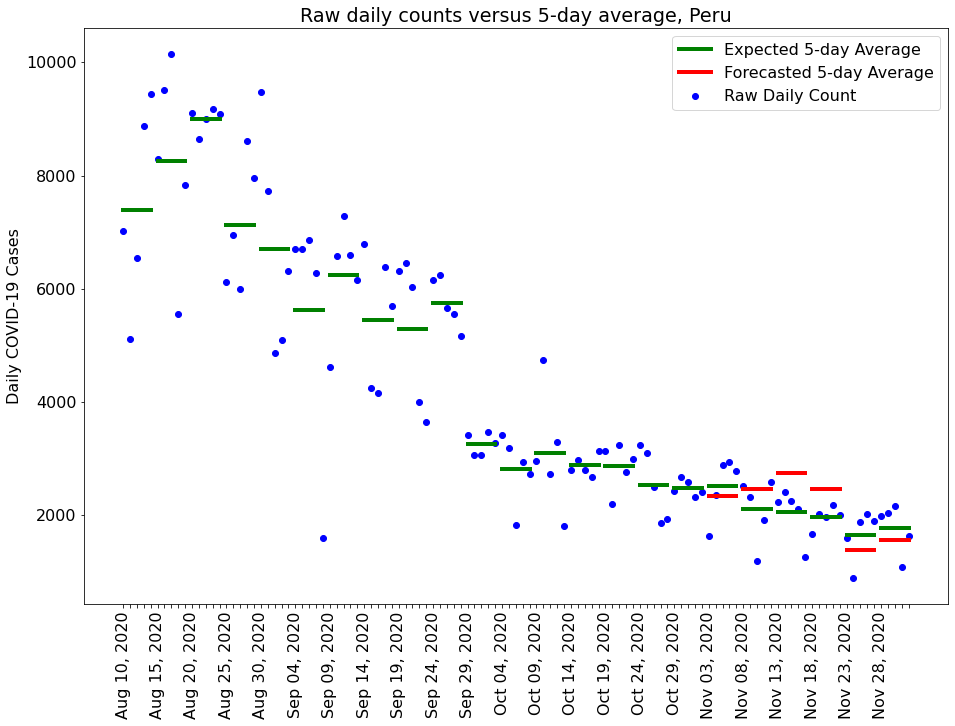

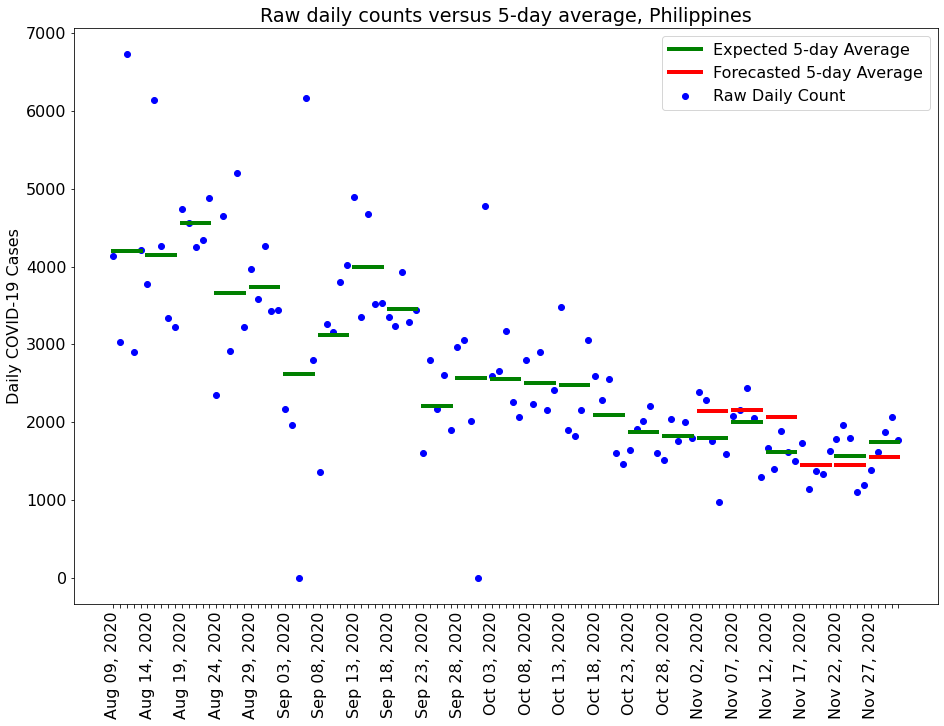

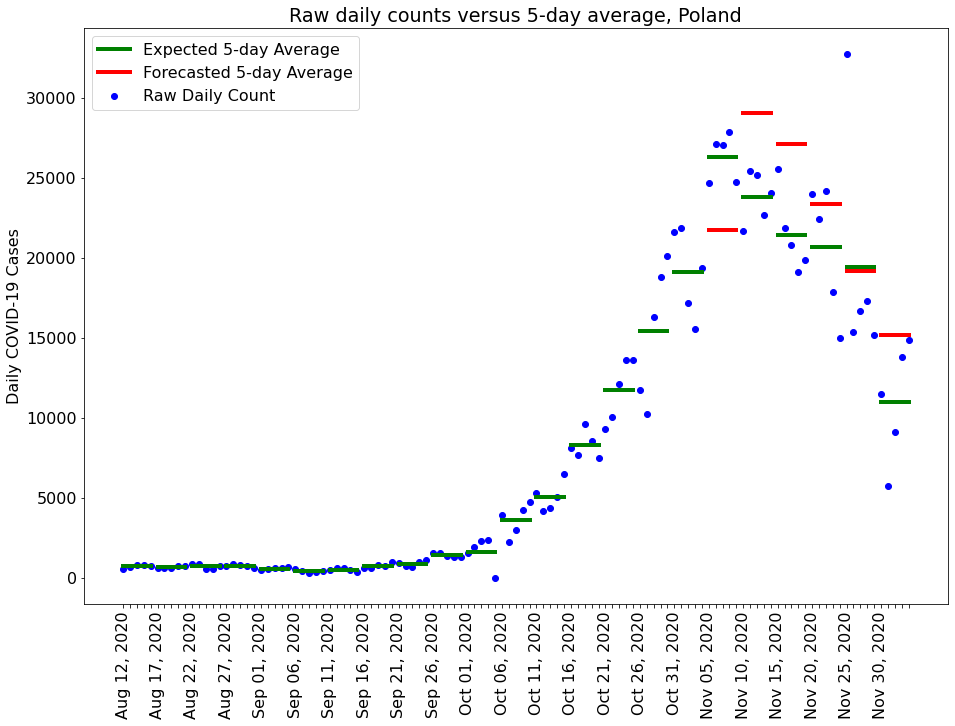

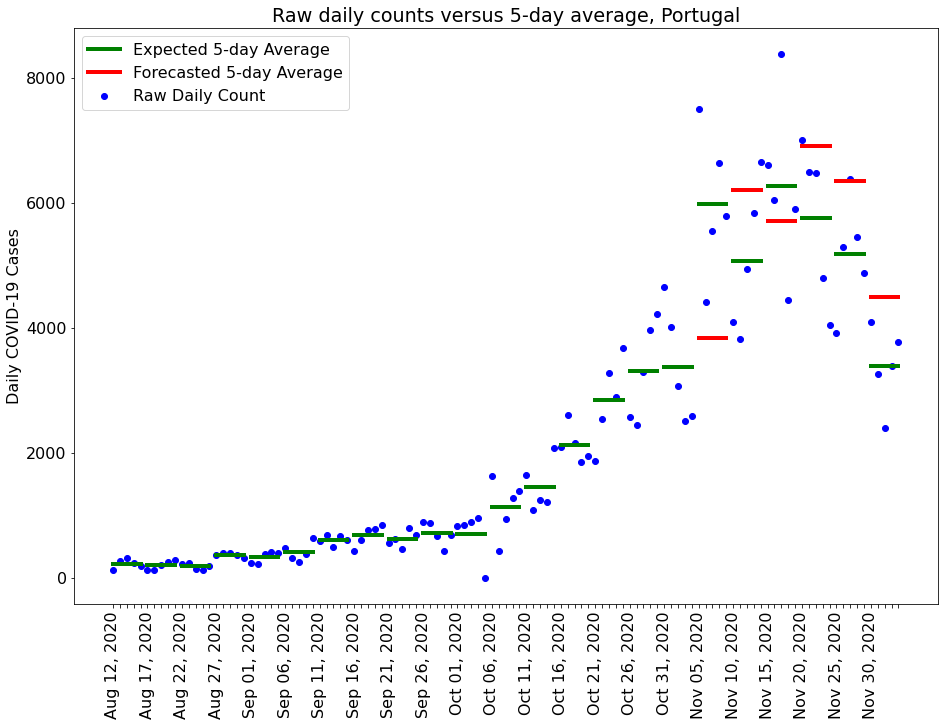

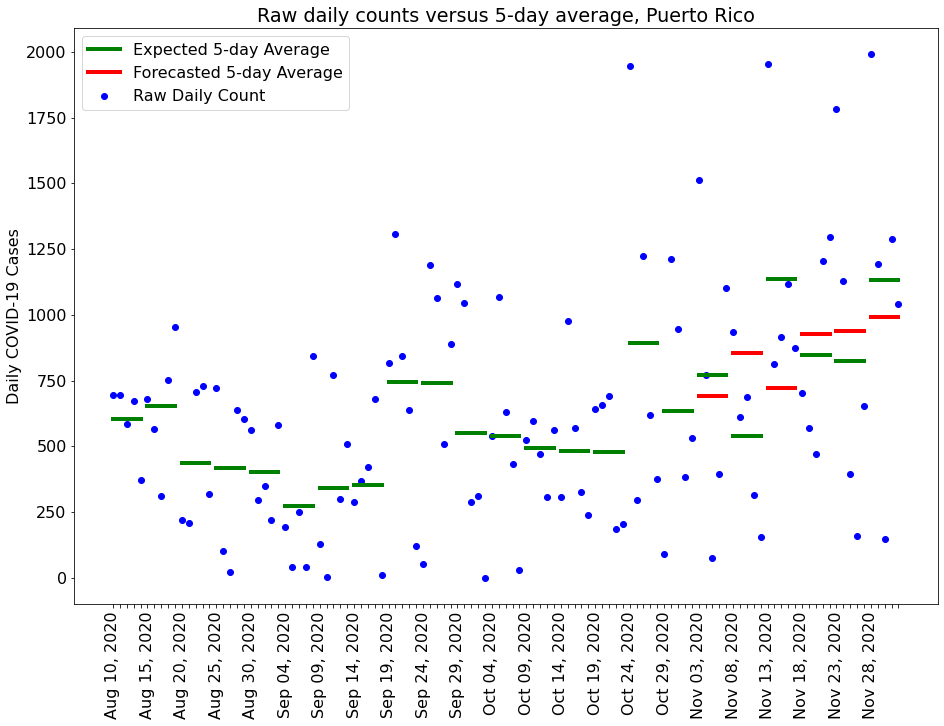

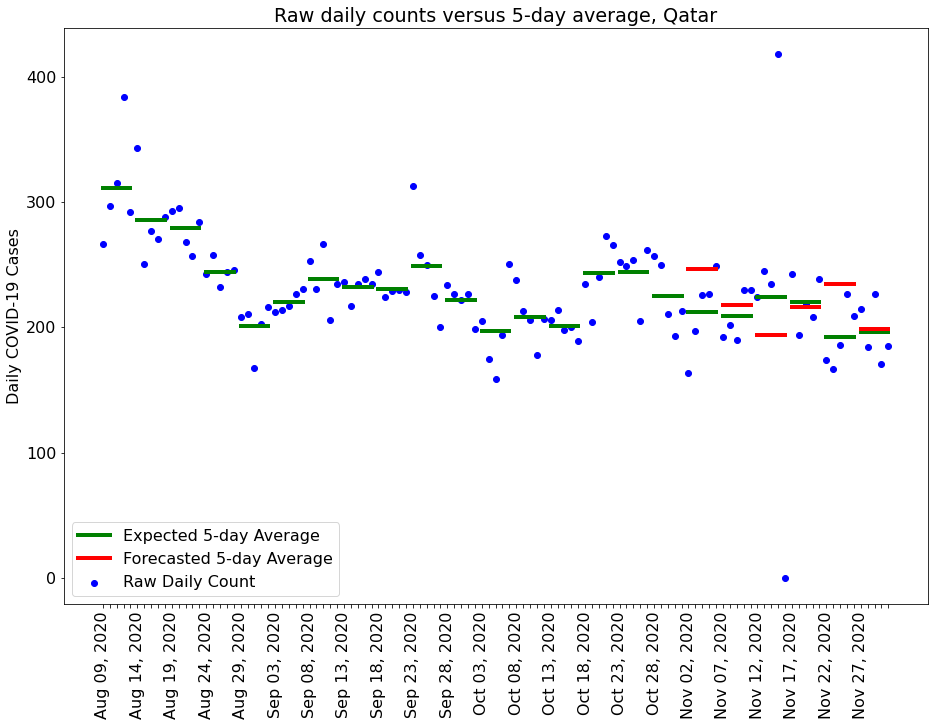

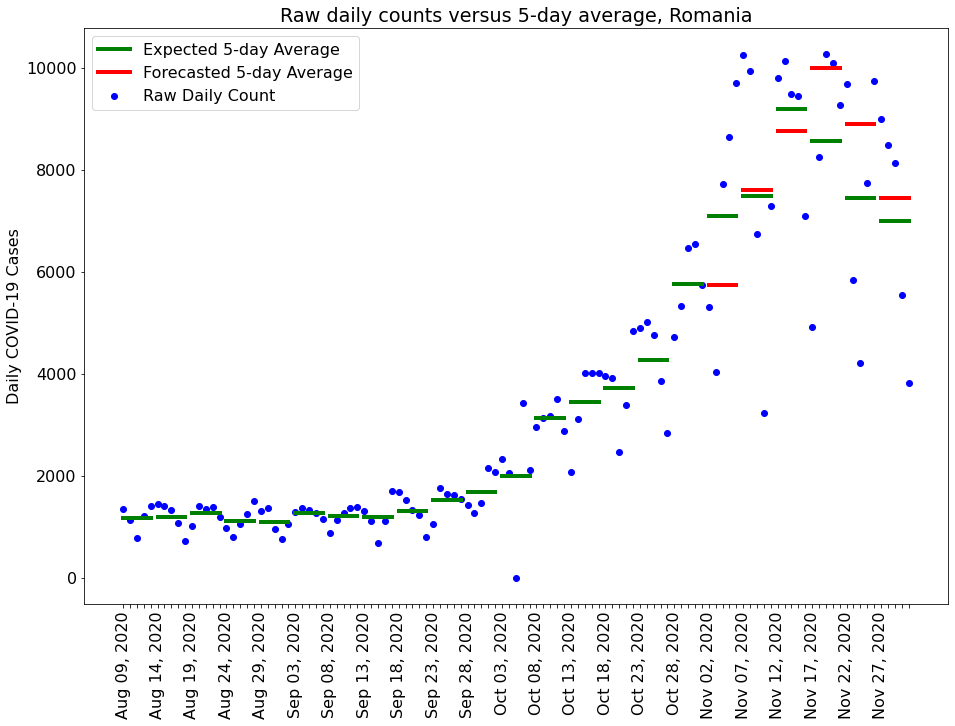

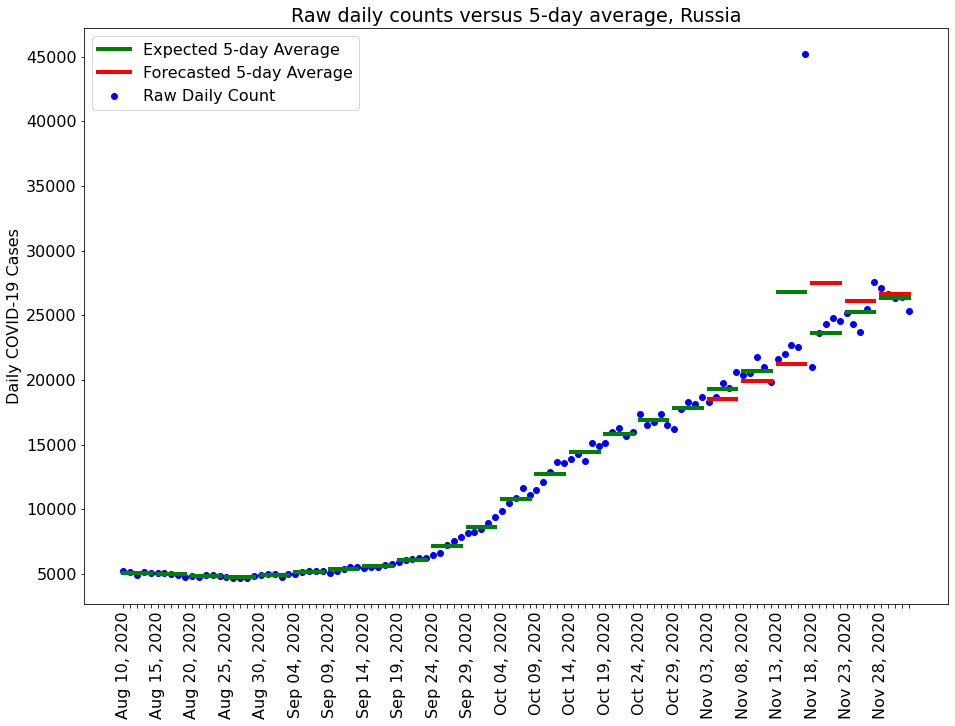

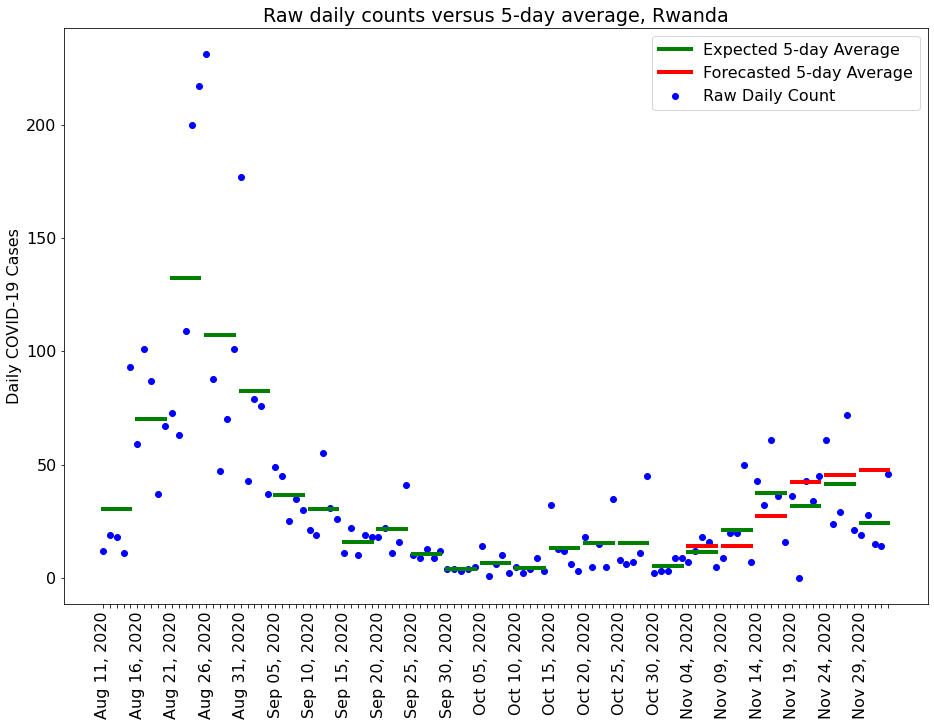

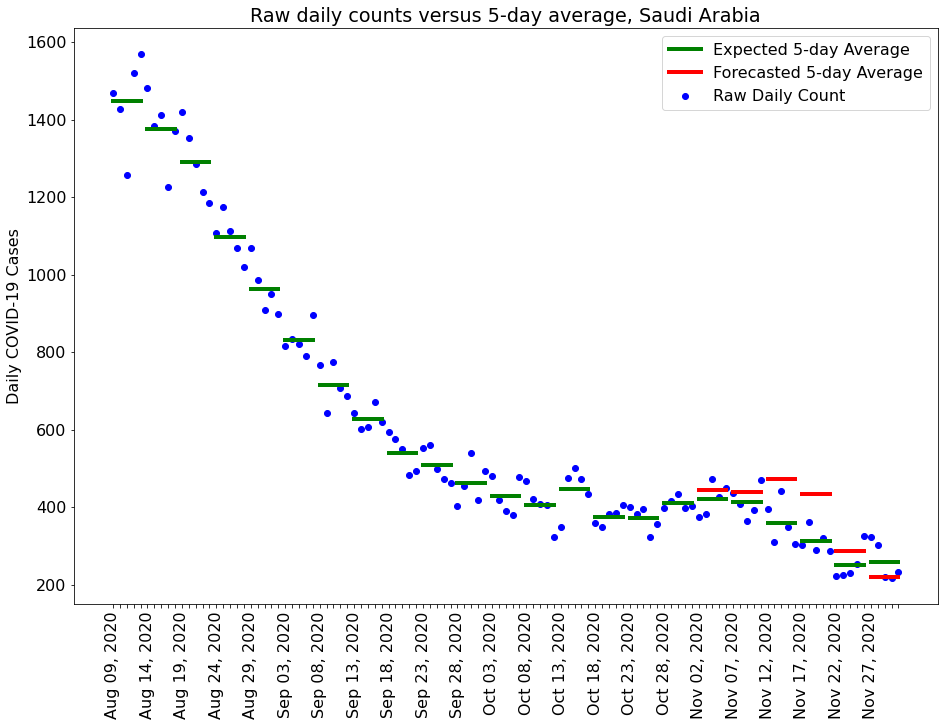

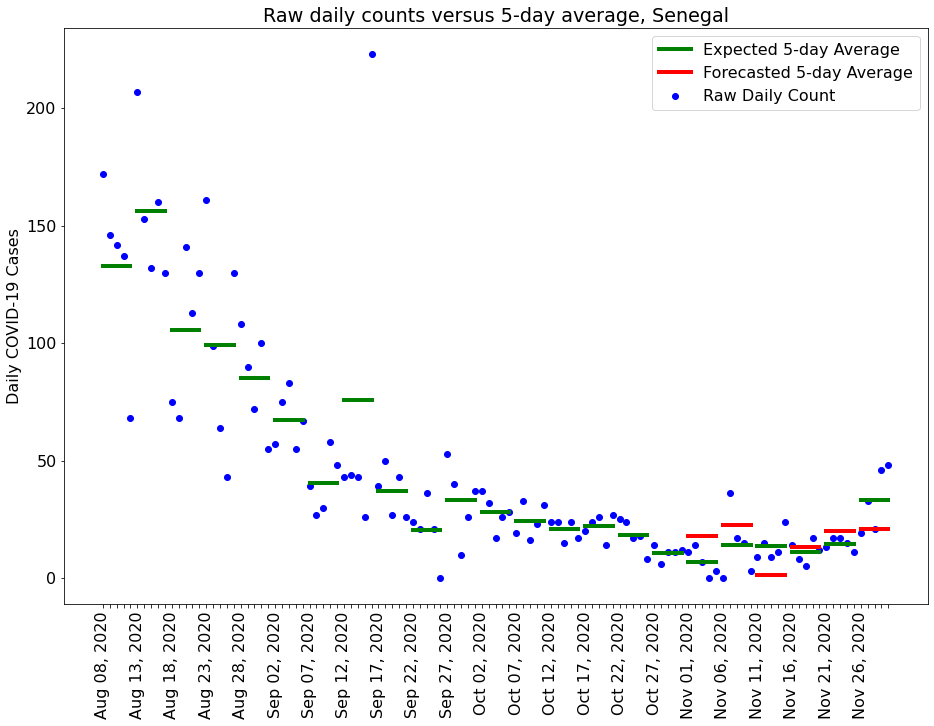

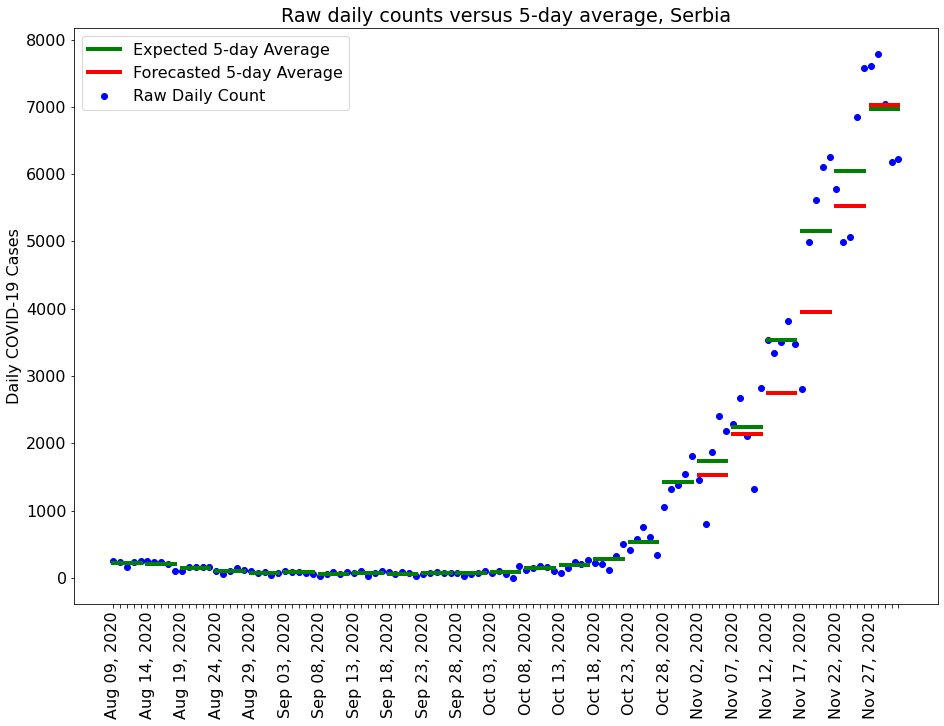

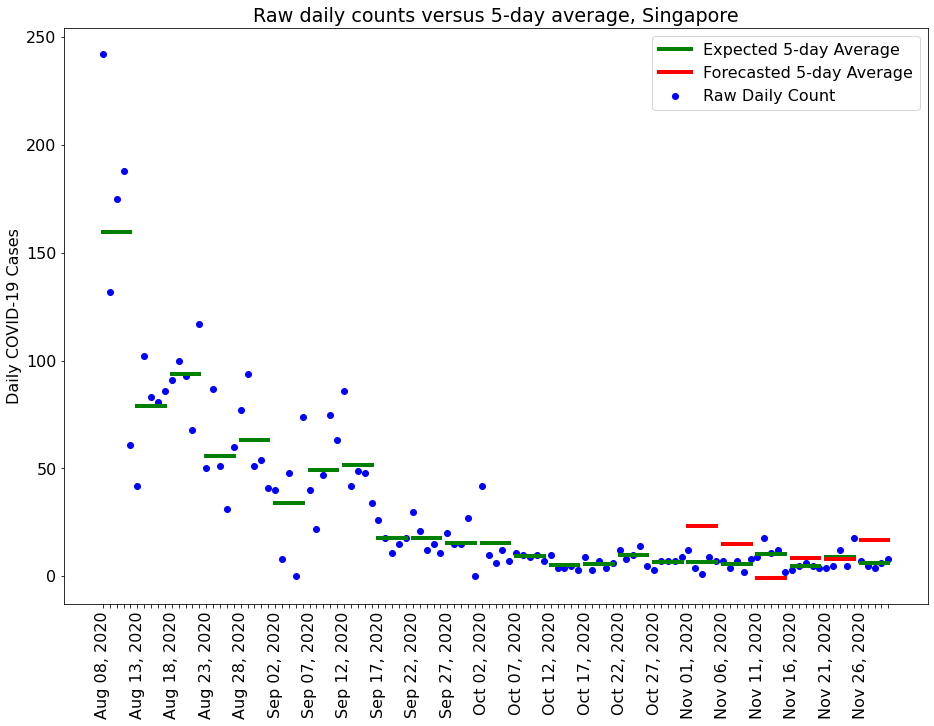

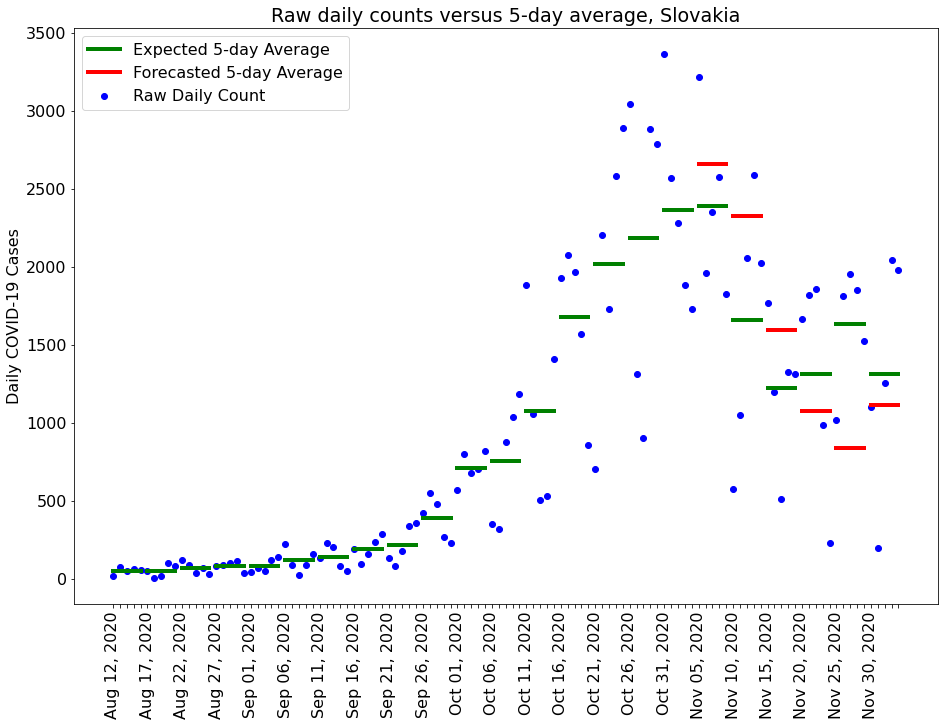

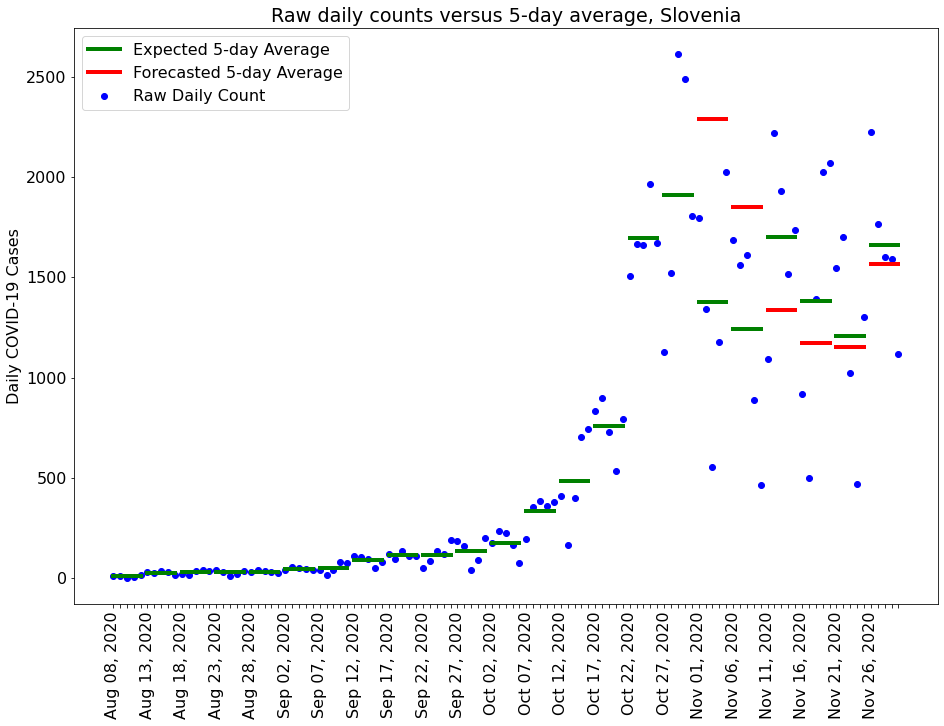

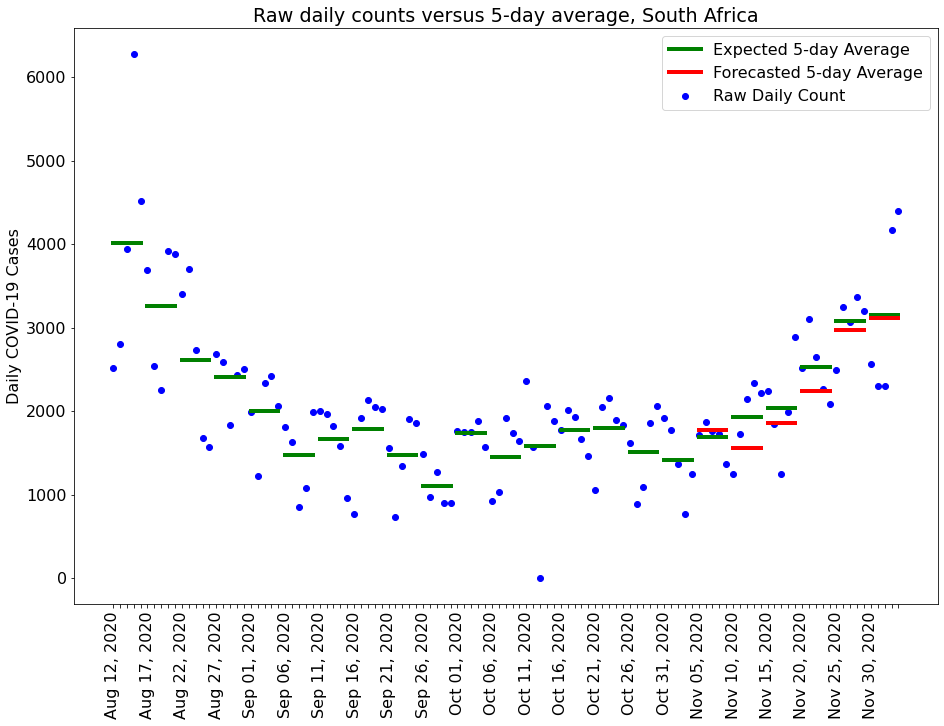

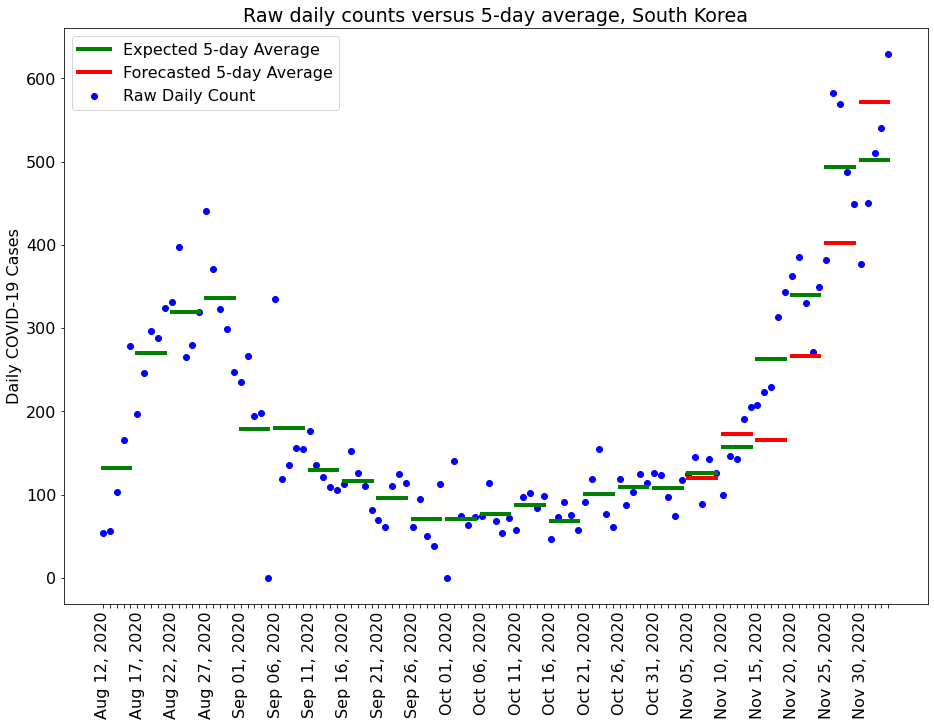

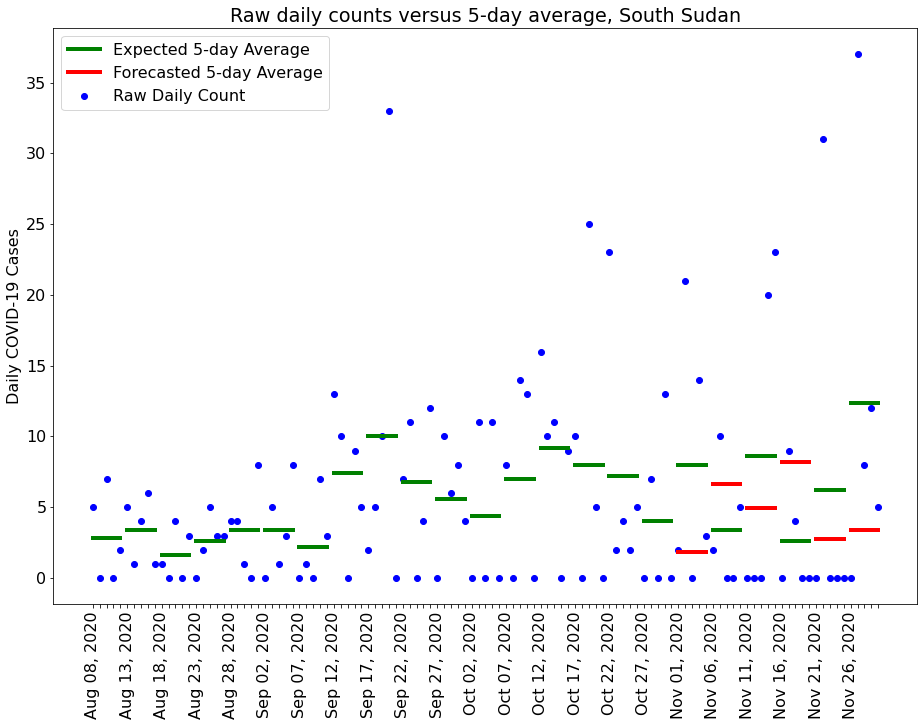

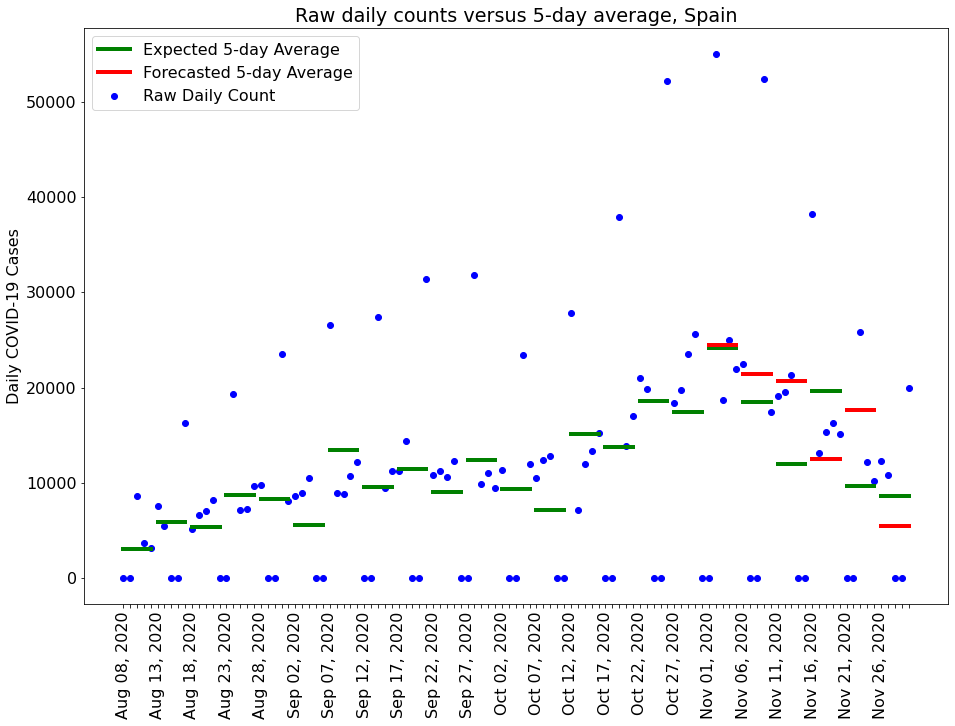

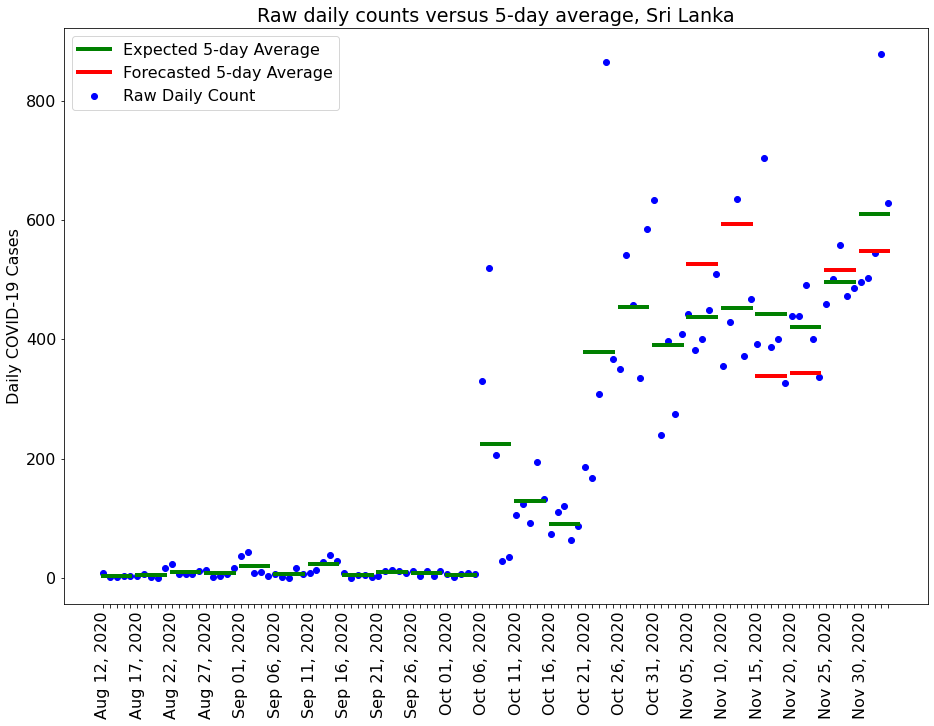

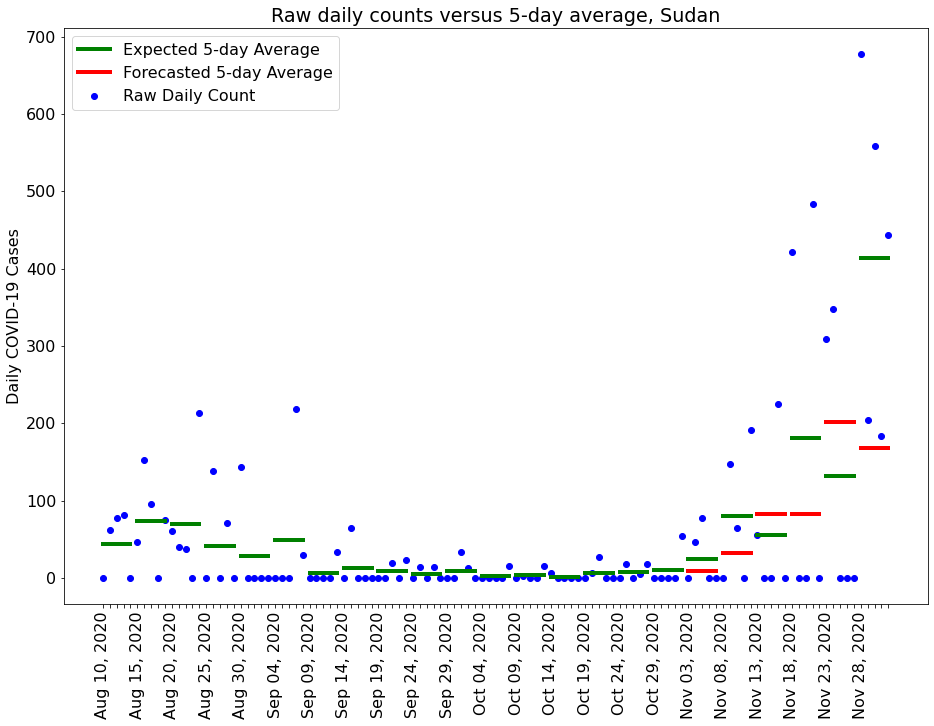

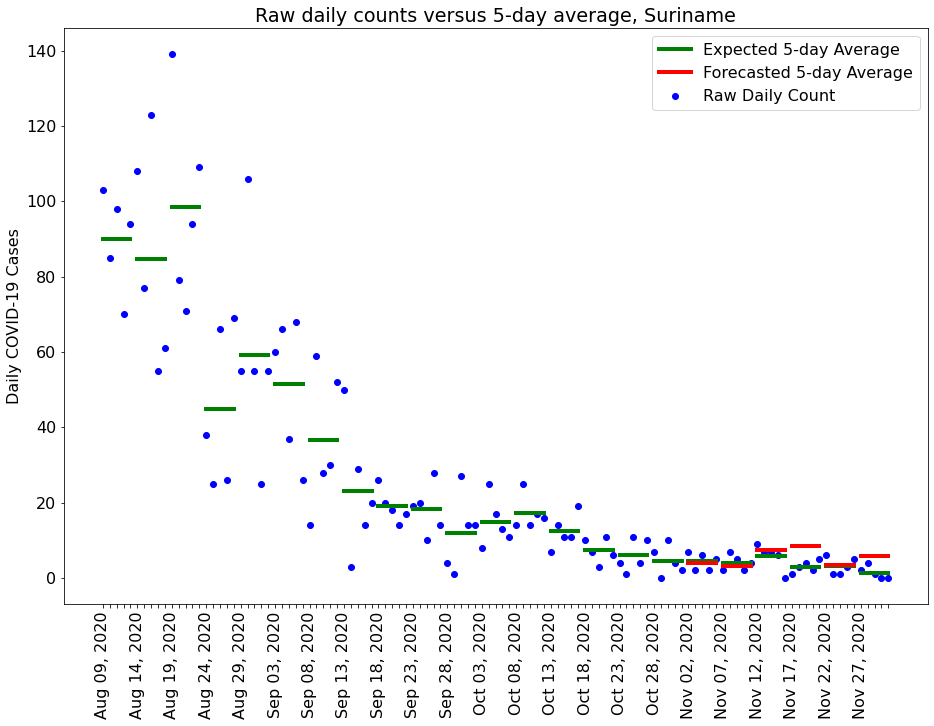

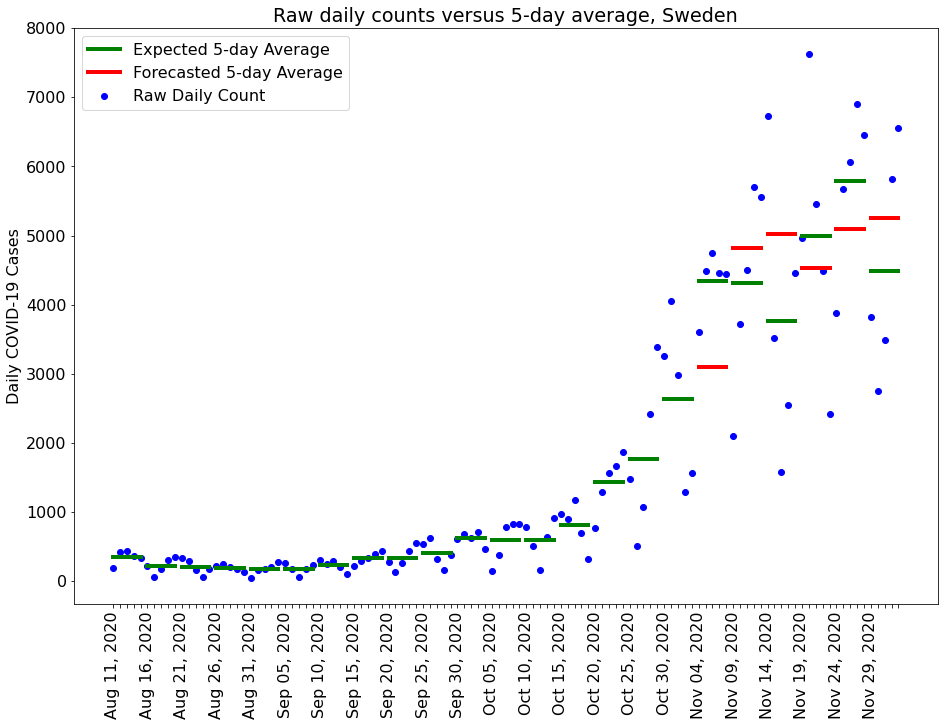

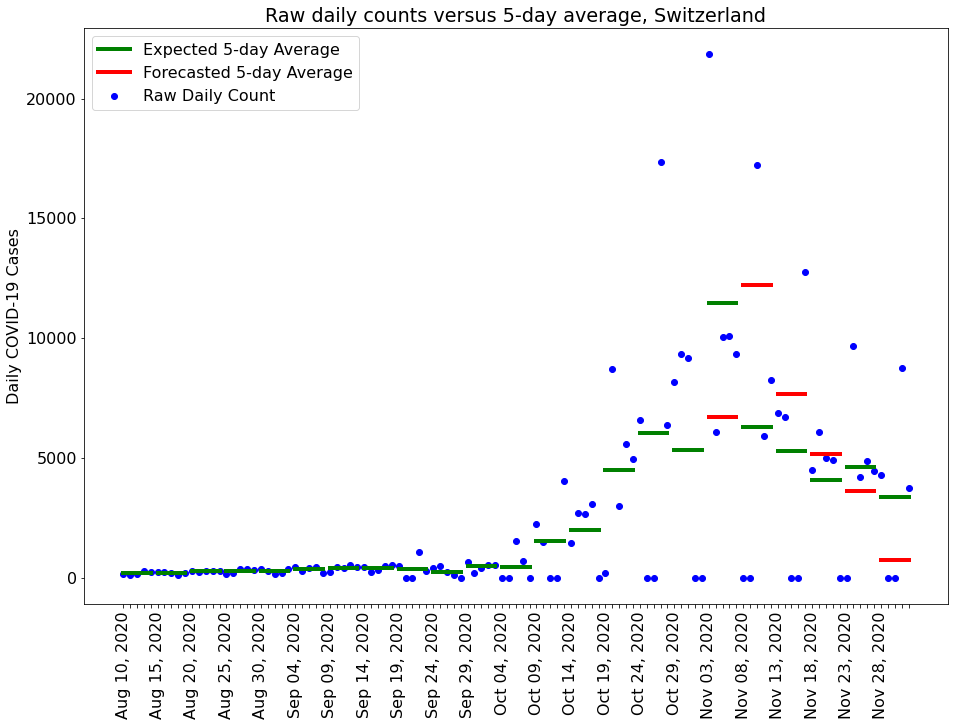

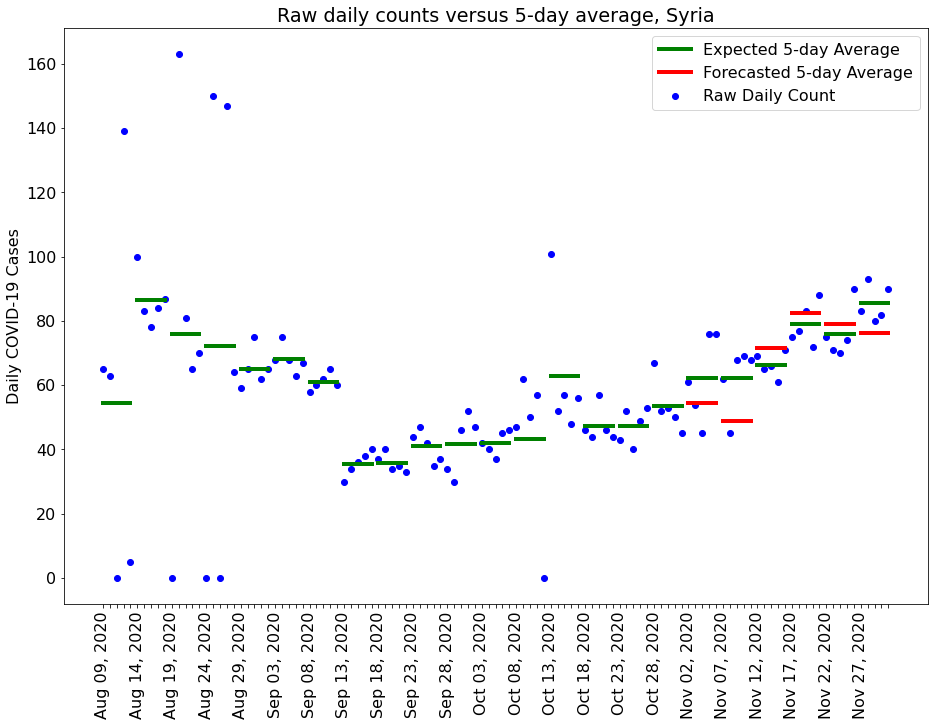

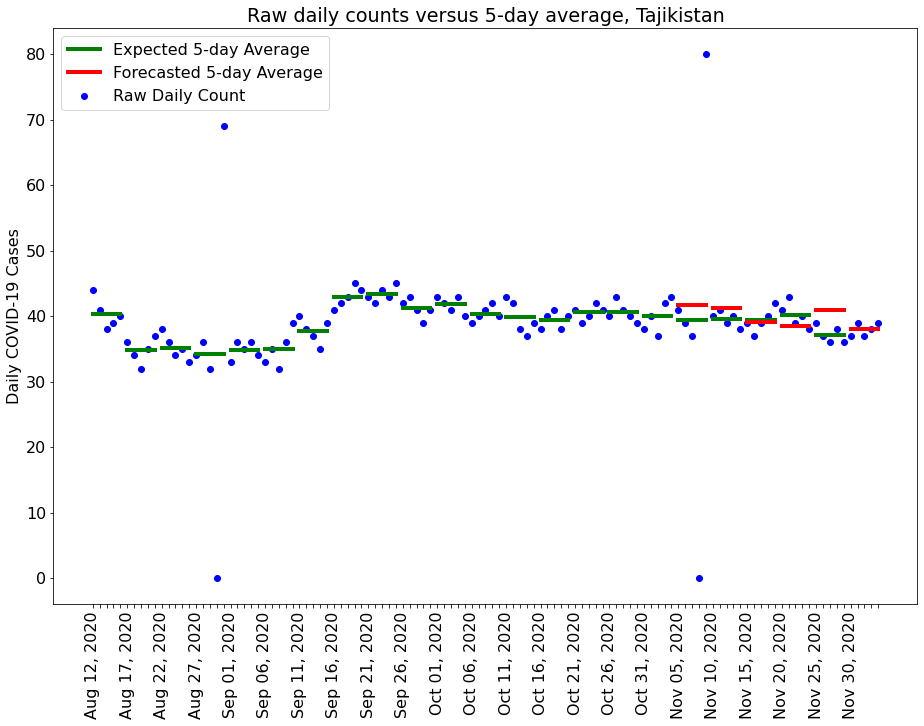

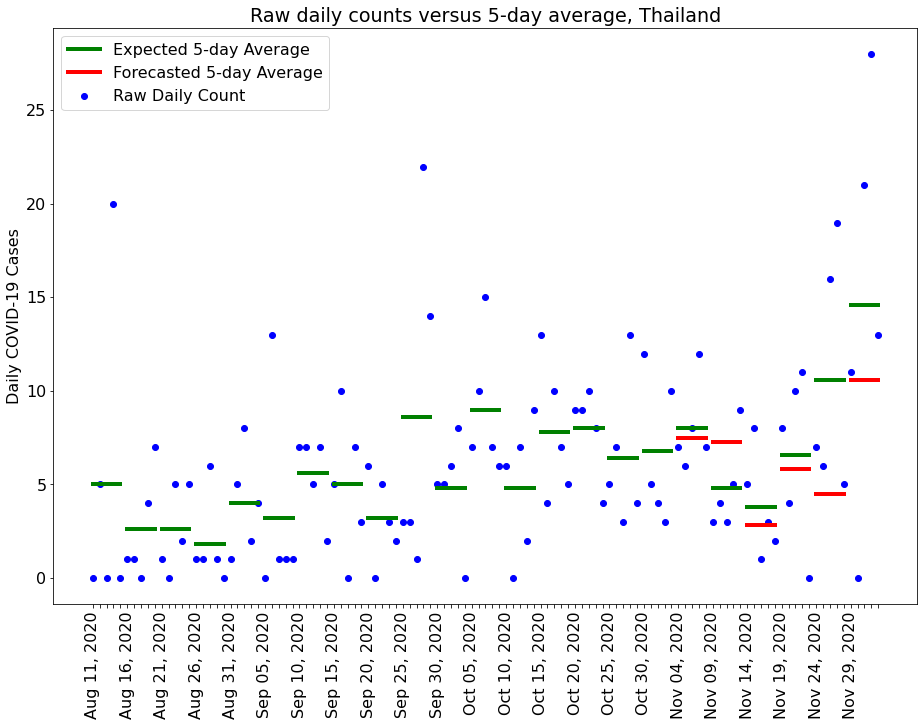

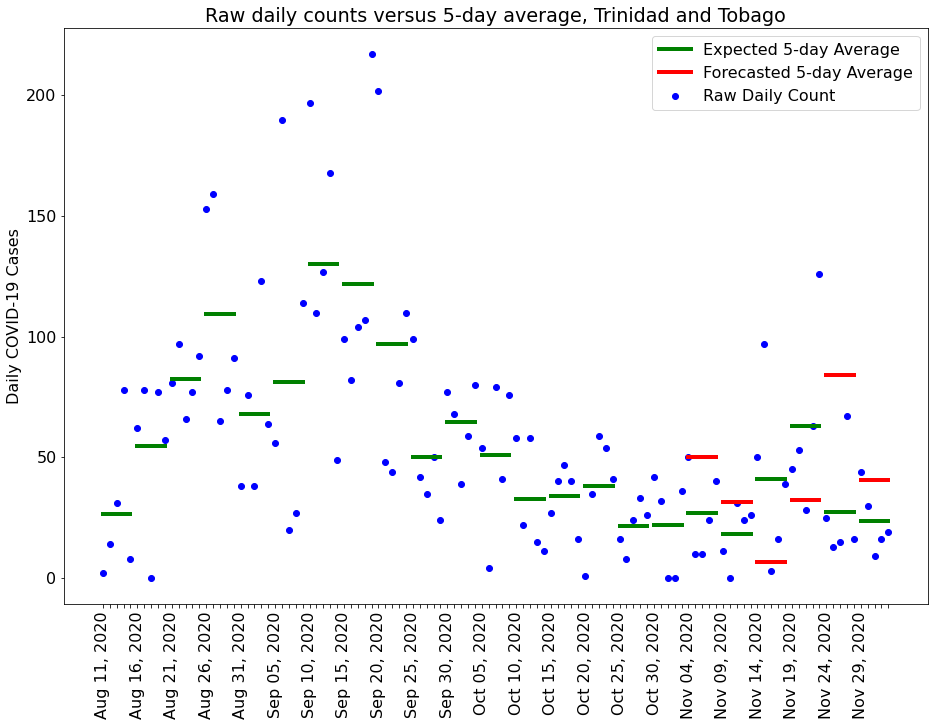

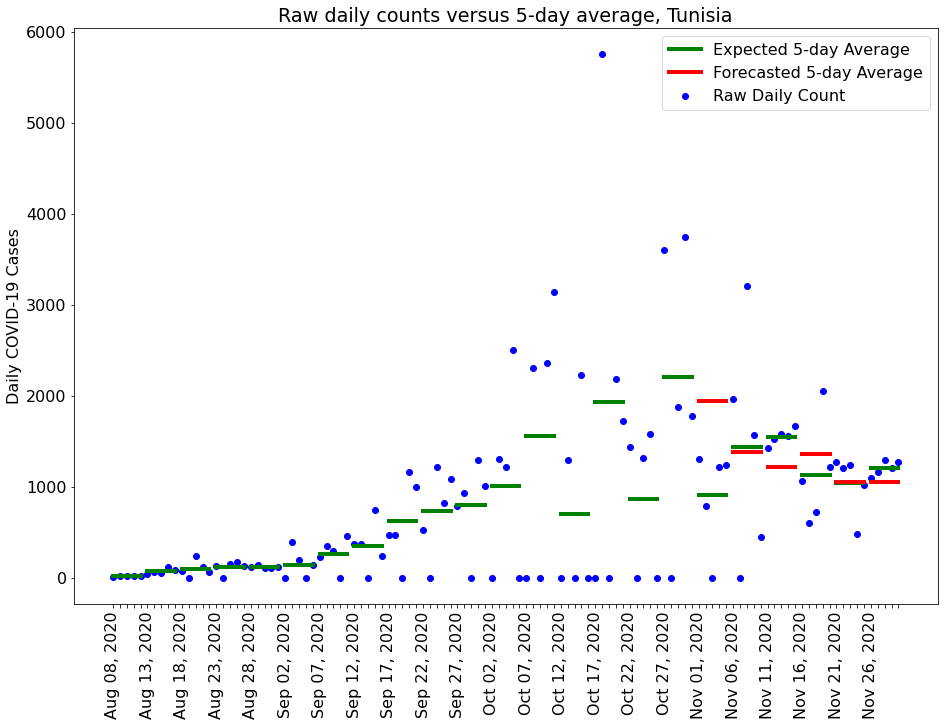

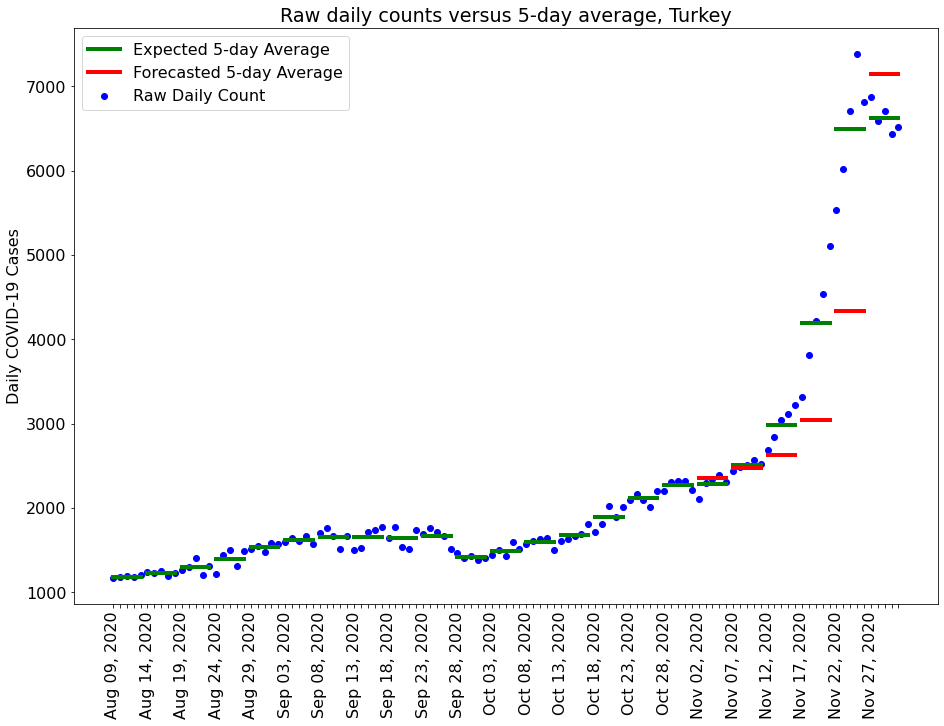

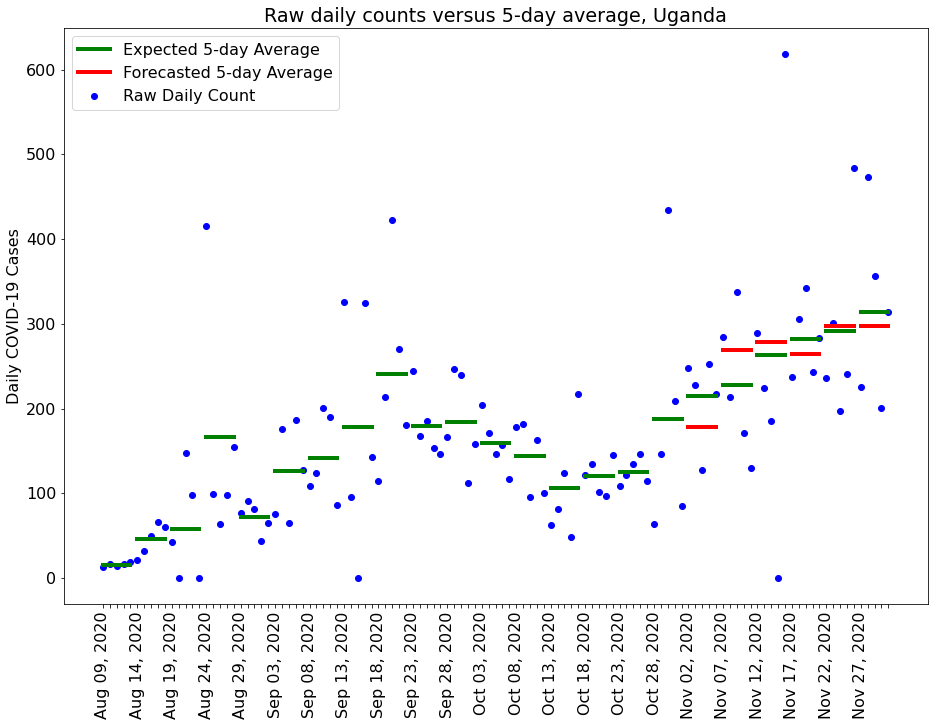

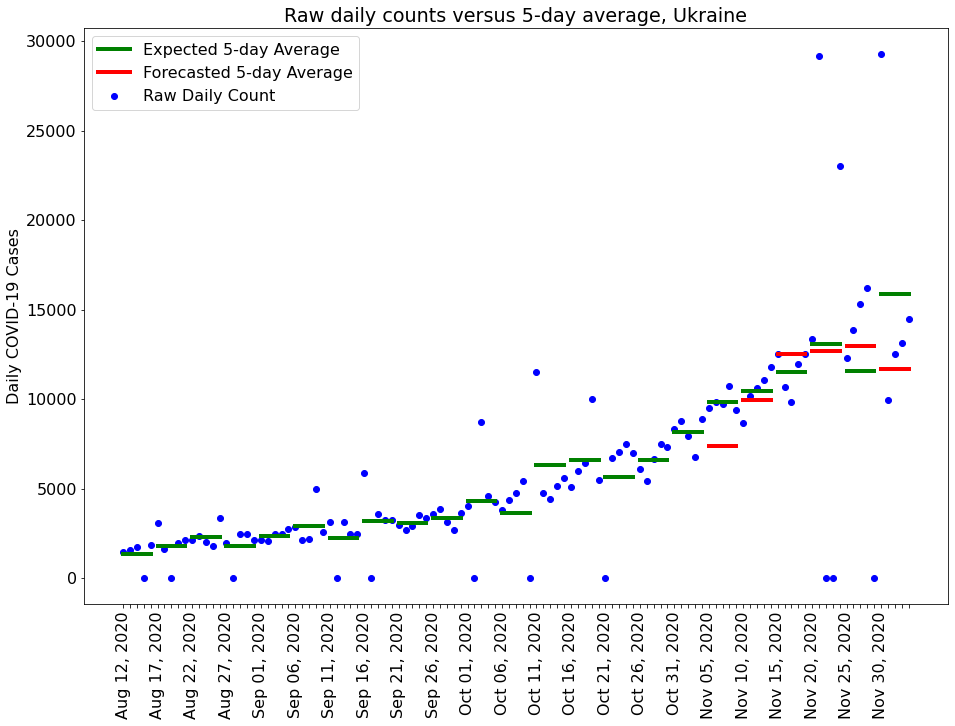

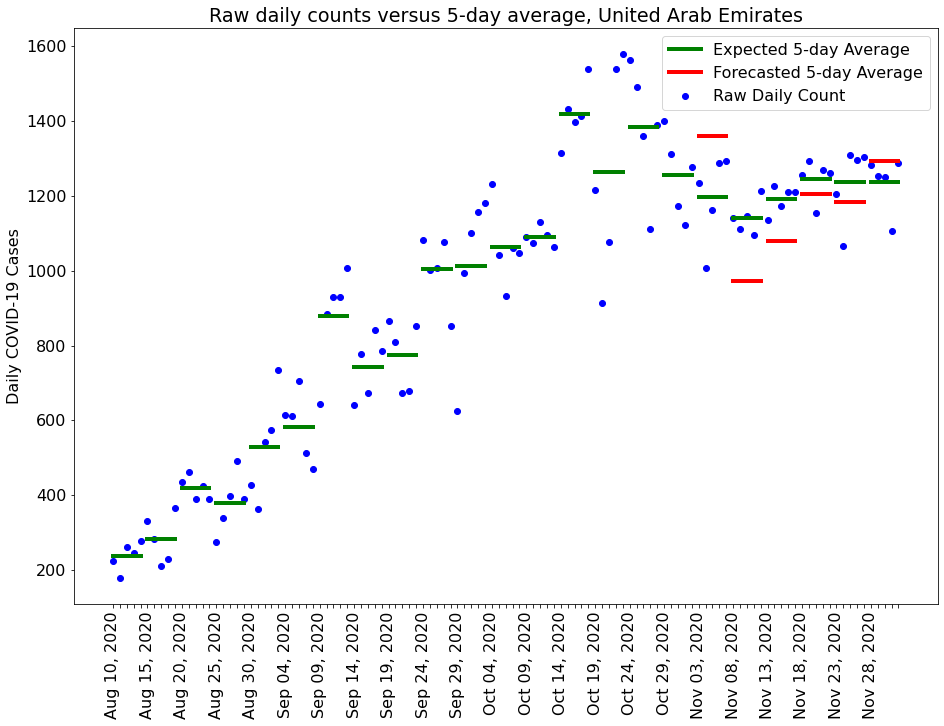

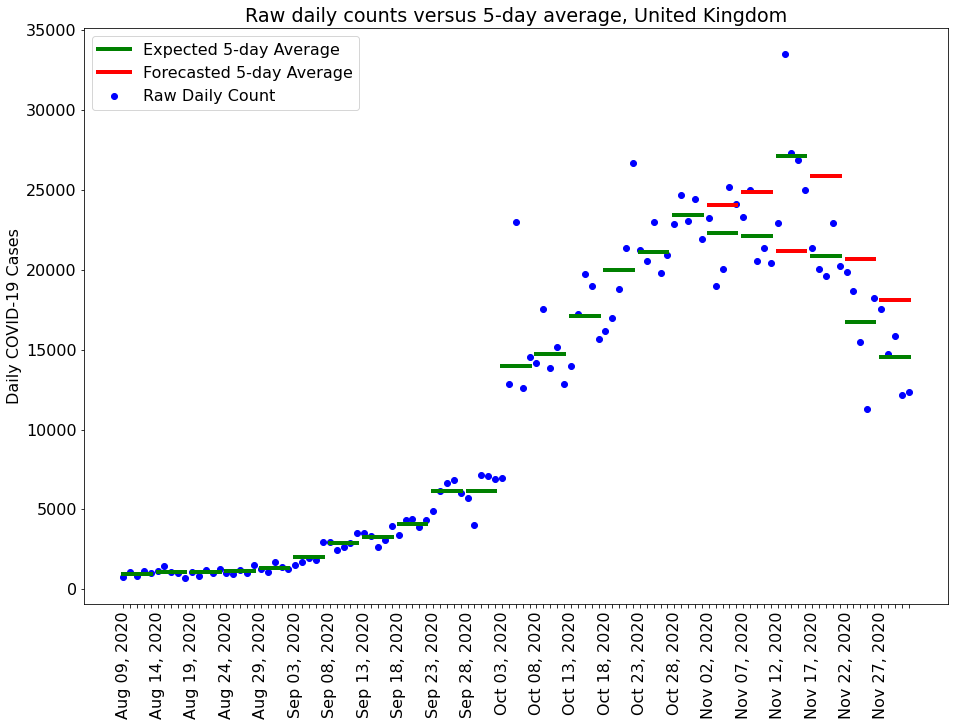

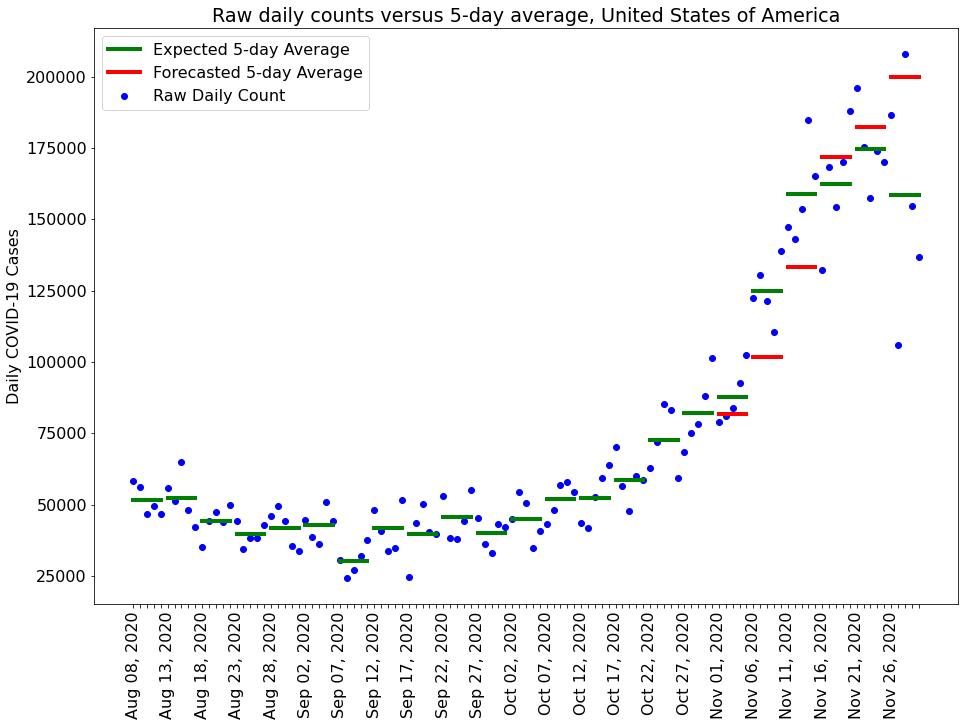

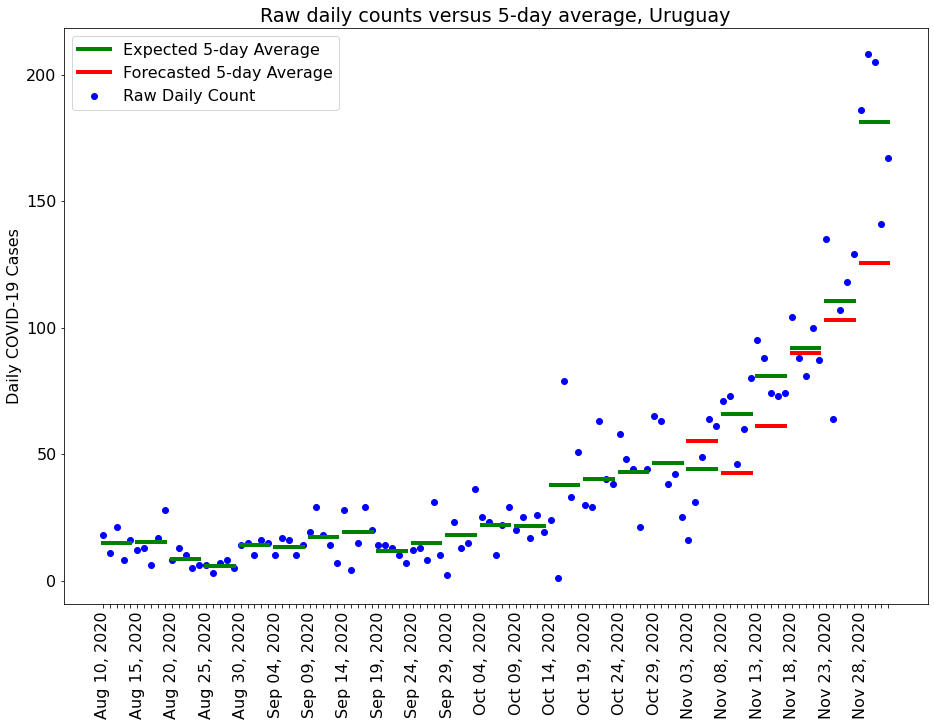

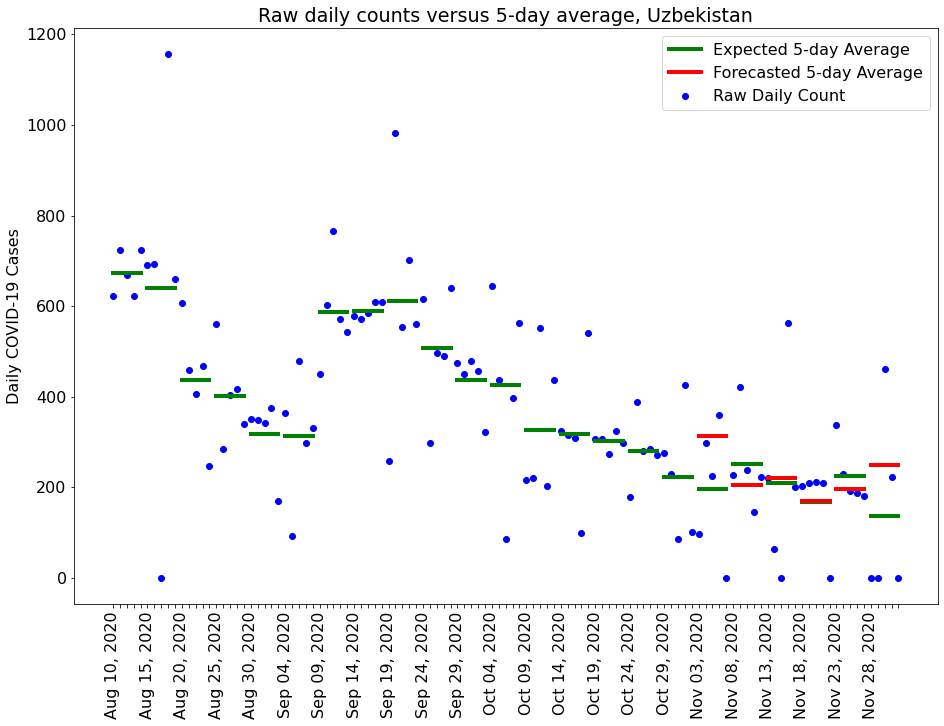

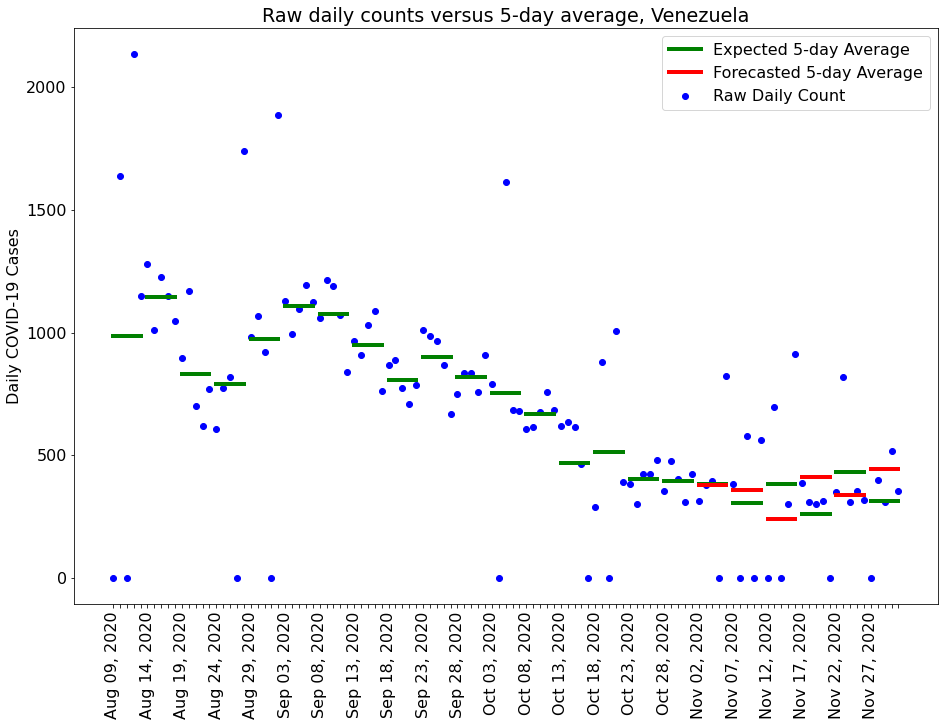

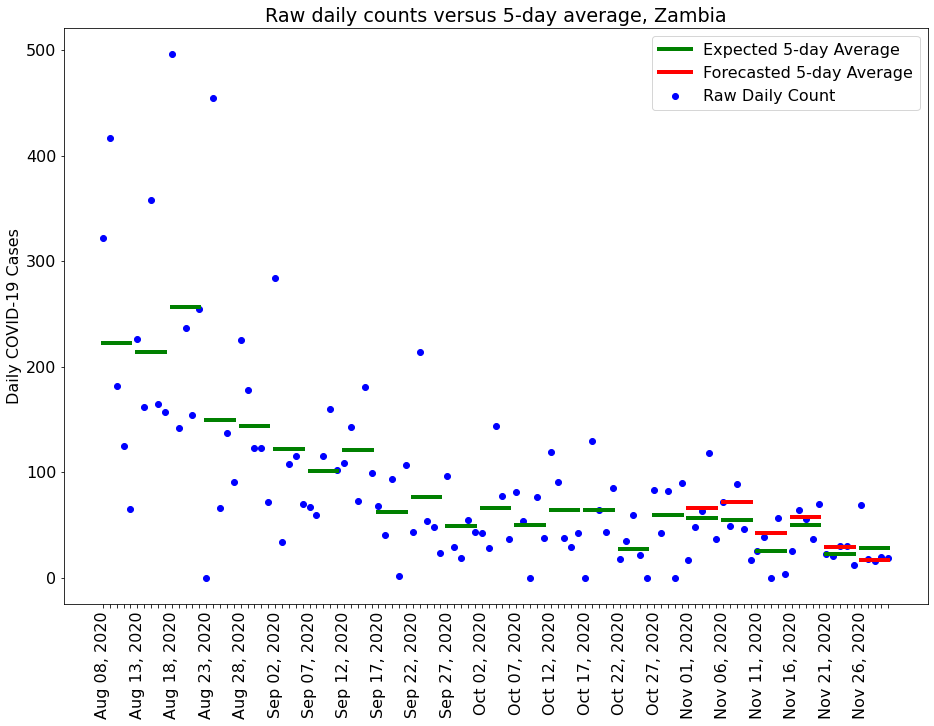

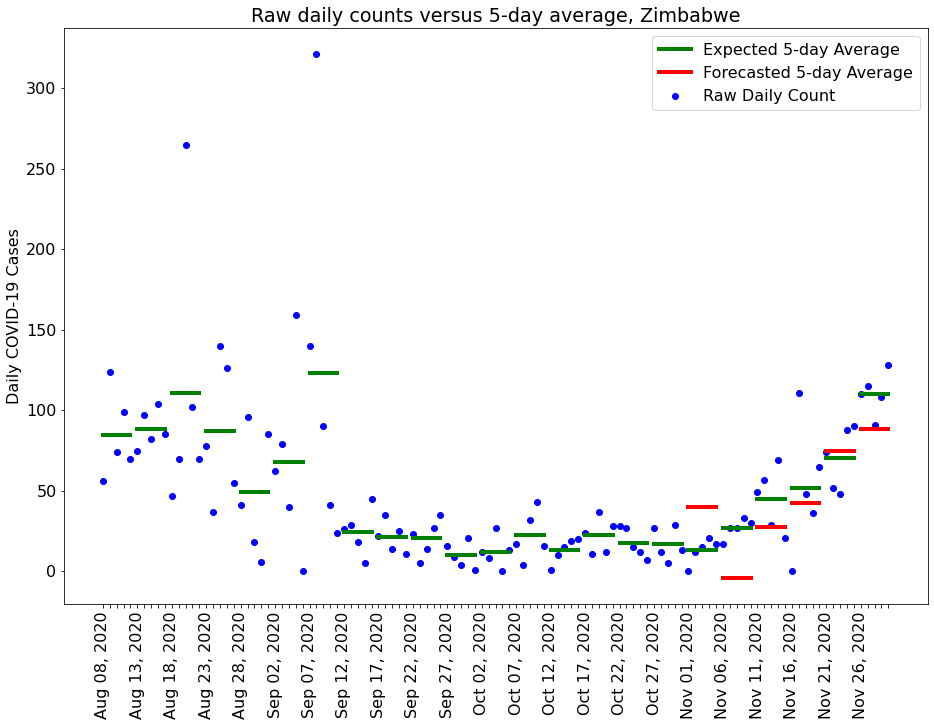

In [ ]:
# function used for simple int to month conversion
def convert(s):
    splits = s.split('-')
    year = splits[0]
    month = splits[1]
    day = splits[2]
    if month == '01': month = 'Jan'
    if month == '02': month = 'Feb'
    if month == '03': month = 'Mar'
    if month == '04': month = 'Apr'
    if month == '05': month = 'May'
    if month == '06': month = 'Jun'
    if month == '07': month = 'Jul'
    if month == '08': month = 'Aug'
    if month == '09': month = 'Sep'
    if month == '10': month = 'Oct'
    if month == '11': month = 'Nov'
    if month == '12': month = 'Dec'
    return month + ' ' + day + ', ' + year

# function to plot a country's time series data along with averages and forecasts
def show_country_ts(country, sample, data):
    rs = []
    for idx, c in enumerate(sample['countries']):
        if c == country:
            rs.append(idx)
    aves = sample['Xs'][rs[0]].copy()
    dates = sample['dates'][rs[0]][0:-1].copy()
    preds = []
    for r in rs:
        aves += sample['Ys'][r]
        dates += [sample['dates'][r][-1]]
        preds += [sample['Ps'][r]]
    raws = data[data['Country'] == country][data['Date'] >= dates[0]]['Cases'].to_numpy()[0:n*len(aves)]
    fig = plt.figure(figsize=(15,10))
    axes= fig.add_axes([0.1,0.1,0.8,0.8])
    x = []
    for d in dates:
        x = x + [convert(str(d.strftime('%Y-%m-%d')))] + ['' for _ in range(n-1)] 
    for idx, ave in enumerate(aves):
        if idx == 0:
            axes.plot([_ for _ in range(idx*n, idx*n+n, 1)], [ave for _ in range(n)], color='green', linewidth=4, label='Expected ' + str(n) + '-day Average')
        else:
            axes.plot([_ for _ in range(idx*n, idx*n+n, 1)], [ave for _ in range(n)], color='green', linewidth=4)
    axes.scatter([_ for _ in range(len(raws))], raws, color='blue', label='Raw Daily Count')
    for idx, pred in enumerate(preds):
        if idx == 0:
            axes.plot([_ for _ in range(k*n, k*n+n, 1)], [pred for _ in range(n)], color='red', linewidth=4, label='Forecasted ' + str(n) + '-day Average')
        else:
            axes.plot([_ for _ in range(k*n + idx*n, k*n+n + idx*n, 1)], [pred for _ in range(n)], color='red', linewidth=4)
    axes.legend()#loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xticks([_ for _ in range(len(raws))], x, rotation='vertical')
    plt.ylabel('Daily COVID-19 Cases')
    plt.title('Raw daily counts versus ' + str(n) + '-day average, ' + country)
    
# plot each country time series with forecast
countries = list(set(samples['test']['countries']))
countries.sort()
for country in countries:
    show_country_ts(country, samples['test'], data)